Flow Rate Profile Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


In [ ]:
from tensorflow.python.util.tf_export import get_canonical_name_for_symbol
import numpy as np
import cv2
import os
import csv
import matplotlib.pyplot as plt
import sys
from google.colab.patches import cv2_imshow #to see images, can be deleted later
import pandas as pd

import gspread_dataframe as gd
import gspread as gs
import statistics as stat

In [ ]:
def defineLane(start, end):
	'''
	Auxilliary function used to correctly determine which pixels to look at in the lane, regardless of whether the pixel
	numbers go from high to low or low to high
	'''
	points = []
	temp = end - start
	if temp < 0:
		for i in range(end, start):
			points.append(i)
	else:
		for i in range(start, end):
			points.append(i)
	return points

In [ ]:
def examplebounds_multiLane(videoName, location, start, end, axes, channelgap, channelnum,
                            lanestep=3, lanenum=5, frame=100):
  '''
  Given a video file, the function will show a grayscale image depicting where the analysis algorithm would consider
  the lane to be (by using a solid black line over the first frame of the video)

  Parameters:
  "videoName" = the file name of the video file
  "location" = if the axis is horizontal, then location is the pixel row containing the desired lane, while if the
          axis vertical, then location is the pixel column contained the desired lane
  "start" = the starting pixel in the row/column (dictated by "Location" parameter) of the desired lane
  "end" = the ending pixel in the row/column (dictated by the "Location" parameter) of the desired lane
  "axes" = determines whether the desired flow lane is horizontal or vertical in the video file (MUST BE EITHER "H" OR "V")
  "lanestep" = the distance between each lane, default is 3 pixels since each lane will use data in 3-pixel-width
  "lanenum" = the number of lane will be created in one channel
  "frame" = the desired frame of video to view
  '''

  if axes not in ['H', 'V']:
    print('Axes parameter not allowed, must be either H or V')
    sys.exit()
  if lanenum%2==0:
    print(f"Only odd number is acceptable as the number of lane! Current lanenum is {lanenum}")
    sys.exit()

  # make sure end value is larger than start value
  # so that start:end can be the index
  if start > end:
    tmp = start
    start = end
    end = tmp

  # a list recording the shifts of each lane from the middle lane
  laneshift = np.arange(-int(lanenum/2), int(lanenum/2)+1, step = 1) * lanestep

  video = cv2.VideoCapture(videoName)
  print('Video name: {}'.format(videoName))
  print('Video length (frames): {}'.format(video.get(cv2.CAP_PROP_FRAME_COUNT)))
  print('Video FPS (framerate): {}'.format(video.get(cv2.CAP_PROP_FPS)))
  video.set(cv2.CAP_PROP_POS_FRAMES, frame)
  success, image = video.read()
  if success:
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if axes == 'H':
      for i in range(channelnum):
        # draw black lines with given laneshift in one channel
        gray[location+channelgap*i+laneshift, start:end] = 0
    elif axes == 'V':
      for i in range(channelnum):
        gray[start:end, location+channelgap*i+laneshift] = 0
    #cv2.imwrite('test bounds.png', gray) # save the test bounds, not necessary
    cv2_imshow(gray)
  else:
    print('Video reading failed, please check the video file name!')
  video.release()

In [ ]:
def flowAnalysis(videoName, location, start, end, axes, threshold=10, framestart=100, duration=350):
  '''
  Given a video file, return a list of the flow profile of the moving front. Each index will represent a frame of the
  original video file, and its value will represent how many pixels the wetting front has flowed through

  Parameters:
  "videoName" = the file name of the video file
  "Location" = if the axis is horizontal, then location is the pixel row containing the desired lane, while if the
          axis vertical, then location is the pixel column contained the desired lane
  "start" = the starting pixel in the row/column (dictated by "Location" parameter) of the desired lane
  "end" = the ending pixel in the row/column (dictated by the "Location" parameter) of the desired lane
  "axes" = determines whether the desired flow lane is horizontal or vertical in the video file (MUST BE EITHER "H" OR "V")
  "threshold" = the brightness change in a pixel within the flow lane that is considered to be high enough to count to the flow
  "framestart" = the starting frame of the video file to be analyzed
  "duration" = the duration (frames) to be analyzed from the starting frame
  '''

  # NOTE: if you're not seeing any movement in your data, change this threshold value! It represents the brightness change
  # in a pixel within the flow lane that is considered to be high enough to conclude that the moving front has moved to
  # that location.

  laneLength = defineLane(start, end)

  flowProfile = []
  video = cv2.VideoCapture(videoName)
  video.set(cv2.CAP_PROP_POS_FRAMES, framestart)

  #print('Video name: {}'.format(videoName))
  #print('Video length (frames): {}'.format(video.get(cv2.CAP_PROP_FRAME_COUNT)))
  initialLane = []

  for imagenumber in range(0, duration):
    success, image = video.read()
    if success:
      image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

      # Get a list of grayscale value along the channel (averaged from 3-pixel width)
      # initialLane: the first frame
      # currentLane: grayscale value of the current frame
      if initialLane == []:
        for i in laneLength:
          triplet = []
          for j in range(-1, 2):
            if axes == 'H':
              triplet.append(gray[location + j, i])
            elif axes == 'V':
              triplet.append(gray[i, location + j])
          initialLane.append(np.average(triplet))

      currentLane = []
      for i in laneLength:
        triplet = []
        for j in range(-1, 2):
          if axes == 'H':
              triplet.append(gray[location + j, i])
          elif axes == 'V':
            triplet.append(gray[i, location + j])
        currentLane.append(np.average(triplet))

      # Compare the currentLane to intialLane
      # Records how many pixels has a intensity change over the threshold, which is the flow distance
      differences = 0
      for i in range(0, len(laneLength)):
        difference = initialLane[i] - currentLane[i]
        if difference >= threshold:
          differences += 1

      flowProfile.append(differences)

  return flowProfile

In [ ]:
def flowCutoff(data, cutoff=20):
  '''
  Cut the flow profile to remove the initial plauteu stage, and have a start around at the cutoff value.
  It will search the fist value less than the cutoff from the back of the list, and cut from there.

  Parameters:
  "data" = the flow profile to be cut
  "cutoff" = the distance (pixels) you want the cut flow profile to start from
  '''
  for i in range(len(data)):
    if data[-(i+1)]<=cutoff:
      if cutoff-data[-(i+1)] < data[-i]-cutoff:
        return data[-(i+1):]
      else:
        return data[-i:]
  print(f'The flow profile remains same since no value less than {cutoff} has been found.')
  return data

In [ ]:
def flowAnalysis_multiLane(videoName, location, start, end, axes, channelnum, channelgap, threshold=10,
                           lanestep=3, lanenum=5, framestart=100, duration=350,
                           cutoff_option=False, cutoff=20):
  '''
  Create multiple lanes in one channel and return a list of the flow profile of the moving front

  Additional parameters compared to flowAnalysis:
  "channelnum" = the number of channels per chip
  "channelgap" = jump from channel to chnl in px distance
  "lanestep" = the distance between each lane, default is 3 pixels since each lane will use data in 3-pixel-width
  "lanenum" = the number of lane will be created in one channel
  "cutoff_option" = the option to cut the flow profile
  "cutoff" = the number of pixels to cut the flow profile
  '''
  possibleAxes = ['H', 'V']
  if axes not in possibleAxes:
    print('Axes parameter not allowed, must be either H or V')
    sys.exit()
  if lanenum%2==0:
    print(f"Only odd number is accepeted as the number of lane! Current lanenum is {lanenum}")
    sys.exit()

  # a list recording the location of middle line (lane) in each channel
  if axes == 'H':
    channel_location = np.arange(location, location-channelgap*channelnum, step = -channelgap)
    #assuming 1st channel is on bottom of chip
  elif axes == 'V':
    channel_location = np.arange(location, location+channelgap*channelnum, step = channelgap)
    #assuming 1st channel is on far left of chip
  else:
    print('Check which channel you are starting on')

  # a list recording the shifts of each lane from the middle lane
  laneshift = np.arange(-int(lanenum/2), int(lanenum/2)+1, step = 1) * lanestep

  # dataframe: flowprofile of each lane
  if cutoff_option:
    print(f'Each flow profile will be cut to start around {cutoff} pixels')

  df_flowProfile = pd.DataFrame()
  df_flowProfile_cutoff = pd.DataFrame()

  # iterate through channels
  for channel, location in enumerate(channel_location):
    # iterate through lanes
    for lane, shift in enumerate(laneshift):
      name='Ch'+str(channel+1)+'_Lane'+str(lane+1)
      print(f'Analyzing {name}')

      flowProfile_list = flowAnalysis(videoName, location+shift, start, end, axes, threshold=threshold,
                                      framestart=framestart, duration=duration)
      df_flowProfile[name]= pd.Series(flowProfile_list)

      print('Maximum flow (pixels): {}'.format(np.amax(flowProfile_list)))
      plt.figure()
      plt.suptitle('Flow Profile (Pixels vs. Frame Number)')
      plt.plot(flowProfile_list, label='raw data')

      if cutoff_option:
        flowProfile_list_cutoff = flowCutoff(flowProfile_list, cutoff=cutoff)
        df_flowProfile_cutoff[name]= pd.Series(flowProfile_list_cutoff)
        plt.plot(flowProfile_list_cutoff, label=f'cutoff={cutoff}')

      plt.legend()
      plt.show()
      plt.close()
      print('------------------------------------------------------------------------')
  return df_flowProfile, df_flowProfile_cutoff

In [ ]:
# Change the below to open up the folder that has the videos in it
#!ls "/content/drive/MyDrive/PFAS_Project/BW/BW.PFOA Videos/Lysozyme"
!ls "/content/drive/MyDrive/PFAS_Project/Tucson Water/Secondary effluent/SeungJu"

TW-11.100pgBSA.mp4	    TW-13.1pgLysozyme.mp4
TW-11.100pgLysine.mp4	    TW-15.100pgBSA.mp4
TW-11.100pgLysozyme.mp4     TW-15.100pgLysine.mp4
TW-11.10ngAsparticAcid.mp4  TW-15.100pgLysozyme.mp4
TW-11.10ngBSA.2.mp4	    TW-15.10ngAsparticAcid.mp4
TW-11.10ngBSA.mp4	    TW-15.10ngBSA.mp4
TW-11.10ngGlutamine.mp4     TW-15.10ngGlutamine.mp4
TW-11.10ngMyoglobin.mp4     TW-15.10ngMyoglobin.mp4
TW-11.1pgBSA.mp4	    TW-15.1pgBSA.mp4
TW-11.1pgLysozyme.mp4	    TW-15.1pgLysozyme.mp4
TW-13.100pgBSA.mp4	    TW-9.100pgBSA.mp4
TW-13.100pgLysine.mp4	    TW-9.100pgLysine.mp4
TW-13.100pgLysozyme.mp4     TW-9.100pgLysozyme.mp4
TW-13.10ngAsparticAcid.mp4  TW-9.10ngAsparticAcid.mp4
TW-13.10ngBSA.2.mp4	    TW-9.10ngBSA.mp4
TW-13.10ngBSA.mp4	    TW-9.10ngGlutamine.mp4
TW-13.10ngGlutamine.mp4     TW-9.10ngMyoglobin.mp4
TW-13.10ngMyoglobin.mp4     TW-9.1pgBSA.mp4
TW-13.1pgBSA.mp4	    TW-9.1pgLysozyme.mp4


Video name: TW-15.10ngMyoglobin.mp4
Video length (frames): 902.0
Video FPS (framerate): 15.010781024730807


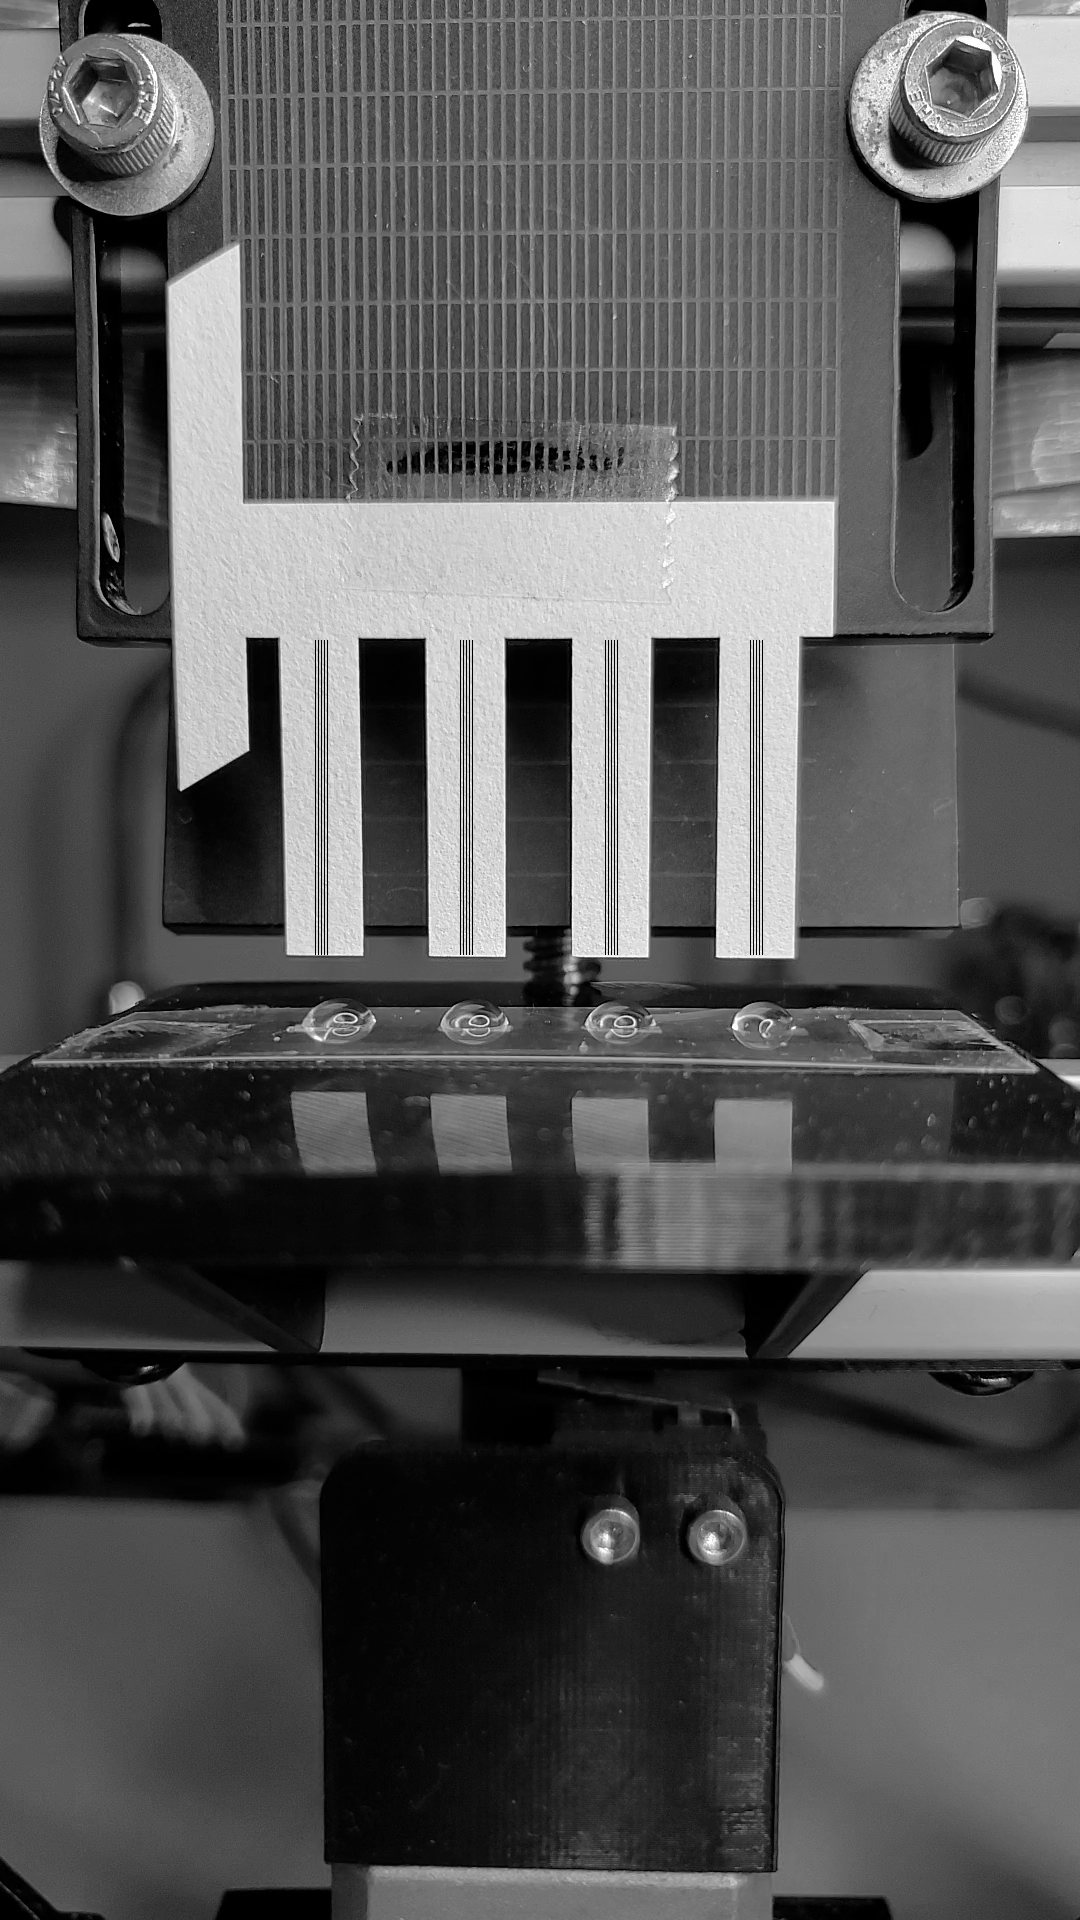

'\n!! What you need to check before moving forward !!\n1. the line is inside of paperchip, especially not over the edge of sample loading side\n2. the drop has not touched the chip at the frame you pick to start\n'

In [ ]:
#EDITABLE FOR DATA COLLECTION

file_path = "/content/drive/MyDrive/PFAS_Project/Tucson Water/Secondary effluent/SeungJu"
os.chdir(file_path)

videoName = 'TW-15.10ngMyoglobin.mp4'

axes = 'V' # H - horizontal, V - vertical
start = int(640)
end = int(955)# #pixel along the channel
location = int(321) #Row/channel initial position for horizontal chip/Verticla chip would be column (moves horizontally)
channelgap = int(145) #jump from channel to chnl in px distance
channelnum = int(4) # the number of channels per chip

lanenum = int(5) # how many lanes in one channel being analyzed, required: odd
lanestep = int(3) # px distance between each lane, required: >=3
framestart = int(50) # analyze the video from which frame
duration = int(350) # how many frames will be analyzed

# show example lanes in each channel
# show where is the sample stage at start frame
examplebounds_multiLane(videoName, location, start, end, axes, channelgap, channelnum, lanestep=lanestep, lanenum=lanenum, frame=framestart)
# if want to see where is the flow at end frame
# examplebounds_multiLane(videoName, location, start, end, axes, channelgap, channelnum, lanestep=lanestep, lanenum=lanenum, frame=framestart+duration)

'''
!! What you need to check before moving forward !!
1. the line is inside of paperchip, especially not over the edge of sample loading side
2. the drop has not touched the chip at the frame you pick to start
'''

Each flow profile will be cut to start around 20 pixels
Analyzing Ch1_Lane1
Maximum flow (pixels): 155


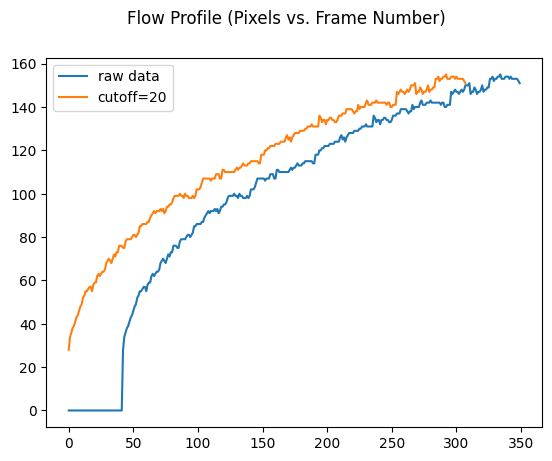

------------------------------------------------------------------------
Analyzing Ch1_Lane2
Maximum flow (pixels): 151


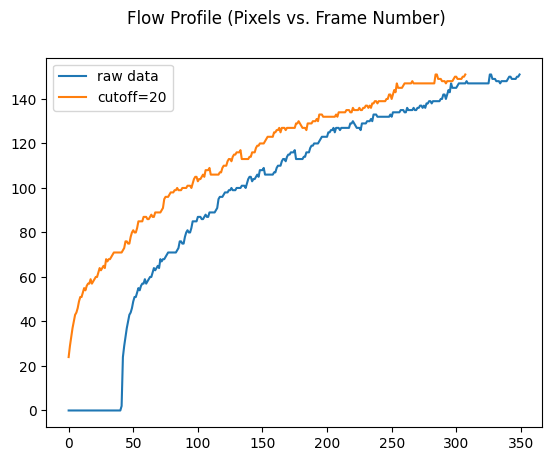

------------------------------------------------------------------------
Analyzing Ch1_Lane3
Maximum flow (pixels): 157


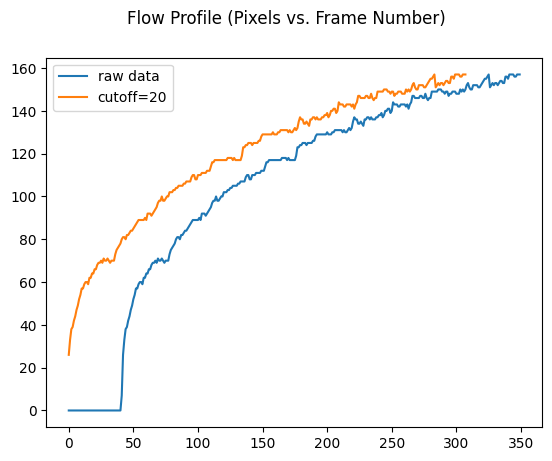

------------------------------------------------------------------------
Analyzing Ch1_Lane4
Maximum flow (pixels): 160


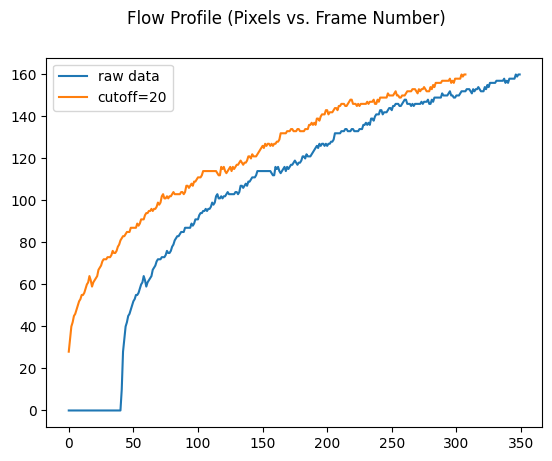

------------------------------------------------------------------------
Analyzing Ch1_Lane5
Maximum flow (pixels): 162


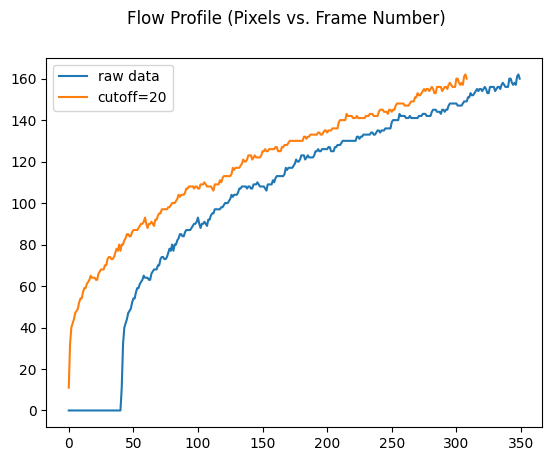

------------------------------------------------------------------------
Analyzing Ch2_Lane1
Maximum flow (pixels): 163


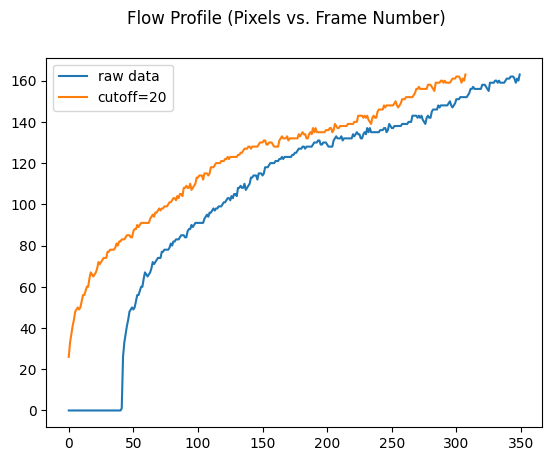

------------------------------------------------------------------------
Analyzing Ch2_Lane2
Maximum flow (pixels): 160


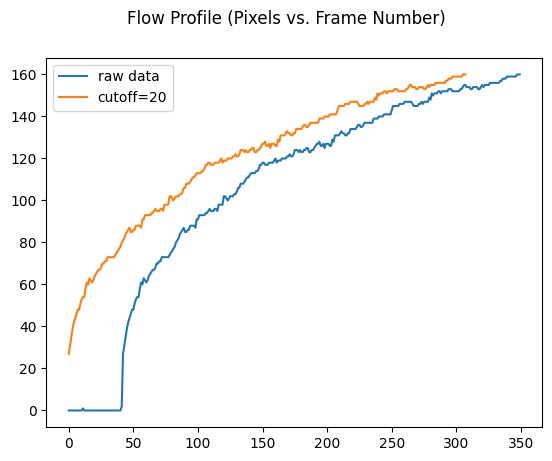

------------------------------------------------------------------------
Analyzing Ch2_Lane3
Maximum flow (pixels): 157


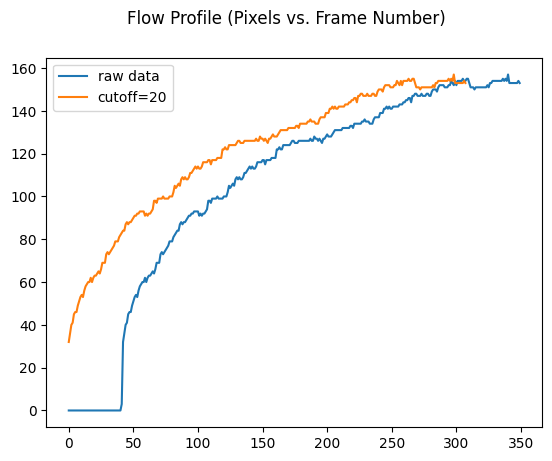

------------------------------------------------------------------------
Analyzing Ch2_Lane4
Maximum flow (pixels): 161


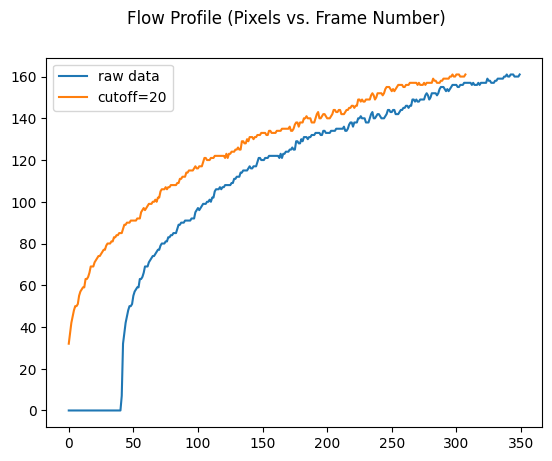

------------------------------------------------------------------------
Analyzing Ch2_Lane5
Maximum flow (pixels): 163


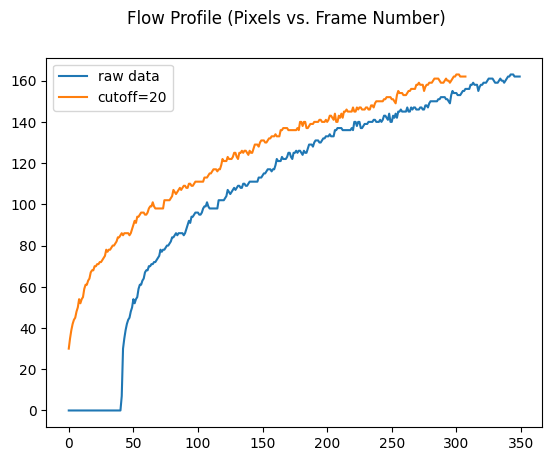

------------------------------------------------------------------------
Analyzing Ch3_Lane1
Maximum flow (pixels): 158


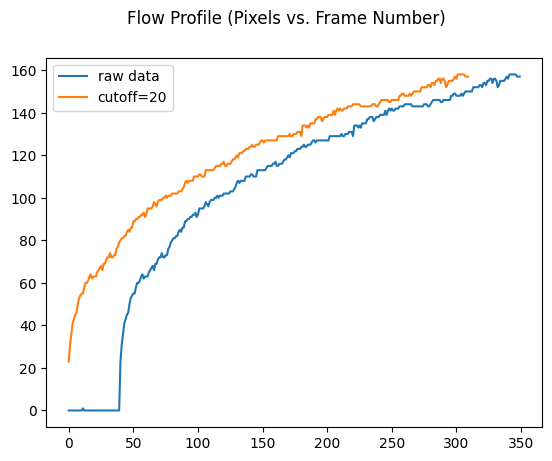

------------------------------------------------------------------------
Analyzing Ch3_Lane2
Maximum flow (pixels): 157


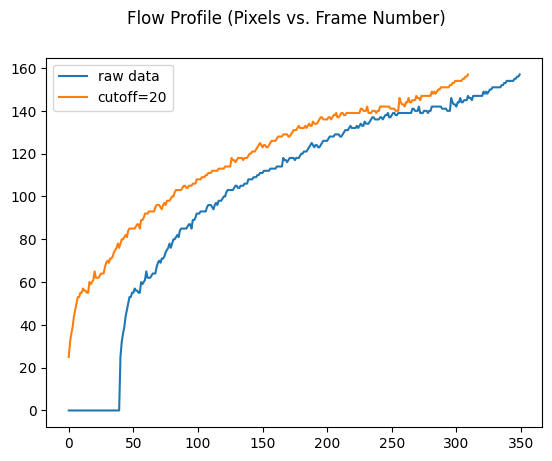

------------------------------------------------------------------------
Analyzing Ch3_Lane3
Maximum flow (pixels): 162


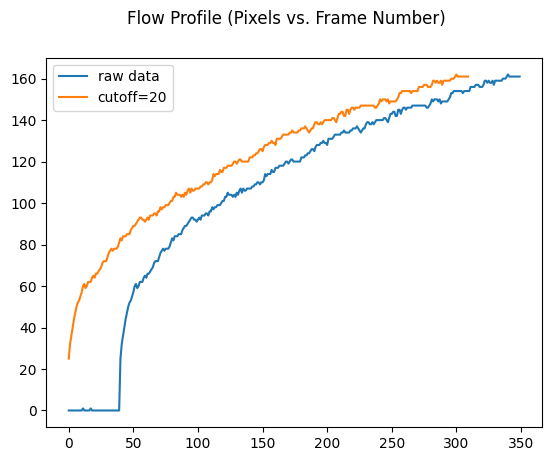

------------------------------------------------------------------------
Analyzing Ch3_Lane4
Maximum flow (pixels): 151


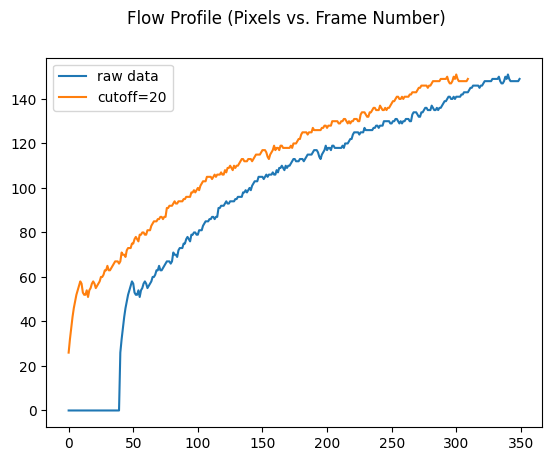

------------------------------------------------------------------------
Analyzing Ch3_Lane5
Maximum flow (pixels): 156


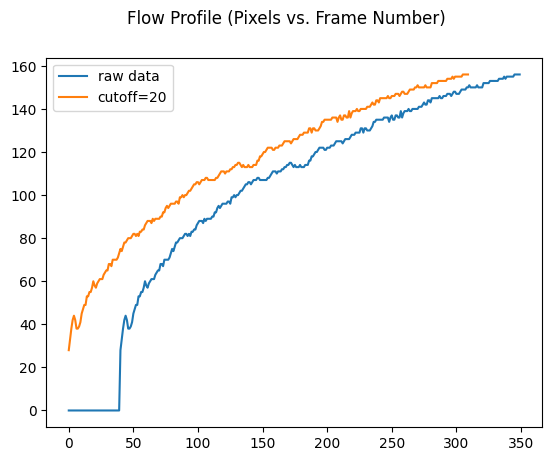

------------------------------------------------------------------------
Analyzing Ch4_Lane1
Maximum flow (pixels): 154


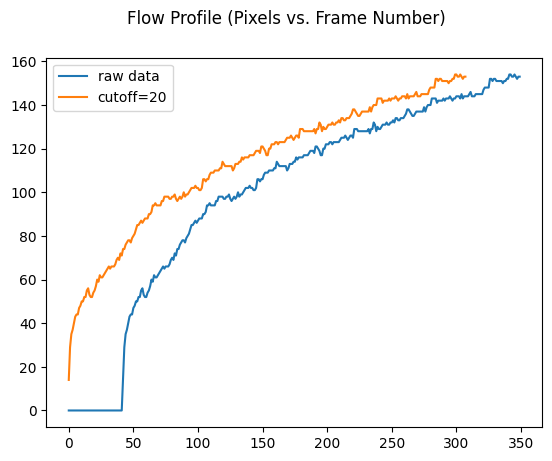

------------------------------------------------------------------------
Analyzing Ch4_Lane2
Maximum flow (pixels): 148


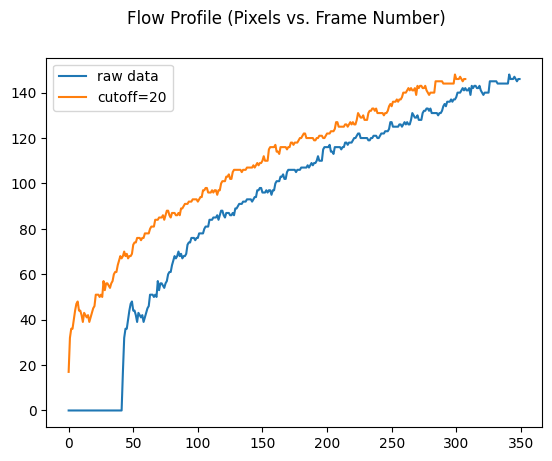

------------------------------------------------------------------------
Analyzing Ch4_Lane3
Maximum flow (pixels): 152


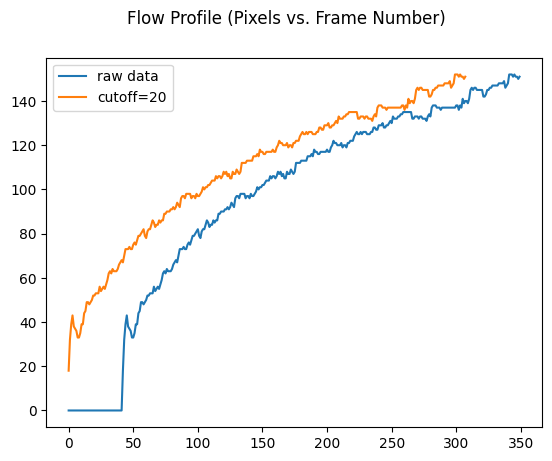

------------------------------------------------------------------------
Analyzing Ch4_Lane4
Maximum flow (pixels): 156


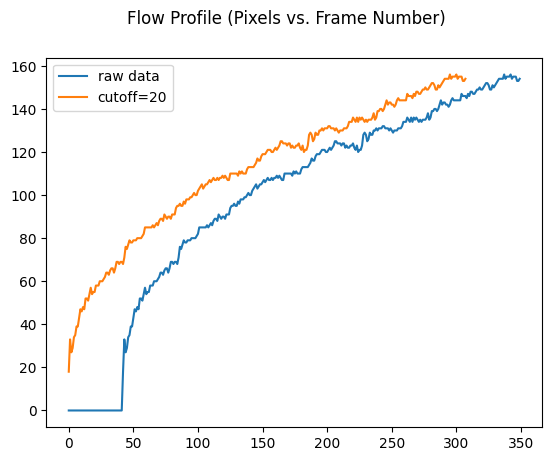

------------------------------------------------------------------------
Analyzing Ch4_Lane5
Maximum flow (pixels): 153


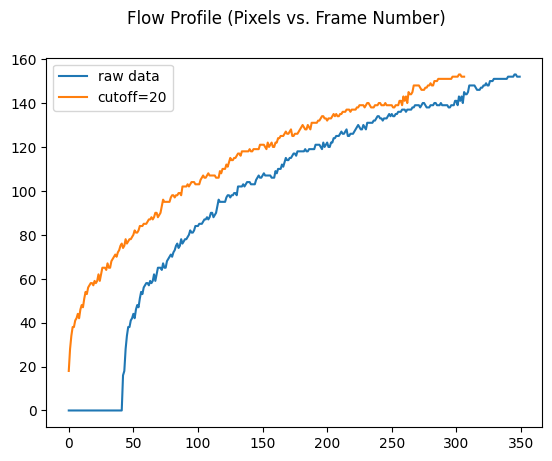

------------------------------------------------------------------------


In [ ]:
# threshold = the brightness change in a pixel within the flow lane that is considered to be high enough to count to the flow
# If brightness change exceeds this value, the pixel will be considered as wet counting towards flow distance
# Note: Lower the threshold too much will potentially introduce more noise to flow profile
#       since pixels with random intensity fluctuation (not wetting) may be counted.
# threshold = 10
threshold = 10

# the option to cut the flow profile to a similar start
cutoff_option = True
cutoff = 20 # pixels

flowData = pd.DataFrame()
flowData_cutoff = pd.DataFrame()

#flowData, _ = flowAnalysis_multiLane(videoName, location, start, end, axes, channelnum, channelgap, threshold=10,
#                                        lanestep=lanestep, lanenum=lanenum, framestart=framestart, duration=duration)
flowData, flowData_cutoff = flowAnalysis_multiLane(videoName, location, start, end, axes, channelnum, channelgap, threshold=threshold,
                                                   lanestep=lanestep, lanenum=lanenum, framestart=framestart, duration=duration,
                                                   cutoff_option=cutoff_option, cutoff=cutoff)


In [ ]:
display(flowData_cutoff)
display(flowData)

Ch1_Lane1  Ch1_Lane2  Ch1_Lane3  Ch1_Lane4  Ch1_Lane5  Ch2_Lane1  \
0           28         24         26         28         11         26   
1           34         29         33         34         32         33   
2           36         33         38         40         40         37   
3           38         37         39         42         42         41   
4           39         40         42         45         44         44   
..         ...        ...        ...        ...        ...        ...   
303        153        149        156        158        157        161   
304        153        149        156        160        158        159   
305        153        150        157        159        157        161   
306        152        150        157        160        161        160   
307        151        151        157        160        162        163   

     Ch2_Lane2  Ch2_Lane3  Ch2_Lane4  Ch2_Lane5  Ch3_Lane1  Ch3_Lane2  \
0           27         32         32         30         23         25   
1           31         36         37         35         31         32   
2           35         40         42         39         36         36   
3           39         41         45         42         41         39   
4           42         45         48         44         43         44   
..         ...        ...        ...        ...        ...        ...   
303        159        153        160        162        158        154   
304        159        153        160        162        158        154   
305        160        153        160        162        158        155   
306        160        154        160        162        158        155   
307        160        153        161        162        157        156   

     Ch3_Lane3  Ch3_Lane4  Ch3_Lane5  Ch4_Lane1  Ch4_Lane2  Ch4_Lane3  \
0           25         26         28         14         17         18   
1           32         32         33         29         32         32   
2           36         37         38         35         36         39   
3           40         42         42         37         36         43   
4           44         46         44         40         40         38   
..         ...        ...        ...        ...        ...        ...   
303        161        148        155        154        147        152   
304        161        148        155        153        146        151   
305        161        148        156        152        145        151   
306        161        148        156        153        146        150   
307        161        148        156        153        146        151   

     Ch4_Lane4  Ch4_Lane5  
0           18       18.0  
1           33       28.0  
2           27       34.0  
3           29       38.0  
4           34       38.0  
..         ...        ...  
303        155      153.0  
304        155      152.0  
305        153      152.0  
306        153      152.0  
307        154        NaN  

[308 rows x 20 columns]

Ch1_Lane1  Ch1_Lane2  Ch1_Lane3  Ch1_Lane4  Ch1_Lane5  Ch2_Lane1  \
0            0          0          0          0          0          0   
1            0          0          0          0          0          0   
2            0          0          0          0          0          0   
3            0          0          0          0          0          0   
4            0          0          0          0          0          0   
..         ...        ...        ...        ...        ...        ...   
345        153        149        156        158        158        161   
346        153        149        156        160        157        159   
347        153        150        157        159        161        161   
348        152        150        157        160        162        160   
349        151        151        157        160        160        163   

     Ch2_Lane2  Ch2_Lane3  Ch2_Lane4  Ch2_Lane5  Ch3_Lane1  Ch3_Lane2  \
0            0          0          0          0          0          0   
1            0          0          0          0          0          0   
2            0          0          0          0          0          0   
3            0          0          0          0          0          0   
4            0          0          0          0          0          0   
..         ...        ...        ...        ...        ...        ...   
345        159        153        160        162        158        155   
346        159        153        160        162        158        155   
347        160        153        160        162        157        156   
348        160        154        160        162        157        156   
349        160        153        161        162        157        157   

     Ch3_Lane3  Ch3_Lane4  Ch3_Lane5  Ch4_Lane1  Ch4_Lane2  Ch4_Lane3  \
0            0          0          0          0          0          0   
1            0          0          0          0          0          0   
2            0          0          0          0          0          0   
3            0          0          0          0          0          0   
4            0          0          0          0          0          0   
..         ...        ...        ...        ...        ...        ...   
345        161        148        156        154        147        152   
346        161        148        156        153        146        151   
347        161        148        156        152        145        151   
348        161        148        156        153        146        150   
349        161        149        156        153        146        151   

     Ch4_Lane4  Ch4_Lane5  
0            0          0  
1            0          0  
2            0          0  
3            0          0  
4            0          0  
..         ...        ...  
345        155        153  
346        155        153  
347        153        152  
348        153        152  
349        154        152  

[350 rows x 20 columns]

In [ ]:
# Save the data to google sheets
gc = gspread.authorize(creds)
sh = gc.create(str(videoName))
_  = sh.add_worksheet(title='RawData', rows="100", cols="20")
ws = gc.open(str(videoName)).worksheet('RawData')
gd.set_with_dataframe(ws, flowData)

if cutoff_option:
  sheetName= f'cutoff={cutoff}px'
  ws = sh.add_worksheet(title=sheetName, rows="100", cols="20")
  ws = gc.open(str(videoName)).worksheet(sheetName)
  gd.set_with_dataframe(ws, flowData_cutoff)

Flow profile processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from googleapiclient.discovery import build
from google.oauth2 import service_account
from google.colab import auth
import pandas as pd


import gspread
from google.auth import default
auth.authenticate_user()
creds, _ = default()

service = build('drive', 'v3', credentials=creds)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Replace with the ID of the folder containing the subfolders
#FOLDER_ID = '1b8DbmK5j107PIho6WM1S328m3wVWJutJ' #Folder: /content/drive/MyDrive/Chloe/PFAS_Project/ML data


#FOLDER_ID = '1uDftbCdI2pfLgDUc8CY4aNEsn0mI20xL' #Folder: /ML data/GenX
#FOLDER_ID = '115vp1roDoTnWAHRGSgptMP8IulBsNFso' #Folder: /ML data/GenX/Glycine
#FOLDER_ID = '1j_DHwgWwUsVVL0lVkQCfUjNmsD45Lt4c' #Folder: /ML data/GenX/Lysine
#FOLDER_ID = '17NWHontCvRr9fg0tqLne3oz0mhBsxrcU' #Folder: /ML data/GenX/Lysozyme
#FOLDER_ID = '1Ta93UOl-L89u3sv2L52m2vAP73KwQSwG' #Folder: /ML data/GenX/BSA # haven't analyzed
#FOLDER_ID = '1gIYdHxhgxRdovebC7Q0ewD4uwvx0FxFD' #Folder: /ML data/PFOS
#FOLDER_ID = '11MqZhp-D01Dsfil9KfUKR6KEZrkI1_ar' #Folder: /ML data/PFOA
#FOLDER_ID = '1U_ua56B9dv-50kelkilj3PXakPobxbCr' #Folder: /ML data/Bottled Water
#FOLDER_ID = '1LPjTsaf31aOT-TtEstzfxdSBlHMgZTHt'#Folder: /ML data/Bottled Water + PFAS
#FOLDER_ID = '1MteieYk86p7hpd8m8WZ7jLaVm0ERKOpQ'#Folder: /ML data/Tucson Water
#FOLDER_ID = '1XBFqwXrbA9gnFD-LA54DYdnp6sU63FGK'#Folder: /ML data/Tucson Water/Tucson Water Additional Experiments/Classification
FOLDER_ID = '1kXwCTin90KpK5cQhZCTgdhF8QtXcxRMb'#Folder: /ML data/Tucson Water/Secondary effuent/SeungJu

#FOLDER_ID = '1-6f-KxoVdK-vkswYm90y3bkyLDgzsUQZ' #Folder: /ML data/Bottled Water + Selected reagents

#FOLDER_ID = '1bszt7DaE-ZCcJJ691aSG2Gsgmc7n9Vvi' #Folder: /ML data/BW/PFOA
#FOLDER_ID = '1-fAwwy79xdKnE7DnyjHbgY8Xtq6M--Fh' #Folder: /ML data/BW/PFOS
#FOLDER_ID = '1PTB3jeCDSAB4U2sf8skoXcKhIFayCzWD' #Folder: /ML data/BW/GenX
#FOLDER_ID = '1YiKG5og27Vq-EXw7Ke_win0k2C815tJr' #Folder: /ML data/TARP wastewater/Raw without ammonium acetate
#FOLDER_ID = '1CfaWJVehd6tBuGgAv5KCnDetgOnG8Xff' #Folder: /ML data/TARP wastewater/With ammonium acetate
#FOLDER_ID = '1xsVn8SdfapmB0xbyqInepBTguYF-Qyyv' #Folder: /ML data/BW/BW
#FOLDER_ID = '1UOlC4AiPEMA3MCjp0ihQRJaJ4nAZwy0y' #Folder: /ML data/BW/BW initial


def get_all_sheets_in_subfolders(folder_id):
    sheet_ids = []
    query = f"'{folder_id}' in parents and mimeType='application/vnd.google-apps.spreadsheet'"
    results = service.files().list(q=query, fields="nextPageToken, files(id, name)").execute()
    items = results.get('files', [])
    for item in items:
      sheet_ids.append([item['id'], item['name']])

    # Recursively search for subfolders
    query = f"'{folder_id}' in parents and mimeType='application/vnd.google-apps.folder'"
    results = service.files().list(q=query, fields="nextPageToken, files(id, name)").execute()
    items = results.get('files', [])
    for item in items:
      sheet_ids.extend(get_all_sheets_in_subfolders(item['id']))
    return sheet_ids


if __name__ == '__main__':
    folder_ids = [
       '1YiKG5og27Vq-EXw7Ke_win0k2C815tJr' #Folder: /ML data/TARP wastewater/Raw without ammonium acetate
    ]
    total_sheets = []
    for fid in folder_ids:
        sheets = get_all_sheets_in_subfolders(fid)
        total_sheets.extend(sheets)
        print(f'{len(sheets)} gsheets have been found in {fid}')

    print(f'Total {len(total_sheets)} gsheets have been found in all subfolders')

44 gsheets have been found in 1YiKG5og27Vq-EXw7Ke_win0k2C815tJr
Total 44 gsheets have been found in all subfolders


In [ ]:
import time
FlowLen = 150
multilane = 5
folder_ids = [
    #'1bszt7DaE-ZCcJJ691aSG2Gsgmc7n9Vvi',  # Folder: /ML data/BW/PFOA
    #'1-fAwwy79xdKnE7DnyjHbgY8Xtq6M--Fh',  # Folder: /ML data/BW/PFOS
    #'1PTB3jeCDSAB4U2sf8skoXcKhIFayCzWD'  # Folder: /ML data/BW/GenX
    #'1YiKG5og27Vq-EXw7Ke_win0k2C815tJr' #Folder: /ML data/TARP wastewater/Raw without ammonium acetate
    #'1xsVn8SdfapmB0xbyqInepBTguYF-Qyyv' #Folder: /ML data/BW/BW
    #'1UOlC4AiPEMA3MCjp0ihQRJaJ4nAZwy0y' #Folder: /ML data/BW/BW initial
     '1kXwCTin90KpK5cQhZCTgdhF8QtXcxRMb' #Folder: /ML data/Tucson Water/Secondary effuent/SeungJu
]

Data = pd.DataFrame()
gc = gspread.authorize(creds)

gsheets_list = []
for folder_id in folder_ids:
    sheets_in_folder = get_all_sheets_in_subfolders(folder_id)
    gsheets_list.extend(sheets_in_folder)

for file_id, file_name in gsheets_list:
    time.sleep(1)
    print('Extracting flow profiles from:', file_name)
    try:
        sheetname = 'cutoff=20px'
        sh = gc.open_by_key(file_id)
        flows = sh.worksheet(sheetname).get_all_values()

        df = pd.DataFrame(flows[1:], columns=flows[0])
        df = df.apply(pd.to_numeric, errors='coerce').iloc[:FlowLen, :].T
        df.columns = [f'frame{i}' for i in range(1, FlowLen+1)]

        conditions = file_name.split('.')
        PFAS, Reagent = conditions[0], conditions[1]; Chip = 1
        df['Sample'] = PFAS
        df['Reagent'] = Reagent
        df['Chip'] = Chip
        df['Channel'] = [1]*multilane + [2]*multilane + [3]*multilane + [4]*multilane
        df['lane'] = list(range(1, multilane+1))*4
        Data = pd.concat([Data, df])
    except Exception as e:
        print(f'Error processing {file_name}: {e}')

print(Data)

Extracting flow profiles from: TW-13.10ngBSA.mp4
Extracting flow profiles from: TW-11.10ngBSA.mp4
Extracting flow profiles from: TW-15.1pgLysozyme.mp4
Extracting flow profiles from: TW-15.1pgBSA.mp4
Extracting flow profiles from: TW-15.10ngMyoglobin.mp4
Extracting flow profiles from: TW-15.10ngGlutamine.mp4
Extracting flow profiles from: TW-15.10ngBSA.mp4
Extracting flow profiles from: TW-15.10ngAsparticAcid.mp4
Extracting flow profiles from: TW-15.100pgLysozyme.mp4
Extracting flow profiles from: TW-15.100pgLysine.mp4
Extracting flow profiles from: TW-15.100pgBSA.mp4
Extracting flow profiles from: TW-13.1pgLysozyme.mp4
Extracting flow profiles from: TW-11.1pgLysozyme.mp4
Extracting flow profiles from: TW-9.1pgLysozyme.mp4
Extracting flow profiles from: TW-13.1pgBSA.mp4
Extracting flow profiles from: TW-11.1pgBSA.mp4
Extracting flow profiles from: TW-9.1pgBSA.mp4
Extracting flow profiles from: TW-13.10ngMyoglobin.mp4
Extracting flow profiles from: TW-11.10ngMyoglobin.mp4
Extracting flow

In [ ]:
display(Data)

frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  \
Ch1_Lane1    17.0    31.0    37.0    41.0    44.0    46.0    48.0    50.0   
Ch1_Lane2    19.0    33.0    38.0    41.0    44.0    46.0    50.0    51.0   
Ch1_Lane3    22.0    35.0    40.0    43.0    46.0    47.0    49.0    52.0   
Ch1_Lane4    22.0    32.0    39.0    43.0    46.0    48.0    50.0    53.0   
Ch1_Lane5    23.0    34.0    40.0    44.0    48.0    49.0    51.0    53.0   
...           ...     ...     ...     ...     ...     ...     ...     ...   
Ch4_Lane1    17.0    26.0    32.0    33.0    39.0    42.0    43.0    46.0   
Ch4_Lane2    18.0    28.0    31.0    36.0    39.0    40.0    43.0    44.0   
Ch4_Lane3    20.0    30.0    35.0    38.0    43.0    44.0    46.0    48.0   
Ch4_Lane4    22.0    31.0    36.0    40.0    42.0    45.0    48.0    52.0   
Ch4_Lane5    24.0    32.0    39.0    42.0    47.0    47.0    49.0    52.0   

           frame9  frame10  ...  frame146  frame147  frame148  frame149  \
Ch1_Lane1    52.0     55.0  ...     139.0     139.0     139.0     139.0   
Ch1_Lane2    52.0     55.0  ...     139.0     139.0     138.0     138.0   
Ch1_Lane3    54.0     54.0  ...     140.0     139.0     138.0     140.0   
Ch1_Lane4    54.0     56.0  ...     136.0     136.0     134.0     136.0   
Ch1_Lane5    55.0     56.0  ...     132.0     139.0     138.0     138.0   
...           ...      ...  ...       ...       ...       ...       ...   
Ch4_Lane1    48.0     49.0  ...     114.0     114.0     113.0     113.0   
Ch4_Lane2    47.0     48.0  ...     111.0     111.0     112.0     112.0   
Ch4_Lane3    50.0     51.0  ...     111.0     111.0     112.0     112.0   
Ch4_Lane4    54.0     55.0  ...     113.0     116.0     116.0     116.0   
Ch4_Lane5    53.0     57.0  ...     115.0     115.0     115.0     115.0   

           frame150  Sample   Reagent  Chip  Channel  lane  
Ch1_Lane1     139.0   TW-13   10ngBSA     1        1     1  
Ch1_Lane2     138.0   TW-13   10ngBSA     1        1     2  
Ch1_Lane3     142.0   TW-13   10ngBSA     1        1     3  
Ch1_Lane4     136.0   TW-13   10ngBSA     1        1     4  
Ch1_Lane5     135.0   TW-13   10ngBSA     1        1     5  
...             ...     ...       ...   ...      ...   ...  
Ch4_Lane1     113.0    TW-9  100pgBSA     1        4     1  
Ch4_Lane2     112.0    TW-9  100pgBSA     1        4     2  
Ch4_Lane3     112.0    TW-9  100pgBSA     1        4     3  
Ch4_Lane4     116.0    TW-9  100pgBSA     1        4     4  
Ch4_Lane5     116.0    TW-9  100pgBSA     1        4     5  

[720 rows x 155 columns]

In [ ]:
Data.to_csv('/content/drive/MyDrive/PFAS_Project/PFAS data analysis/06222025_Tucson water prechlorination/Tucson Water_Prechlorination_720.csv')

Flow visualization

In [ ]:
import pandas as pd
Data=pd.read_csv('/content/drive/MyDrive/PFAS_Project/PFAS data analysis/Data2_plusBW/Data_8355_NoZerosNan_NoDI.csv')
Data = Data.drop(columns = ['Unnamed: 0'])
# for BW, name it as mineral; for not BW, name it as PFAS
Data['Sample']= Data['Sample'].apply(lambda x: 'Mineral' if x == 'BW' else 'DI+PFAS')
display(Data)

frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  \
0       22.0    31.0    35.0    38.0    42.0    45.0    46.0    47.0    48.0   
1       23.0    32.0    36.0    39.0    42.0    44.0    46.0    49.0    50.0   
2       25.0    34.0    39.0    42.0    44.0    45.0    47.0    49.0    52.0   
3       27.0    35.0    40.0    42.0    44.0    47.0    48.0    50.0    53.0   
4       23.0    31.0    33.0    39.0    42.0    43.0    45.0    48.0    49.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
8350     0.0    51.0    60.0    65.0    73.0    76.0    82.0    83.0    80.0   
8351     0.0    45.0    58.0    63.0    71.0    74.0    78.0    81.0    79.0   
8352     0.0    49.0    55.0    60.0    67.0    69.0    72.0    78.0    74.0   
8353     0.0    55.0    66.0    69.0    81.0    87.0    88.0    91.0    85.0   
8354     0.0    53.0    65.0    67.0    75.0    75.0    80.0    83.0    83.0   

      frame10  ...  frame146  frame147  frame148  frame149  frame150   Sample  \
0        47.0  ...     134.0     134.0     134.0     134.0     135.0  DI+PFAS   
1        51.0  ...     135.0     135.0     135.0     135.0     136.0  DI+PFAS   
2        54.0  ...     136.0     135.0     135.0     136.0     137.0  DI+PFAS   
3        54.0  ...     135.0     135.0     134.0     134.0     135.0  DI+PFAS   
4        51.0  ...     127.0     127.0     127.0     127.0     128.0  DI+PFAS   
...       ...  ...       ...       ...       ...       ...       ...      ...   
8350     84.0  ...     143.0     143.0     142.0     141.0     141.0  Mineral   
8351     83.0  ...     144.0     143.0     143.0     143.0     144.0  Mineral   
8352     78.0  ...     143.0     145.0     145.0     146.0     146.0  Mineral   
8353     87.0  ...     144.0     146.0     150.0     150.0     150.0  Mineral   
8354     85.0  ...     143.0     144.0     145.0     145.0     146.0  Mineral   

                Reagent  Chip  Channel  lane  
0        100pgMyoglobin     2        1     1  
1        100pgMyoglobin     2        1     2  
2        100pgMyoglobin     2        1     3  
3        100pgMyoglobin     2        1     4  
4        100pgMyoglobin     2        1     5  
...                 ...   ...      ...   ...  
8350  100pgAsparticAcid     1        4     1  
8351  100pgAsparticAcid     1        4     2  
8352  100pgAsparticAcid     1        4     3  
8353  100pgAsparticAcid     1        4     4  
8354  100pgAsparticAcid     1        4     5  

[8355 rows x 155 columns]

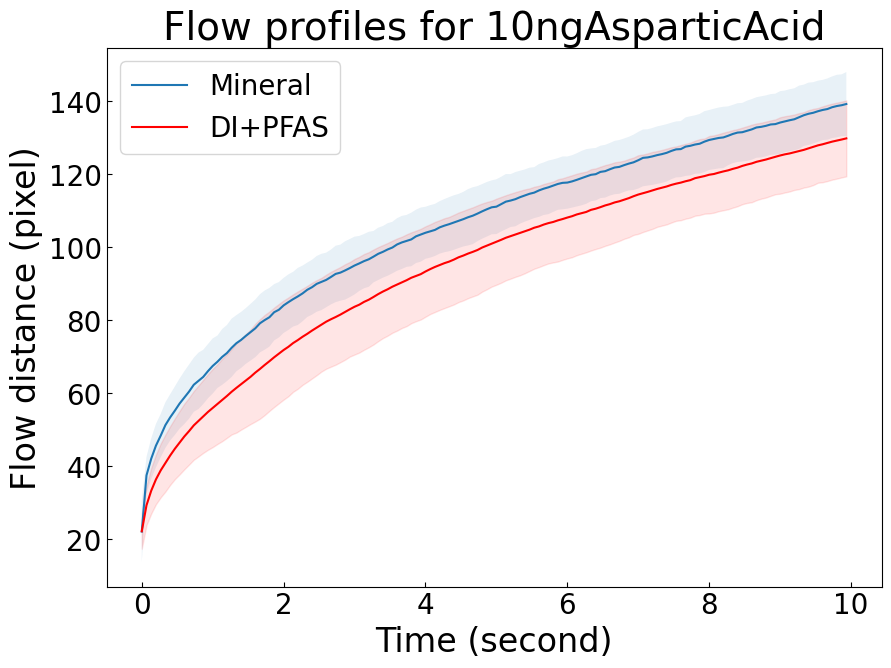

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the target reagent
reagent = '10ngAsparticAcid'
assert reagent in Data['Reagent'].unique(), 'Reagent name not found in the dataset.'

# Define the two categories and their colors
categories = {'Mineral': None, 'DI+PFAS': 'red'}

plt.figure(figsize=(10, 7))  # Set the figure size
plt.title(f'Flow profiles for {reagent}', fontsize=28)

# Iterate through each category to plot the data
for category, color in categories.items():
    # Filter the data for the selected category and reagent
    flows = Data[(Data['Sample'] == category) & (Data['Reagent'] == reagent)]

    # Compute the mean and standard deviation
    df = pd.DataFrame({
        'x': np.arange(150) / 15,  # Convert time points to seconds
        'y': flows.iloc[:, np.r_[0:150]].mean(axis=0),  # Mean
        'y_std': flows.iloc[:, np.r_[0:150]].std(axis=0)  # Standard deviation
    })

    # Plot the line graph and standard deviation
    sns.lineplot(x='x', y='y', data=df, label=category, color=color)
    plt.fill_between(df['x'], df['y'] - df['y_std'], df['y'] + df['y_std'], alpha=0.1, color=color)

# Add labels, title, and legend to the graph
plt.xlabel('Time (second)', fontsize=24)
plt.ylabel('Flow distance (pixel)', fontsize=24)
plt.legend(loc='best', fontsize=20)
plt.tick_params(axis='both', which='major', direction='in', labelsize=20)
plt.show()

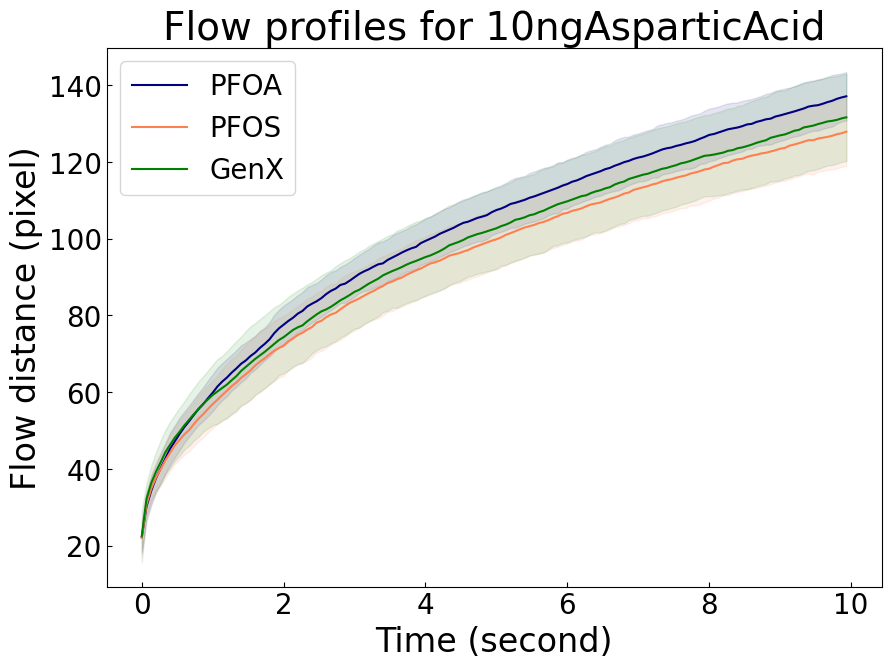

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Unique PFAS types and the specific reagent
PFAS = ['PFOA', 'PFOS', 'GenX']
colors = ['navy', '#FF7F50', 'green']
reagent = '10ngAsparticAcid'
assert reagent in Data['Reagent'].unique(), 'wrong name of reagent'

# Initialize the figure
plt.figure(figsize=(10, 7))  # Adjust figure size if needed
plt.title(f'Flow profiles for {reagent}', fontsize=28)

# Plot flow profiles for each PFAS type
for PFAS_type, color in zip(PFAS, colors):
    flows = pd.DataFrame()  # Initialize flows

    # Combine data for all concentrations of one PFAS type
    for sample in Data['Sample'].unique():
        if sample.endswith(PFAS_type):
            flow = Data[(Data['Sample'] == sample) & (Data['Reagent'] == reagent)]
            flows = pd.concat([flows, flow])

    # Only plot if sufficient data is available
    if flows.shape[1] >= 150:
        # Calculate mean and standard deviation
        df = pd.DataFrame({
            'x': np.arange(150) / 15,  # Generate time values in seconds
            'y': flows.iloc[:, :150].mean(axis=0),
            'y_std': flows.iloc[:, :150].std(axis=0)
        })

        # Create the line plot with standard deviation
        sns.lineplot(x='x', y='y', data=df, label=PFAS_type, color=color)
        plt.fill_between(df['x'], df['y'] - df['y_std'], df['y'] + df['y_std'], color=color, alpha=0.1)
    else:
        print(f"Warning: {PFAS_type} does not have enough data points.")

# Set labels and legend
plt.xlabel('Time (second)', fontsize=24)
plt.ylabel('Flow distance (pixel)', fontsize=24)
plt.legend(loc='best', fontsize=20)
plt.tick_params(axis='both', which='major', direction='in', labelsize=20)
plt.show()

PFAS detection_binary

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def draw_confusion_matrix(cm, labels, title=None):
    """
      draw a confusion matrix showing the pred result, actual labels versus predicted labels
      cm: confusion matrix
      labels: list of labels
    """
    ## Use seaborn to draw confusion matrix
    plt.figure(figsize=(4,4), dpi=300)
    ax = sns.heatmap(cm, annot=True, cmap="YlGn", square='True')
    if title:
        ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');

    ## Ticket labels - List must be in the same order as above (alphabetical order if resorted automatically)
    ax.yaxis.set_ticklabels(labels, fontsize="10")
    ax.xaxis.set_ticklabels(labels, fontsize="10")

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    plt.close()
    #plt.savefig('1.png', transparent=True, bbox_inches='tight')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PFAS_Project/PFAS data analysis/03132025_BW/BW_PFAS_10080.csv')
data = data.drop(columns = ['Unnamed: 0'])
display(data)

# Select data that is not DI
print('Select data that is not DI')
data = data[data['Sample'] != 'DI']
display(data)

data.reset_index(drop = True, inplace = True)

# Split features and labels
X = data.iloc[:, :150]
y = data['Sample']

frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  \
0          22      26      29      32      35      38      40      42      43   
1          18      23      28      31      32      36      39      39      42   
2          20      26      29      33      35      38      39      42      43   
3          21      26      30      33      36      38      41      42      45   
4          22      27      31      34      36      39      41      42      44   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
10075      18      29      34      38      41      45      48      52      53   
10076      20      29      34      37      42      46      49      51      54   
10077      28      34      38      42      46      49      51      53      55   
10078      28      26      27      28      32      32      34      36      37   
10079      21      29      33      32      36      40      41      44      46   

       frame10  ...  frame146  frame147  frame148  frame149  frame150  \
0           45  ...       125       125       125       125       125   
1           44  ...       122       122       122       122       122   
2           46  ...       122       122       124       124       122   
3           46  ...       124       126       126       126       126   
4           46  ...       122       122       122       123       123   
...        ...  ...       ...       ...       ...       ...       ...   
10075       54  ...       133       133       133       133       133   
10076       56  ...       135       135       135       136       136   
10077       57  ...       134       135       135       137       136   
10078       38  ...       105       106       108       107       108   
10079       48  ...       129       129       128       130       130   

        Sample         Reagent  Chip  Channel  lane  
0           BW  100pgMyoglobin     1        1     1  
1           BW  100pgMyoglobin     1        1     2  
2           BW  100pgMyoglobin     1        1     3  
3           BW  100pgMyoglobin     1        1     4  
4           BW  100pgMyoglobin     1        1     5  
...        ...             ...   ...      ...   ...  
10075  1pgGenX          1pgBSA     1        4     1  
10076  1pgGenX          1pgBSA     1        4     2  
10077  1pgGenX          1pgBSA     1        4     3  
10078  1pgGenX          1pgBSA     1        4     4  
10079  1pgGenX          1pgBSA     1        4     5  

[10080 rows x 155 columns]

Select data that is not DI


frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  \
0          22      26      29      32      35      38      40      42      43   
1          18      23      28      31      32      36      39      39      42   
2          20      26      29      33      35      38      39      42      43   
3          21      26      30      33      36      38      41      42      45   
4          22      27      31      34      36      39      41      42      44   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
10075      18      29      34      38      41      45      48      52      53   
10076      20      29      34      37      42      46      49      51      54   
10077      28      34      38      42      46      49      51      53      55   
10078      28      26      27      28      32      32      34      36      37   
10079      21      29      33      32      36      40      41      44      46   

       frame10  ...  frame146  frame147  frame148  frame149  frame150  \
0           45  ...       125       125       125       125       125   
1           44  ...       122       122       122       122       122   
2           46  ...       122       122       124       124       122   
3           46  ...       124       126       126       126       126   
4           46  ...       122       122       122       123       123   
...        ...  ...       ...       ...       ...       ...       ...   
10075       54  ...       133       133       133       133       133   
10076       56  ...       135       135       135       136       136   
10077       57  ...       134       135       135       137       136   
10078       38  ...       105       106       108       107       108   
10079       48  ...       129       129       128       130       130   

        Sample         Reagent  Chip  Channel  lane  
0           BW  100pgMyoglobin     1        1     1  
1           BW  100pgMyoglobin     1        1     2  
2           BW  100pgMyoglobin     1        1     3  
3           BW  100pgMyoglobin     1        1     4  
4           BW  100pgMyoglobin     1        1     5  
...        ...             ...   ...      ...   ...  
10075  1pgGenX          1pgBSA     1        4     1  
10076  1pgGenX          1pgBSA     1        4     2  
10077  1pgGenX          1pgBSA     1        4     3  
10078  1pgGenX          1pgBSA     1        4     4  
10079  1pgGenX          1pgBSA     1        4     5  

[10080 rows x 155 columns]

Level 1 Classification Report (BW vs. PFAS):
              precision    recall  f1-score   support

     Mineral      0.615     0.032     0.060       504
        PFAS      0.755     0.993     0.858      1512

    accuracy                          0.753      2016
   macro avg      0.685     0.513     0.459      2016
weighted avg      0.720     0.753     0.658      2016



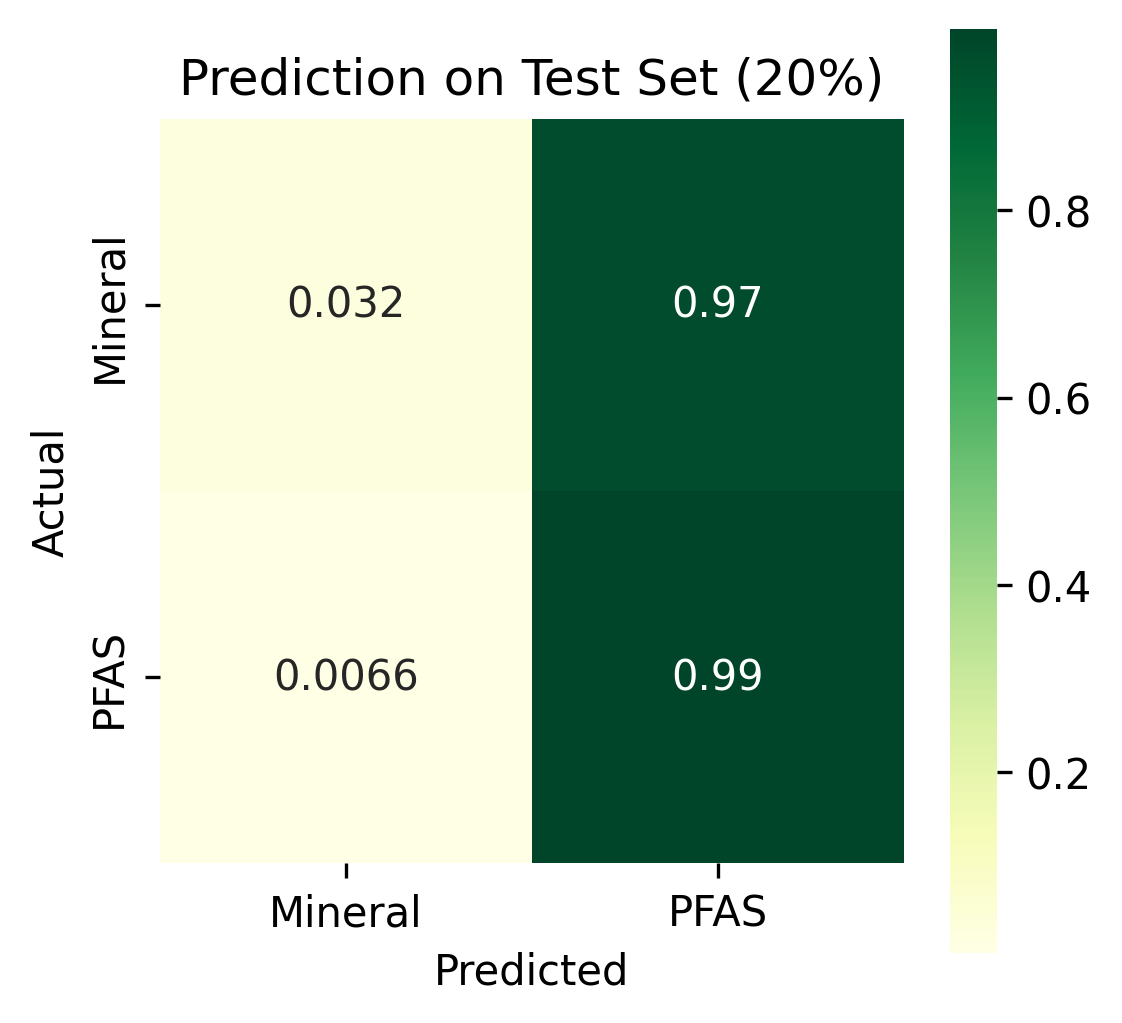

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Standardize the flow profiles (columns from flow_1 to flow_150)
scaler = StandardScaler()
X.iloc[:, :150] = scaler.fit_transform(X.iloc[:, :150])

# Relabel the sample
y_level1 = y.apply(lambda x: 'Mineral' if x == 'BW' else 'PFAS')

# Split dataset for Level 1: DI (Mineral in bottled water) vs. PFAS
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_level1, test_size=test_size,
                                                    random_state=42, stratify=y)

# Train a Random Forest Classifier for Level 1
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Level 1 Classification Report (BW vs. PFAS):")
print(classification_report(y_test, y_pred, digits=3))

#draw a confusion matrix showing the pred result
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
labels = y_level1.unique()
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
draw_confusion_matrix(cm, labels, title='Prediction on Test Set ({:.0%})'.format(test_size))

In [ ]:
data['Sample'].value_counts()

Sample
BW           2520
100agPFOA     840
10fgPFOA      840
1pgPFOA       840
100agPFOS     840
10fgPFOS      840
1pgPFOS       840
100agGenX     840
10fgGenX      840
1pgGenX       840
Name: count, dtype: int64

[('Mineral', 6048), ('PFAS', 6048)]
Level 1 Classification Report (BW vs. PFAS):
              precision    recall  f1-score   support

     Mineral      0.536     0.103     0.173       504
        PFAS      0.764     0.970     0.855      1512

    accuracy                          0.753      2016
   macro avg      0.650     0.537     0.514      2016
weighted avg      0.707     0.753     0.685      2016



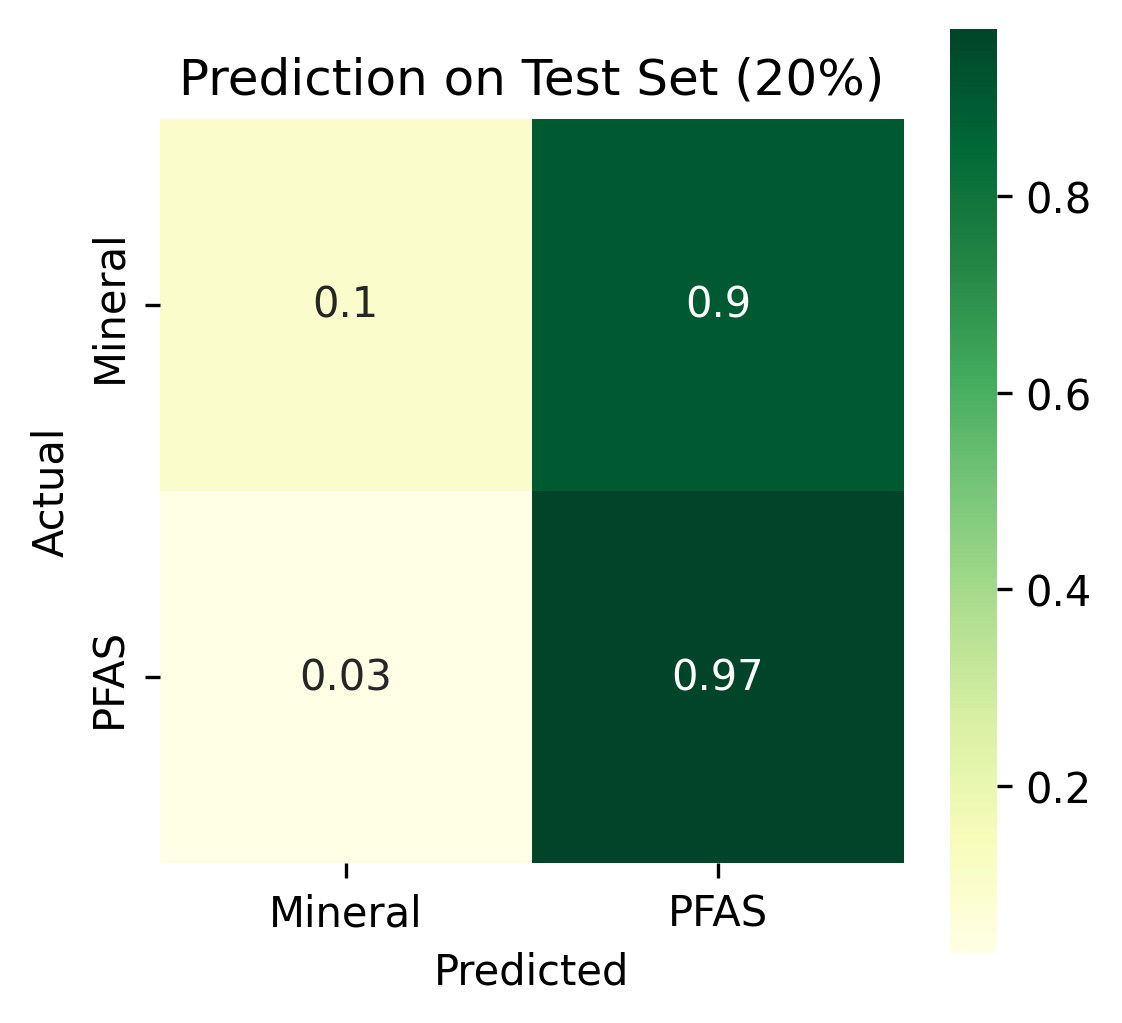

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Standardize the flow profiles (columns from flow_1 to flow_150)
scaler = StandardScaler()
X.iloc[:, :150] = scaler.fit_transform(X.iloc[:, :150])

# Relabel the sample
y_level1 = y.apply(lambda x: 'Mineral' if x == 'BW' else 'PFAS')

# Split dataset for Level 1: DI (Mineral in bottled water) vs. PFAS
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_level1, test_size=test_size,
                                                    random_state=42, stratify=y)

#help(RandomOverSampler)
ros = RandomOverSampler(sampling_strategy = 'minority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

# Train a Random Forest Classifier for Level 1
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)
y_pred = rf_model.predict(X_test)
print("Level 1 Classification Report (BW vs. PFAS):")
print(classification_report(y_test, y_pred, digits=3))

#draw a confusion matrix showing the pred result
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
labels = y_level1.unique()
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
draw_confusion_matrix(cm, labels, title='Prediction on Test Set ({:.0%})'.format(test_size))

Classes are:  ['Mineral', 'PFAS']
1


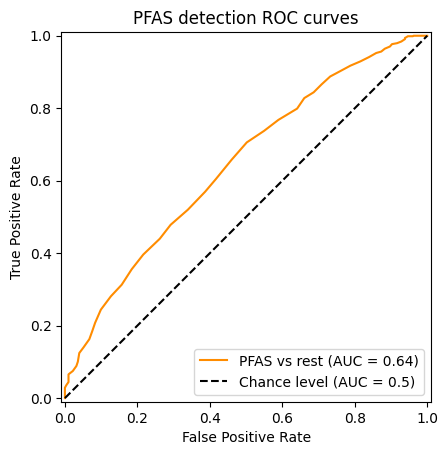

In [ ]:
# ROC curve of PFAS
#Preprocessing the classes info from string to number: encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_le = le.fit_transform(y_test)
labels = list(le.classes_)
print("Classes are: ", labels)
class_of_interest = "PFAS"
class_id = labels.index(class_of_interest)

y_test_probs = rf_model.predict_proba(X_test)

from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots()

print(class_id)
PFASRoc = RocCurveDisplay.from_predictions(
    y_test_le,
    y_test_probs[:, class_id],
    name=f"{class_of_interest} vs rest",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
_ = PFASRoc.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"{class_of_interest} detection ROC curves",
)

In [ ]:
# Train separate model for each reagents

# Show features and labels
display(X)
display(y_level1)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_level1_le = le.fit_transform(y_level1)
labels = list(le.classes_)
print("Classes are: ", labels)
class_of_interest = "PFAS"
class_id = labels.index(class_of_interest)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def CVscores_LeaveOneGroupOut(X, y, class_id, groups):
    """
    Perform cross-validation using LeaveOneGroupOut.
    Args:
      X: Data matrix of shape (n_samples, n_features).
      y: Label vector of shape (n_samples,).
      groups: Group labels for each sample.
    Returns:
      A dictionary containing the results of cross-validation.
    """

    # Calling the LeaveOneGroupOut function from scikit
    logo = LeaveOneGroupOut()
    metrics = {"accuracy": [], "roc_auc": [], "f1_macro": []}
    #results = pd.DataFrame(columns = ['reagent', 'metric', 'train_score', 'test_score'])
    for train_index, test_index in logo.split(X, y, groups=groups): #replace groups with your groups data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # oversample the minority
        ros = RandomOverSampler(sampling_strategy = 'minority', random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)


        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

        # Standardize the flow profiles (columns from flow_1 to flow_150)
        scaler = StandardScaler()
        X_train.iloc[:, :150] = scaler.fit_transform(X_train.iloc[:, :150])

        # Train your model (e.g., rf_model) on the training data
        rf_model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf_model.predict(X_test)
        y_prob = rf_model.predict_proba(X_test)[:, class_id] # Assuming binary classification

        # Calculate metrics
        metrics["accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["roc_auc"].append(roc_auc_score(y_test, y_prob))
        metrics["f1_macro"].append(f1_score(y_test, y_pred, average='macro'))

    mean_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
    print(mean_metrics)
    return mean_metrics, ["accuracy", "roc_auc", "f1_macro"]


reagents = data['Reagent'].unique()

results = pd.DataFrame(columns = ['reagent', 'metric', 'test_score'])

for reagent in reagents:
    print('Reagent: ', reagent)
    # Subset the data for the given reagent
    X_reagent = X[data['Reagent'] == reagent]
    y_reagent = y_level1[data['Reagent'] == reagent]
    display(X_reagent); display(y_reagent)

    # groups are the label for spliting test/train sets
    groups = (data['Chip'][data['Reagent'] == reagent]-1)*4+data['Channel'][data['Reagent'] == reagent]

    # Train a model (e.g., RandomForest) for each reagent
    result = CVscores_LeaveOneGroupOut(X_reagent, y_reagent, class_id, groups)
    for metric in result[1]:
        results.loc[len(results)] = [reagent, metric, result[0][metric]]


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
0     -0.081636 -1.269248 -1.436551 -1.397592 -1.263579 -1.078933 -1.051917   
1     -0.855579 -1.974321 -1.647476 -1.594742 -1.824889 -1.436221 -1.224172   
2     -0.468608 -1.269248 -1.436551 -1.200442 -1.263579 -1.078933 -1.224172   
3     -0.275122 -1.269248 -1.225625 -1.200442 -1.076475 -1.078933 -0.879662   
4     -0.081636 -1.034224 -1.014700 -1.003293 -1.076475 -0.900290 -0.879662   
...         ...       ...       ...       ...       ...       ...       ...   
10075 -0.855579 -0.564175 -0.381925 -0.214694 -0.140959  0.171572  0.326122   
10076 -0.468608 -0.564175 -0.381925 -0.411843  0.046145  0.350216  0.498377   
10077  1.079277  0.610947  0.461775  0.573905  0.794558  0.886147  0.842887   
10078  1.079277 -1.269248 -1.858401 -2.186191 -1.824889 -2.150795 -2.085446   
10079 -0.275122 -0.564175 -0.592850 -1.397592 -1.076475 -0.721646 -0.879662   

         frame8    frame9   frame10  ...  frame141  frame142  frame143  \
0     -0.998109 -1.097640 -1.016542  ... -0.244010 -0.274972 -0.307247   
1     -1.499177 -1.261038 -1.175920  ... -0.454647 -0.485485 -0.517310   
2     -0.998109 -1.097640 -0.857164  ... -0.665285 -0.695998 -0.622341   
3     -0.998109 -0.770843 -0.857164  ... -0.349328 -0.380228 -0.412279   
4     -0.998109 -0.934241 -0.857164  ... -0.665285 -0.801254 -0.832403   
...         ...       ...       ...  ...       ...       ...       ...   
10075  0.672117  0.536346  0.417862  ...  0.493222  0.461823  0.533002   
10076  0.505094  0.699745  0.736618  ...  0.703860  0.672336  0.638033   
10077  0.839139  0.863143  0.895996  ...  0.598541  0.567079  0.743064   
10078 -2.000244 -2.078031 -2.132189  ... -2.245068 -2.274844 -2.302840   
10079 -0.664064 -0.607444 -0.538407  ...  0.071947  0.251310  0.217908   

       frame144  frame145  frame146  frame147  frame148  frame149  frame150  
0     -0.338234 -0.264631 -0.298288 -0.328499 -0.357648 -0.389107 -0.419530  
1     -0.547972 -0.473771 -0.612232 -0.642155 -0.670690 -0.702115 -0.732161  
2     -0.652841 -0.682911 -0.612232 -0.642155 -0.461996 -0.493443 -0.732161  
3     -0.443103 -0.473771 -0.402936 -0.223947 -0.253301 -0.284771 -0.315319  
4     -0.652841 -0.578341 -0.612232 -0.642155 -0.670690 -0.597779 -0.627950  
...         ...       ...       ...       ...       ...       ...       ...  
10075  0.500718  0.571930  0.538895  0.507918  0.477130  0.445581  0.414154  
10076  0.710456  0.781070  0.748191  0.717022  0.685825  0.758589  0.726785  
10077  0.710456  0.676500  0.643543  0.717022  0.685825  0.862925  0.726785  
10078 -2.225876 -2.251463 -2.391246 -2.314989 -2.131553 -2.267155 -2.191106  
10079  0.186111  0.153650  0.120304  0.089709 -0.044606  0.132573  0.101522  

[10080 rows x 150 columns]

0        Mineral
1        Mineral
2        Mineral
3        Mineral
4        Mineral
          ...   
10075       PFAS
10076       PFAS
10077       PFAS
10078       PFAS
10079       PFAS
Name: Sample, Length: 10080, dtype: object

Classes are:  ['Mineral', 'PFAS']
Reagent:  100pgMyoglobin


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
0    -0.081636 -1.269248 -1.436551 -1.397592 -1.263579 -1.078933 -1.051917   
1    -0.855579 -1.974321 -1.647476 -1.594742 -1.824889 -1.436221 -1.224172   
2    -0.468608 -1.269248 -1.436551 -1.200442 -1.263579 -1.078933 -1.224172   
3    -0.275122 -1.269248 -1.225625 -1.200442 -1.076475 -1.078933 -0.879662   
4    -0.081636 -1.034224 -1.014700 -1.003293 -1.076475 -0.900290 -0.879662   
...        ...       ...       ...       ...       ...       ...       ...   
7115 -0.855579 -0.564175 -0.803775 -0.411843 -0.140959 -0.007071 -0.362897   
7116 -0.468608 -0.329151  0.250850  0.376755  0.420351  0.528860  0.326122   
7117 -0.468608 -0.094126  0.250850  0.771055  0.794558  0.707503  0.842887   
7118 -0.275122 -0.094126  0.461775  0.771055  0.607455  0.528860  0.670632   
7119 -0.275122  0.140898  0.039925  0.573905  0.794558  0.707503  0.670632   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
0    -0.998109 -1.097640 -1.016542  ... -0.244010 -0.274972 -0.307247   
1    -1.499177 -1.261038 -1.175920  ... -0.454647 -0.485485 -0.517310   
2    -0.998109 -1.097640 -0.857164  ... -0.665285 -0.695998 -0.622341   
3    -0.998109 -0.770843 -0.857164  ... -0.349328 -0.380228 -0.412279   
4    -0.998109 -0.934241 -0.857164  ... -0.665285 -0.801254 -0.832403   
...        ...       ...       ...  ...       ...       ...       ...   
7115  0.004026 -0.117248  0.258484  ...  1.019817  0.988105  0.848096   
7116  0.505094  0.863143  0.577240  ...  1.125136  1.303874  1.478283   
7117  0.839139  0.863143  0.895996  ...  1.967687  1.935413  1.898408   
7118  0.839139  0.536346  0.577240  ...  1.862368  1.830156  1.793376   
7119  0.672117  0.699745  0.736618  ...  1.651730  1.619643  1.583314   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
0    -0.338234 -0.264631 -0.298288 -0.328499 -0.357648 -0.389107 -0.419530  
1    -0.547972 -0.473771 -0.612232 -0.642155 -0.670690 -0.702115 -0.732161  
2    -0.652841 -0.682911 -0.612232 -0.642155 -0.461996 -0.493443 -0.732161  
3    -0.443103 -0.473771 -0.402936 -0.223947 -0.253301 -0.284771 -0.315319  
4    -0.652841 -0.578341 -0.612232 -0.642155 -0.670690 -0.597779 -0.627950  
...        ...       ...       ...       ...       ...       ...       ...  
7115  0.815325  0.990210  0.957487  1.030678  0.998867  0.967261  1.039416  
7116  1.444539  1.303921  1.585374  1.448887  1.520603  1.593277  1.456258  
7117  1.864015  1.931341  1.899318  1.867095  1.833645  1.801949  1.768889  
7118  1.759146  1.826771  1.794670  1.867095  1.833645  1.906285  1.977310  
7119  1.549408  1.617631  1.690022  1.657991  1.624951  1.593277  1.560468  

[480 rows x 150 columns]

0       Mineral
1       Mineral
2       Mineral
3       Mineral
4       Mineral
         ...   
7115       PFAS
7116       PFAS
7117       PFAS
7118       PFAS
7119       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.7), 'roc_auc': np.float64(0.5897222222222223), 'f1_macro': np.float64(0.5387031930338886)}
Reagent:  10ngMyoglobin


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
40    0.692306 -0.094126  0.039925 -0.017544 -0.140959 -0.185715 -0.018388   
41    0.885792  0.375922  0.250850 -0.017544  0.233248  0.171572  0.326122   
42    1.079277  0.610947  0.250850  0.376755  0.420351  0.350216  0.326122   
43    1.079277  0.375922  0.461775  0.573905  0.420351  0.528860  0.326122   
44    0.885792  0.610947  0.672700  0.573905  0.420351  0.350216  0.326122   
...        ...       ...       ...       ...       ...       ...       ...   
7155  2.240191  2.726166  1.938251  1.756804  1.355868  1.064791  0.670632   
7156  2.240191  2.491142  1.727326  1.559654  0.981662  0.528860  1.015142   
7157  1.853220  2.256117  2.149176  1.559654  1.355868  1.422078  1.359652   
7158  1.659734  1.786069  1.305476  1.559654  1.168765  1.064791  0.842887   
7159  1.853220  1.551044  0.883625  0.968205  0.794558  0.350216  0.498377   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
40    0.171049  0.372948  0.417862  ...  1.441092  1.409131  1.373252   
41    0.171049  0.372948  0.258484  ...  0.914498  0.882849  1.058158   
42    0.338072  0.209549  0.417862  ...  1.125136  1.093361  1.058158   
43    0.338072  0.372948  0.417862  ...  1.019817  0.988105  1.058158   
44    0.338072  0.372948  0.258484  ...  1.019817  0.777592  0.953127   
...        ...       ...       ...  ...       ...       ...       ...   
7155  0.672117  0.536346  0.417862  ... -1.613155 -1.748562 -1.672653   
7156  0.839139  0.863143  1.055375  ... -0.454647 -0.485485 -0.517310   
7157  1.006162  0.863143  1.374131  ...  0.177266  0.146054  0.217908   
7158  1.173184  1.189940  1.055375  ...  0.598541  0.461823  0.427971   
7159  0.672117  0.536346  1.055375  ...  1.125136  1.093361  1.268220   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
40    1.339670  1.303921  1.166783  1.239783  1.207561  1.280269  1.247837  
41    1.025063  1.094781  0.957487  0.926126  0.998867  1.071597  1.039416  
42    1.129932  1.094781  1.166783  1.135231  1.207561  1.175933  1.039416  
43    0.920194  0.885640  1.062135  1.030678  0.998867  0.967261  0.935206  
44    1.234801  1.199351  1.166783  1.135231  1.103214  1.071597  1.039416  
...        ...       ...       ...       ...       ...       ...       ...  
7155 -1.596662 -1.519472 -1.449415 -1.478572 -1.714164 -1.641139 -1.670054  
7156 -0.443103 -0.264631 -0.193640 -0.433051 -0.461996 -0.493443 -0.523740  
7157  0.290980  0.362790  0.329599  0.403366  0.372783  0.341245  0.414154  
7158  0.500718  0.258220  0.224951  0.194262  0.268436  0.445581  0.309943  
7159  1.339670  1.199351  1.166783  1.135231  1.103214  1.071597  1.039416  

[480 rows x 150 columns]

40      Mineral
41      Mineral
42      Mineral
43      Mineral
44      Mineral
         ...   
7155       PFAS
7156       PFAS
7157       PFAS
7158       PFAS
7159       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6375), 'roc_auc': np.float64(0.5302314814814815), 'f1_macro': np.float64(0.5177381048214604)}
Reagent:  1pgMyoglobin


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
80    0.885792  1.080995  0.883625  0.771055  0.420351  0.171572  0.326122   
81    1.079277  1.551044  0.883625  0.771055  0.794558  0.707503  0.670632   
82    0.885792  1.551044  1.094551  0.771055  0.794558  0.707503  0.670632   
83    1.466249  1.551044  1.094551  0.968205  0.607455  0.350216  0.670632   
84    1.466249  1.551044  1.094551  0.968205  0.981662  0.886147  0.842887   
...        ...       ...       ...       ...       ...       ...       ...   
7195 -2.016493  0.610947 -1.014700  0.179606 -0.702269 -0.364359 -1.224172   
7196 -2.209978  0.375922  0.250850 -0.214694 -0.140959 -0.007071 -0.190642   
7197 -2.209978  0.140898 -0.381925 -0.411843 -0.140959 -0.007071  0.153867   
7198 -2.209978  0.375922 -0.171000 -0.017544  0.046145 -0.007071 -0.018388   
7199 -1.823007 -0.094126  0.039925 -0.017544 -0.328062 -0.007071 -0.018388   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
80    0.338072 -0.117248  0.099105  ...  1.125136  1.198618  1.058158   
81    0.505094  0.372948  0.417862  ...  1.335773  1.303874  1.373252   
82    0.505094  0.372948  0.417862  ...  1.546411  1.514387  1.478283   
83    0.672117  0.699745  0.736618  ...  1.441092  1.409131  1.373252   
84    0.672117  0.699745  0.577240  ...  0.914498  0.777592  0.848096   
...        ...       ...       ...  ...       ...       ...       ...   
7195 -1.499177 -2.078031 -1.972811  ... -1.191879 -1.222280 -1.252528   
7196  0.171049 -0.280647 -0.060273  ... -0.665285 -0.801254 -0.727372   
7197 -0.330019 -0.280647 -0.219651  ... -0.454647 -0.485485 -0.622341   
7198  0.004026 -0.117248  0.099105  ...  0.493222  0.461823  0.533002   
7199  0.004026  0.046150 -0.060273  ...  0.598541  0.461823  0.743064   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
80    1.129932  1.303921  1.271431  1.344335  1.311909  1.280269  1.352047  
81    1.234801  1.303921  1.271431  1.344335  1.311909  1.384605  1.352047  
82    1.444539  1.408491  1.376078  1.553439  1.520603  1.593277  1.560468  
83    1.339670  1.303921  1.376078  1.344335  1.416256  1.488941  1.456258  
84    0.815325  0.990210  1.062135  1.135231  1.103214  0.862925  0.935206  
...        ...       ...       ...       ...       ...       ...       ...  
7195 -0.967448 -0.996622 -1.135471 -1.060364 -1.088080 -1.119459 -1.149002  
7196 -0.652841 -0.682911 -0.612232 -0.433051 -0.566343 -0.597779 -0.627950  
7197 -0.757710 -0.787481 -0.716880 -0.537603 -0.566343 -0.597779 -0.523740  
7198  0.500718  0.571930  0.538895  0.403366  0.685825  0.549917  0.622574  
7199  0.605587  0.571930  0.538895  0.612470  0.581478  0.549917  0.518364  

[480 rows x 150 columns]

80      Mineral
81      Mineral
82      Mineral
83      Mineral
84      Mineral
         ...   
7195       PFAS
7196       PFAS
7197       PFAS
7198       PFAS
7199       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.64375), 'roc_auc': np.float64(0.5246759259259259), 'f1_macro': np.float64(0.5021278503461301)}
Reagent:  100pgAsparticAcid


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
480  -0.081636 -1.504272 -1.858401 -1.989041 -2.199096 -2.150795 -1.913191   
481  -0.662093 -1.974321 -2.280251 -2.186191 -2.386199 -2.329439 -2.257701   
482  -0.275122 -1.974321 -2.280251 -1.989041 -2.199096 -2.329439 -2.257701   
483  -0.468608 -1.974321 -2.069326 -2.186191 -2.386199 -2.150795 -2.085446   
484  -0.468608 -1.974321 -2.069326 -2.186191 -2.199096 -2.150795 -2.257701   
...        ...       ...       ...       ...       ...       ...       ...   
7595  0.692306  0.375922  0.250850 -0.017544  0.607455  0.707503  0.153867   
7596 -0.468608 -1.739297 -2.280251 -2.580491 -2.011992 -1.614864 -1.568681   
7597 -0.275122 -1.504272 -1.858401 -1.594742 -1.637786 -1.257577 -0.707407   
7598  0.305335 -1.504272 -1.647476 -1.397592 -1.263579 -1.257577 -0.707407   
7599  0.885792 -0.329151 -0.381925 -0.608993  0.046145 -0.185715 -0.362897   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
480  -2.000244 -1.914633 -2.132189  ... -0.138691 -0.064459 -0.097185   
481  -2.167267 -2.241430 -2.132189  ...  0.282585  0.356567  0.322940   
482  -2.167267 -2.241430 -2.132189  ...  0.598541  0.567079  0.322940   
483  -2.167267 -2.078031 -2.132189  ... -0.454647 -0.485485 -0.202216   
484  -2.334290 -2.241430 -2.291567  ... -1.507836 -1.432792 -0.727372   
...        ...       ...       ...  ...       ...       ...       ...   
7595  0.338072  0.209549 -0.060273  ... -2.034430 -2.064331 -1.777684   
7596 -1.332154 -1.424437 -1.813433  ... -1.402517 -1.432792 -1.567622   
7597 -0.664064 -1.261038 -1.175920  ... -0.981242 -1.011767 -1.252528   
7598 -1.332154 -1.097640 -1.016542  ... -0.981242 -1.327536 -1.147497   
7599 -0.998109 -0.607444 -0.857164  ... -0.454647 -0.274972 -0.412279   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
480  -0.128496 -0.160061  0.015656 -0.014843  0.059741  0.028237 -0.002688  
481   0.395849  0.049079  0.015656  0.089709  0.059741  0.132573  0.205733  
482   0.500718  0.571930  0.329599  0.403366  0.372783  0.341245 -0.002688  
483  -0.443103 -0.369201 -0.402936 -0.433051 -0.670690 -0.597779 -0.627950  
484  -0.967448 -0.787481 -0.821528 -0.851260 -0.879385 -0.806451 -0.836371  
...        ...       ...       ...       ...       ...       ...       ...  
7595 -1.806400 -1.728612 -1.658711 -1.687676 -1.714164 -1.745475 -1.982686  
7596 -1.596662 -1.519472 -1.658711 -1.687676 -1.609816 -1.954147 -1.878475  
7597 -1.177186 -1.205762 -1.135471 -1.164916 -1.088080 -1.119459 -1.253213  
7598 -1.072317 -1.310332 -1.240119 -0.851260 -0.775038 -0.806451 -0.836371  
7599 -0.443103 -0.369201 -0.298288 -0.328499 -0.357648 -0.389107 -0.523740  

[480 rows x 150 columns]

480     Mineral
481     Mineral
482     Mineral
483     Mineral
484     Mineral
         ...   
7595       PFAS
7596       PFAS
7597       PFAS
7598       PFAS
7599       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6291666666666667), 'roc_auc': np.float64(0.562962962962963), 'f1_macro': np.float64(0.514913344913345)}
Reagent:  10ngAsparticAcid


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
520   0.498821 -0.094126 -0.171000 -0.411843 -0.515165 -0.543002 -0.362897   
521   0.498821  0.140898 -0.171000 -0.214694 -0.328062 -0.364359 -0.535152   
522   0.498821 -0.094126 -0.171000 -0.214694 -0.328062 -0.364359 -0.535152   
523  -1.242550 -1.269248 -1.014700 -1.003293 -0.889372 -1.078933 -1.051917   
524   0.498821 -0.564175 -0.381925 -0.411843 -0.515165 -0.543002 -0.707407   
...        ...       ...       ...       ...       ...       ...       ...   
7635 -1.049065 -0.564175  0.039925  0.573905  0.794558  0.886147  0.842887   
7636 -0.855579 -0.329151 -0.171000  0.179606  0.607455  0.528860  1.015142   
7637 -1.242550 -0.564175 -0.171000 -0.017544  0.420351  0.528860  0.498377   
7638 -1.049065 -0.564175 -0.171000  0.179606  0.233248  0.171572  0.498377   
7639 -1.436036 -0.799199 -0.592850 -0.017544  0.046145  0.171572 -0.018388   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
520  -0.497041 -0.607444 -0.697786  ... -0.559966 -0.590741 -0.517310   
521  -0.497041 -0.934241 -0.857164  ... -0.559966 -0.485485 -0.517310   
522  -0.664064 -0.934241 -0.697786  ...  0.177266  0.251310  0.217908   
523  -1.165132 -1.424437 -1.494677  ... -0.033372  0.040797  0.007846   
524  -0.831086 -0.607444 -0.697786  ...  1.019817  0.988105  0.953127   
...        ...       ...       ...  ...       ...       ...       ...   
7635  0.672117  0.536346  0.099105  ... -0.981242 -1.117023 -0.937435   
7636 -0.162996  0.536346 -0.060273  ... -1.507836 -1.432792 -1.462591   
7637  0.004026 -0.444045 -0.538407  ... -1.086560 -1.117023 -1.042466   
7638  0.171049 -0.934241 -0.857164  ... -1.191879 -1.222280 -1.252528   
7639 -0.162996 -0.117248  0.099105  ... -1.297198 -1.327536 -1.357559   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
520  -0.652841 -0.264631 -0.716880 -0.433051 -0.357648 -0.597779 -0.419530  
521  -0.547972 -0.578341 -0.193640 -0.119395 -0.148954 -0.284771 -0.523740  
522  -0.023627  0.362790  0.329599 -0.014843  0.268436  0.236909  0.101522  
523  -0.023627 -0.055491 -0.298288 -0.119395 -0.148954 -0.076099 -0.315319  
524   0.920194  0.676500  0.852839  0.821574  0.998867  1.071597  0.935206  
...        ...       ...       ...       ...       ...       ...       ...  
7635 -0.967448 -0.682911 -0.821528 -0.851260 -0.775038 -0.910787 -0.836371  
7636 -1.177186 -1.101192 -1.030823 -1.164916 -0.879385 -0.910787 -1.149002  
7637 -1.072317 -0.892051 -0.926175 -0.955812 -1.088080 -1.328131 -1.149002  
7638 -1.177186 -1.310332 -1.240119 -1.269468 -1.192427 -1.223795 -1.253213  
7639 -1.177186 -1.205762 -1.240119 -1.164916 -1.192427 -1.119459 -1.044792  

[480 rows x 150 columns]

520     Mineral
521     Mineral
522     Mineral
523     Mineral
524     Mineral
         ...   
7635       PFAS
7636       PFAS
7637       PFAS
7638       PFAS
7639       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.7), 'roc_auc': np.float64(0.6273611111111111), 'f1_macro': np.float64(0.5450747383678961)}
Reagent:  1pgAsparticAcid


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
560  -0.855579 -1.974321 -1.858401 -1.791892 -1.824889 -1.614864 -1.396427   
561  -0.855579 -1.739297 -1.858401 -1.397592 -1.450682 -1.257577 -1.224172   
562  -0.662093 -1.739297 -1.647476 -1.791892 -1.450682 -1.436221 -1.396427   
563  -0.662093 -1.739297 -1.647476 -1.594742 -1.450682 -1.436221 -1.396427   
564  -0.468608 -1.739297 -2.069326 -1.594742 -1.824889 -1.436221 -1.568681   
...        ...       ...       ...       ...       ...       ...       ...   
7675  0.111849 -2.209346 -2.491176 -1.989041 -2.386199 -2.329439 -2.602211   
7676 -0.275122 -1.974321 -1.858401 -1.791892 -1.637786 -1.257577 -1.051917   
7677 -0.468608 -1.974321 -1.647476 -1.397592 -1.263579 -1.436221 -1.396427   
7678 -0.468608 -1.739297 -1.436551 -1.594742 -1.263579 -1.257577 -1.568681   
7679 -0.275122 -2.209346 -2.069326 -1.791892 -1.450682 -1.614864 -1.568681   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
560  -1.499177 -1.261038 -1.175920  ...  1.125136  1.198618  1.163189   
561  -1.165132 -1.097640 -1.175920  ...  0.703860  0.672336  0.638033   
562  -1.332154 -1.261038 -1.016542  ...  0.493222  0.461823  0.427971   
563  -1.332154 -1.261038 -1.175920  ...  0.598541  0.777592  0.743064   
564  -1.332154 -1.261038 -1.175920  ...  0.177266  0.461823  0.427971   
...        ...       ...       ...  ...       ...       ...       ...   
7675 -2.668335 -2.895024 -3.247837  ... -2.350387 -2.169587 -2.197809   
7676 -1.165132 -1.424437 -1.494677  ... -1.929111 -1.853818 -1.882715   
7677 -1.499177 -1.097640 -1.335298  ... -1.613155 -1.748562 -1.672653   
7678 -1.332154 -1.424437 -1.016542  ... -1.718474 -1.748562 -1.882715   
7679 -1.499177 -1.424437 -1.335298  ... -1.718474 -1.853818 -1.882715   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
560   1.234801  1.094781  1.062135  1.030678  1.103214  1.071597  1.039416  
561   0.710456  0.571930  0.538895  0.612470  0.581478  0.549917  0.622574  
562   0.395849  0.467360  0.434247  0.403366  0.372783  0.341245  0.309943  
563   0.710456  0.885640  0.957487  0.821574  0.790172  0.967261  0.935206  
564   0.500718  0.571930  0.538895  0.507918  0.477130  0.445581  0.414154  
...        ...       ...       ...       ...       ...       ...       ...  
7675 -2.330745 -2.460603 -2.181950 -2.314989 -2.131553 -2.058483 -2.086896  
7676 -1.911269 -1.937753 -1.868007 -2.001333 -1.922858 -1.849811 -1.878475  
7677 -1.596662 -1.624042 -1.554063 -1.687676 -1.505469 -1.745475 -1.774265  
7678 -1.911269 -1.937753 -2.077302 -1.896781 -1.922858 -1.954147 -1.878475  
7679 -1.596662 -1.833182 -1.868007 -1.896781 -1.922858 -1.954147 -1.670054  

[480 rows x 150 columns]

560     Mineral
561     Mineral
562     Mineral
563     Mineral
564     Mineral
         ...   
7675       PFAS
7676       PFAS
7677       PFAS
7678       PFAS
7679       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6395833333333333), 'roc_auc': np.float64(0.5825), 'f1_macro': np.float64(0.5299701199857202)}
Reagent:  1pgGlutamine


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
960  -0.662093 -0.564175 -0.381925 -0.608993 -0.702269 -0.721646 -0.535152   
961  -0.468608 -0.329151 -0.171000 -0.214694 -0.328062 -0.543002 -0.362897   
962   0.111849 -0.329151  0.039925 -0.214694 -0.140959 -0.364359 -0.362897   
963   0.305335 -0.094126  0.039925 -0.214694 -0.140959 -0.185715 -0.190642   
964   0.498821  0.140898  0.039925 -0.017544 -0.140959 -0.007071 -0.018388   
...        ...       ...       ...       ...       ...       ...       ...   
8155 -1.436036 -1.034224 -0.803775 -0.411843 -0.515165 -0.543002 -0.362897   
8156 -0.081636 -0.564175 -0.592850 -1.200442 -1.450682 -1.257577 -1.396427   
8157 -0.275122 -0.564175 -0.381925 -0.608993 -0.702269 -0.721646 -0.707407   
8158  0.111849 -0.799199 -0.592850 -1.200442 -0.889372 -0.900290 -1.051917   
8159  0.111849 -0.799199 -1.014700 -1.003293 -1.076475 -1.078933 -0.707407   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
960  -0.497041 -0.444045 -0.379029  ...  0.177266  0.146054  0.112877   
961  -0.497041 -0.444045 -0.379029  ...  0.177266  0.251310  0.217908   
962  -0.330019 -0.280647 -0.219651  ...  0.387904  0.461823  0.533002   
963  -0.162996  0.046150 -0.060273  ...  0.598541  0.567079  0.533002   
964  -0.162996 -0.117248 -0.060273  ...  0.387904  0.461823  0.427971   
...        ...       ...       ...  ...       ...       ...       ...   
8155 -0.330019 -0.117248 -0.060273  ...  0.071947 -0.064459 -0.097185   
8156 -0.998109 -1.261038 -1.175920  ...  0.703860  0.672336  0.638033   
8157 -0.664064 -0.607444 -0.538407  ... -1.507836 -1.538049 -1.567622   
8158 -0.831086 -0.934241 -0.538407  ... -0.454647 -0.485485 -0.622341   
8159 -1.165132 -0.934241 -0.697786  ... -0.559966 -0.485485 -0.622341   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
960   0.081242  0.153650  0.120304  0.089709  0.164088  0.132573  0.101522  
961   0.290980  0.153650  0.120304  0.194262  0.268436  0.132573  0.101522  
962   0.500718  0.467360  0.538895  0.507918  0.477130  0.445581  0.518364  
963   0.605587  0.676500  0.643543  0.612470  0.581478  0.654253  0.622574  
964   0.500718  0.467360  0.434247  0.403366  0.477130  0.549917  0.309943  
...        ...       ...       ...       ...       ...       ...       ...  
8155 -0.023627 -0.055491 -0.088992 -0.014843  0.059741  0.028237 -0.106898  
8156  0.605587  0.571930  0.538895  0.507918  0.477130  0.654253  0.622574  
8157 -1.596662 -1.624042 -1.449415 -1.478572 -1.505469 -1.432467 -1.461634  
8158 -0.443103 -0.473771 -0.612232 -0.328499 -0.461996 -0.493443 -0.523740  
8159 -0.547972 -0.578341 -0.716880 -0.537603 -0.670690 -0.493443 -0.523740  

[480 rows x 150 columns]

960     PFAS
961     PFAS
962     PFAS
963     PFAS
964     PFAS
        ... 
8155    PFAS
8156    PFAS
8157    PFAS
8158    PFAS
8159    PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6583333333333334), 'roc_auc': np.float64(0.5785185185185184), 'f1_macro': np.float64(0.5221516769914916)}
Reagent:  100pgGlutamine


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
980   1.466249  0.610947  0.461775  0.771055  0.794558  0.707503  0.670632   
981   1.659734  0.845971  0.672700  0.573905  0.607455  0.707503  0.498377   
982   1.466249  0.845971  0.672700  0.573905  0.607455  0.528860  0.670632   
983   1.466249  0.845971  0.672700  0.573905  0.607455  0.528860  0.498377   
984   1.466249  0.845971  0.672700  0.573905  0.607455  0.528860  0.498377   
...        ...       ...       ...       ...       ...       ...       ...   
8075  1.079277  0.845971  0.883625  0.573905  0.607455  0.528860  0.498377   
8076  0.885792  0.845971  0.672700  0.573905  0.420351  0.528860  0.670632   
8077  1.272763  0.845971  0.672700  0.573905  0.607455  0.707503  0.842887   
8078  1.466249  0.845971  0.883625  0.771055  0.607455  0.528860  0.498377   
8079  1.466249  0.845971  0.461775  0.771055  0.794558  0.707503  0.498377   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
980   0.505094  0.536346  0.577240  ... -0.138691 -0.169716  0.007846   
981   0.505094  0.372948  0.258484  ...  0.177266  0.146054  0.217908   
982   0.505094  0.536346  0.577240  ... -0.349328 -0.274972 -0.307247   
983   0.338072  0.372948  0.577240  ... -0.349328 -0.380228 -0.412279   
984   0.505094  0.536346  0.417862  ...  0.071947  0.146054  0.112877   
...        ...       ...       ...  ...       ...       ...       ...   
8075  0.672117  0.536346  0.417862  ...  0.282585  0.356567  0.217908   
8076  0.672117  0.699745  0.577240  ...  0.598541  0.567079  0.638033   
8077  0.672117  0.699745  0.736618  ...  0.177266  0.146054  0.217908   
8078  0.338072  0.536346  0.577240  ... -1.297198 -1.327536 -1.357559   
8079  0.672117  0.699745  0.577240  ...  0.071947  0.040797  0.007846   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
980  -0.338234 -0.160061 -0.193640 -0.223947 -0.253301 -0.284771 -0.106898  
981   0.186111  0.153650  0.224951  0.089709  0.164088 -0.076099  0.101522  
982  -0.233365 -0.264631 -0.088992 -0.223947 -0.253301 -0.389107 -0.211109  
983  -0.338234 -0.473771 -0.402936 -0.433051 -0.357648 -0.389107 -0.211109  
984   0.186111  0.153650  0.120304  0.089709  0.164088  0.132573 -0.002688  
...        ...       ...       ...       ...       ...       ...       ...  
8075  0.186111  0.362790  0.329599  0.298814  0.268436  0.341245  0.309943  
8076  0.710456  0.676500  0.538895  0.612470  0.685825  0.549917  0.622574  
8077  0.290980  0.258220  0.434247  0.403366  0.268436  0.445581  0.414154  
8078 -1.386924 -1.414902 -1.135471 -1.164916 -1.192427 -1.223795 -1.149002  
8079 -0.023627 -0.055491  0.015656 -0.014843  0.268436  0.132573  0.205733  

[480 rows x 150 columns]

980     Mineral
981     Mineral
982     Mineral
983     Mineral
984     Mineral
         ...   
8075       PFAS
8076       PFAS
8077       PFAS
8078       PFAS
8079       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.675), 'roc_auc': np.float64(0.5110185185185185), 'f1_macro': np.float64(0.48006845437177037)}
Reagent:  10ngGlutamine


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
1020 -0.468608  0.845971  1.516401  1.165354  1.542972  1.600722  1.704161   
1021  0.111849  0.845971  1.305476  1.362504  1.355868  1.600722  1.704161   
1022  0.305335  0.845971  1.938251  1.559654  1.542972  1.600722  1.704161   
1023  0.498821  1.316020  1.305476  1.362504  1.730075  1.779365  1.531906   
1024  0.692306  1.551044  1.727326  1.559654  1.542972  1.422078  1.531906   
...        ...       ...       ...       ...       ...       ...       ...   
8115  0.305335  1.080995  0.883625  0.771055  0.607455  0.528860  0.498377   
8116  0.692306  1.080995  1.094551  0.771055  0.794558  0.707503  0.498377   
8117  0.885792  1.080995  1.094551 -1.200442 -1.637786 -1.614864 -2.085446   
8118  0.692306  0.610947  1.094551  0.376755  0.233248 -0.007071  0.153867   
8119  0.692306  0.610947  0.883625  0.179606  0.233248  0.171572  0.153867   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
1020  1.841275  2.006933  1.852266  ...  2.178324  2.145925  2.108470   
1021  1.674252  1.680136  1.692887  ...  2.178324  2.145925  2.213501   
1022  1.841275  1.680136  1.852266  ...  1.862368  1.830156  1.793376   
1023  1.674252  1.680136  1.852266  ...  2.073005  2.145925  2.213501   
1024  1.674252  1.516738  1.692887  ...  2.178324  2.356438  2.318532   
...        ...       ...       ...  ...       ...       ...       ...   
8115  0.171049  0.209549  0.258484  ...  0.598541  0.567079  0.533002   
8116  0.672117  0.699745 -0.219651  ...  0.493222  0.461823  0.322940   
8117 -2.000244 -1.914633 -1.335298  ... -0.770604 -0.801254 -0.832403   
8118  0.171049  0.046150  0.258484  ... -0.244010 -0.169716 -0.307247   
8119  0.004026  0.046150  0.099105  ... -0.244010 -0.274972 -0.097185   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
1020  2.073753  2.140482  2.108614  2.076200  2.042340  2.114957  1.873099  
1021  2.178622  2.140482  2.108614  2.180752  2.251035  2.010621  2.081520  
1022  1.759146  2.140482  2.108614  2.076200  2.146687  2.010621  1.977310  
1023  2.178622  2.035912  2.003966  2.076200  2.042340  2.114957  1.977310  
1024  2.283491  2.140482  2.108614  2.076200  2.042340  2.219293  2.081520  
...        ...       ...       ...       ...       ...       ...       ...  
8115  0.710456  0.676500  0.748191  0.717022  0.685825  0.654253  0.622574  
8116  0.186111  0.153650  0.224951  0.194262  0.164088  0.132573  0.101522  
8117 -0.757710 -0.787481 -0.821528 -0.851260 -0.775038 -0.806451 -0.836371  
8118 -0.233365 -0.264631 -0.298288 -0.328499 -0.253301 -0.180435 -0.211109  
8119 -0.023627 -0.055491 -0.088992 -0.119395  0.059741  0.028237 -0.002688  

[480 rows x 150 columns]

1020    Mineral
1021    Mineral
1022    Mineral
1023    Mineral
1024    Mineral
         ...   
8115       PFAS
8116       PFAS
8117       PFAS
8118       PFAS
8119       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6583333333333333), 'roc_auc': np.float64(0.5244907407407408), 'f1_macro': np.float64(0.4851807071438832)}
Reagent:  100pgGlycine


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
1440 -0.275122 -0.564175 -0.171000 -0.017544  0.046145  0.171572  0.153867   
1441  0.111849 -0.329151  0.039925  0.376755  0.233248  0.350216  0.498377   
1442  0.498821  0.140898  0.250850  0.376755  0.420351  0.528860  0.326122   
1443  0.498821  0.375922  0.461775  0.573905  0.607455  0.528860  0.498377   
1444  0.498821  0.610947  0.672700  0.573905  0.607455  0.707503  0.670632   
...        ...       ...       ...       ...       ...       ...       ...   
8555  0.305335 -0.094126 -0.381925 -0.411843 -0.515165 -0.543002 -0.535152   
8556  0.305335 -0.094126 -0.381925 -0.411843 -0.328062 -0.364359 -0.362897   
8557  0.498821  0.140898 -0.171000 -0.214694 -0.140959 -0.364359 -0.190642   
8558 -0.275122  0.375922  0.039925 -0.017544 -0.140959 -0.185715 -1.568681   
8559 -0.081636 -1.269248 -1.436551 -1.791892 -2.199096 -2.686726 -2.946720   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
1440  0.171049  0.209549  0.258484  ...  0.493222  0.461823  0.427971   
1441  0.338072  0.209549  0.258484  ...  0.493222  0.461823  0.427971   
1442  0.338072  0.372948  0.417862  ...  0.387904  0.356567  0.322940   
1443  0.505094  0.372948  0.417862  ...  0.387904  0.356567  0.322940   
1444  0.672117  0.536346  0.577240  ...  0.282585  0.251310  0.217908   
...        ...       ...       ...  ...       ...       ...       ...   
8555 -0.497041 -0.444045 -0.379029  ... -0.349328 -0.380228 -0.412279   
8556 -0.330019 -0.280647 -0.379029  ... -0.875923 -0.906510 -0.937435   
8557 -0.162996 -0.117248 -0.219651  ... -1.613155 -1.643305 -1.567622   
8558 -1.833222 -2.078031 -1.972811  ... -1.402517 -1.432792 -1.357559   
8559 -2.668335 -2.078031 -1.813433  ... -1.086560 -1.117023 -1.042466   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
1440  0.500718  0.467360  0.434247  0.403366  0.477130  0.445581  0.414154  
1441  0.395849  0.467360  0.434247  0.403366  0.372783  0.341245  0.309943  
1442  0.290980  0.258220  0.329599  0.298814  0.268436  0.236909  0.205733  
1443  0.290980  0.258220  0.224951  0.298814  0.268436  0.341245  0.309943  
1444  0.290980  0.258220  0.224951  0.194262  0.268436  0.236909  0.309943  
...        ...       ...       ...       ...       ...       ...       ...  
8555 -0.338234 -0.369201 -0.298288 -0.328499 -0.357648 -0.389107 -0.419530  
8556 -0.862579 -0.892051 -0.926175 -0.955812 -0.983732 -0.910787 -0.940582  
8557 -1.596662 -1.624042 -1.658711 -1.687676 -1.714164 -1.641139 -1.670054  
8558 -1.386924 -1.414902 -1.449415 -1.583124 -1.505469 -1.432467 -1.461634  
8559 -1.072317 -1.101192 -1.135471 -1.060364 -1.088080 -1.119459 -1.149002  

[480 rows x 150 columns]

1440    Mineral
1441    Mineral
1442    Mineral
1443    Mineral
1444    Mineral
         ...   
8555       PFAS
8556       PFAS
8557       PFAS
8558       PFAS
8559       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.5854166666666667), 'roc_auc': np.float64(0.5154166666666666), 'f1_macro': np.float64(0.4395392863063168)}
Reagent:  10ngGlycine


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
1480  1.466249  0.845971  0.672700  0.771055  0.607455  0.707503  0.842887   
1481  1.466249  1.316020  0.883625  1.165354  1.168765  0.886147  0.842887   
1482 -2.596950  0.140898  0.250850  0.573905  0.607455  0.707503  0.670632   
1483 -2.209978  0.140898  0.672700  0.573905  0.607455  0.528860  0.670632   
1484 -2.016493  0.610947  0.883625  0.771055  0.794558  0.707503  0.842887   
...        ...       ...       ...       ...       ...       ...       ...   
8595 -0.081636  0.375922  0.672700  0.771055  0.794558  0.707503  0.670632   
8596 -0.855579  0.375922  0.883625  0.771055  0.046145 -0.543002 -0.707407   
8597 -0.081636 -1.504272 -0.592850 -1.003293 -0.889372 -0.900290 -0.879662   
8598 -0.081636 -0.799199 -0.592850 -0.411843 -0.515165 -0.364359 -0.362897   
8599 -0.081636 -0.564175 -0.381925 -0.214694 -0.140959 -0.364359 -0.362897   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
1480  0.672117  0.863143  0.577240  ...  0.387904  0.461823  0.427971   
1481  0.839139  0.863143  0.736618  ...  0.387904  0.461823  0.427971   
1482  0.672117  0.699745  0.736618  ...  0.493222  0.567079  0.533002   
1483  0.672117  0.699745  0.736618  ...  0.387904  0.461823  0.427971   
1484  0.839139  0.699745  0.736618  ...  0.387904  0.356567  0.322940   
...        ...       ...       ...  ...       ...       ...       ...   
8595  0.672117  0.699745  0.736618  ... -0.559966 -0.590741 -0.622341   
8596 -0.998109 -1.261038 -1.494677  ... -1.402517 -1.327536 -1.357559   
8597 -0.831086 -0.607444 -0.697786  ... -0.770604 -0.695998 -0.727372   
8598 -0.330019 -0.280647 -0.379029  ... -0.454647 -0.485485 -0.412279   
8599 -0.162996 -0.280647 -0.379029  ... -0.454647 -0.380228 -0.517310   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
1480  0.500718  0.467360  0.434247  0.403366  0.477130  0.445581  0.414154  
1481  0.395849  0.467360  0.538895  0.507918  0.581478  0.549917  0.518364  
1482  0.500718  0.467360  0.434247  0.507918  0.477130  0.445581  0.414154  
1483  0.395849  0.362790  0.434247  0.403366  0.581478  0.549917  0.518364  
1484  0.290980  0.362790  0.538895  0.507918  0.581478  0.445581  0.414154  
...        ...       ...       ...       ...       ...       ...       ...  
8595 -0.443103 -0.682911 -0.612232 -0.537603 -0.566343 -0.597779 -0.523740  
8596 -1.386924 -1.414902 -1.344767 -1.374020 -1.401122 -1.328131 -1.357423  
8597 -0.652841 -0.787481 -0.716880 -0.746707 -0.775038 -0.806451 -0.732161  
8598 -0.443103 -0.473771 -0.507584 -0.537603 -0.461996 -0.597779 -0.627950  
8599 -0.547972 -0.473771 -0.402936 -0.433051 -0.461996 -0.389107 -0.419530  

[480 rows x 150 columns]

1480    Mineral
1481    Mineral
1482    Mineral
1483    Mineral
1484    Mineral
         ...   
8595       PFAS
8596       PFAS
8597       PFAS
8598       PFAS
8599       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6479166666666667), 'roc_auc': np.float64(0.5335185185185185), 'f1_macro': np.float64(0.49430536080286624)}
Reagent:  1pgGlycine


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
1520  0.305335 -0.329151 -0.803775 -0.608993 -0.702269 -0.543002 -0.535152   
1521  0.692306 -0.329151 -0.381925 -0.411843 -0.328062 -0.185715 -0.190642   
1522  0.885792  0.140898 -0.171000 -0.017544 -0.140959 -0.007071 -0.018388   
1523 -1.436036 -0.564175 -0.592850 -0.411843 -0.328062 -0.364359 -0.190642   
1524 -1.436036 -0.799199 -0.381925 -0.214694 -0.328062 -0.007071  0.153867   
...        ...       ...       ...       ...       ...       ...       ...   
8635  0.692306 -0.094126 -0.592850 -1.200442 -0.889372 -1.078933 -1.051917   
8636  0.498821 -0.564175 -0.803775 -1.200442 -1.637786 -1.257577 -1.051917   
8637  0.885792 -0.094126 -0.592850 -1.200442 -1.076475 -1.257577 -1.224172   
8638  0.498821 -1.269248 -1.225625 -1.200442 -1.450682 -1.078933 -1.051917   
8639  0.111849 -0.799199 -1.225625 -1.397592 -1.450682 -1.436221 -1.568681   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
1520 -0.330019 -0.280647 -0.379029  ...  0.809179  0.777592  0.743064   
1521 -0.162996 -0.117248 -0.060273  ...  0.914498  0.988105  0.953127   
1522  0.004026  0.046150  0.099105  ...  1.019817  0.988105  0.953127   
1523 -0.162996 -0.117248 -0.060273  ...  1.019817  1.093361  1.058158   
1524  0.004026  0.046150  0.099105  ...  0.914498  0.882849  0.953127   
...        ...       ...       ...  ...       ...       ...       ...   
8635 -0.998109 -1.097640 -1.335298  ... -1.402517 -1.432792 -1.462591   
8636 -1.332154 -1.261038 -1.175920  ... -1.507836 -1.643305 -1.462591   
8637 -0.831086 -0.770843 -0.538407  ... -1.507836 -1.538049 -1.672653   
8638 -1.165132 -1.261038 -0.857164  ... -1.929111 -1.748562 -1.672653   
8639 -1.332154 -1.424437 -1.494677  ... -1.929111 -1.643305 -1.882715   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
1520  0.710456  0.676500  0.643543  0.717022  0.685825  0.654253  0.726785  
1521  0.920194  0.885640  0.852839  0.926126  0.894519  0.862925  0.830995  
1522  0.920194  0.990210  1.062135  1.030678  0.998867  0.967261  1.039416  
1523  1.025063  0.990210  1.062135  1.030678  0.998867  0.967261  1.039416  
1524  0.920194  0.885640  0.957487  0.926126  0.894519  0.967261  0.935206  
...        ...       ...       ...       ...       ...       ...       ...  
8635 -1.491793 -1.519472 -1.554063 -1.478572 -1.505469 -1.536803 -1.357423  
8636 -1.491793 -1.519472 -1.554063 -1.583124 -1.609816 -1.536803 -1.565844  
8637 -1.596662 -1.624042 -1.554063 -1.583124 -1.505469 -1.536803 -1.565844  
8638 -1.701531 -1.624042 -1.658711 -1.687676 -1.609816 -1.641139 -1.774265  
8639 -1.701531 -1.833182 -1.868007 -1.896781 -1.922858 -2.371491 -1.774265  

[480 rows x 150 columns]

1520    Mineral
1521    Mineral
1522    Mineral
1523    Mineral
1524    Mineral
         ...   
8635       PFAS
8636       PFAS
8637       PFAS
8638       PFAS
8639       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6083333333333333), 'roc_auc': np.float64(0.4826851851851852), 'f1_macro': np.float64(0.5061759467458313)}
Reagent:  100pgLysine


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
1920  0.111849 -0.094126  0.039925 -0.214694 -0.140959 -0.007071 -0.018388   
1921  0.305335  0.375922  0.250850 -0.017544 -0.140959 -0.007071 -0.018388   
1922  0.498821  0.140898  0.250850 -0.017544  0.046145  0.171572 -0.018388   
1923  0.692306  0.375922  0.039925  0.179606  0.046145  0.171572  0.326122   
1924  0.692306  0.610947  0.250850  0.376755  0.233248  0.171572  0.153867   
...        ...       ...       ...       ...       ...       ...       ...   
9035  1.079277  1.080995  0.883625  1.165354  0.981662  0.707503  1.015142   
9036 -1.242550 -1.504272 -2.069326 -2.974790 -3.134613 -2.865370 -2.946720   
9037  0.692306  0.140898  0.039925 -0.214694  0.046145 -0.007071 -0.018388   
9038  0.498821  0.140898  0.250850  0.573905  0.046145  0.171572  0.153867   
9039  0.111849 -0.329151 -0.171000 -0.411843 -0.140959 -0.007071  0.153867   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
1920  0.004026  0.046150  0.099105  ...  0.282585  0.251310  0.217908   
1921  0.004026 -0.117248 -0.219651  ...  0.177266  0.146054  0.112877   
1922  0.171049  0.209549  0.258484  ...  0.071947  0.040797  0.112877   
1923  0.171049  0.209549  0.417862  ...  0.177266  0.146054  0.112877   
1924  0.338072  0.372948  0.417862  ...  0.177266  0.146054  0.112877   
...        ...       ...       ...  ...       ...       ...       ...   
9035  0.505094  0.536346 -0.857164  ... -2.034430 -1.959074 -1.882715   
9036 -3.169402 -2.568227 -2.929080  ... -2.455706 -2.485357 -2.512903   
9037  0.004026  0.046150  0.258484  ... -1.507836 -1.643305 -1.672653   
9038  0.004026  0.372948  0.099105  ... -1.507836 -1.538049 -1.567622   
9039  0.004026  0.209549  0.099105  ... -1.297198 -1.117023 -1.147497   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
1920  0.186111  0.258220  0.224951  0.194262  0.268436  0.236909  0.205733  
1921  0.081242  0.153650  0.120304 -0.119395 -0.044606 -0.076099 -0.106898  
1922  0.186111  0.258220  0.224951  0.298814  0.059741  0.028237 -0.002688  
1923  0.081242  0.049079  0.015656  0.089709 -0.044606 -0.076099 -0.106898  
1924  0.186111  0.258220  0.224951  0.194262  0.059741  0.028237 -0.002688  
...        ...       ...       ...       ...       ...       ...       ...  
9035 -1.701531 -1.833182 -1.658711 -1.583124 -1.818511 -1.954147 -1.982686  
9036 -2.225876 -2.565173 -2.391246 -2.524093 -2.653289 -2.684499 -2.920579  
9037 -1.701531 -1.728612 -1.868007 -1.896781 -1.714164 -1.849811 -1.982686  
9038 -1.491793 -0.892051 -1.030823 -1.164916 -1.192427 -1.223795 -1.253213  
9039 -1.282055 -0.996622 -1.030823 -1.060364 -0.983732 -1.119459 -1.149002  

[480 rows x 150 columns]

1920    Mineral
1921    Mineral
1922    Mineral
1923    Mineral
1924    Mineral
         ...   
9035       PFAS
9036       PFAS
9037       PFAS
9038       PFAS
9039       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6500000000000001), 'roc_auc': np.float64(0.585324074074074), 'f1_macro': np.float64(0.5385199224732653)}
Reagent:  10ngLysine


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
1960  0.692306 -0.094126 -0.171000 -0.214694 -0.328062 -0.364359 -0.535152   
1961 -1.049065 -0.799199 -0.592850 -0.806143 -0.515165 -0.364359 -0.535152   
1962 -0.662093 -0.799199 -0.592850 -0.411843 -0.328062 -0.364359 -0.362897   
1963 -1.049065 -0.329151 -0.171000 -0.214694 -0.140959 -0.364359 -0.362897   
1964 -0.855579 -0.329151 -0.171000 -0.017544 -0.328062 -0.185715 -0.190642   
...        ...       ...       ...       ...       ...       ...       ...   
9075  0.305335  0.845971  0.883625  0.573905  0.233248  0.528860  0.498377   
9076  0.885792 -0.094126 -1.436551 -1.200442 -0.702269 -1.257577 -1.740936   
9077 -0.468608 -1.269248 -1.647476 -1.397592 -1.450682 -1.436221 -1.224172   
9078 -1.242550 -0.094126  0.250850 -0.017544 -0.140959 -0.185715 -0.018388   
9079  0.692306  1.316020  1.094551  0.376755  0.233248  0.707503  0.842887   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
1960 -0.330019 -0.444045 -0.379029  ... -0.559966 -0.590741 -0.412279   
1961 -0.497041 -0.607444 -0.538407  ... -0.244010 -0.274972 -0.202216   
1962 -0.497041 -0.444045 -0.538407  ... -0.244010 -0.274972 -0.307247   
1963 -0.497041 -0.280647 -0.538407  ... -0.349328 -0.274972 -0.412279   
1964 -0.330019 -0.444045 -0.379029  ... -0.244010 -0.274972 -0.307247   
...        ...       ...       ...  ...       ...       ...       ...   
9075  0.505094  0.046150  0.736618  ...  0.703860  0.567079  0.533002   
9076 -1.332154 -1.587835 -1.813433  ... -0.559966 -0.695998 -0.517310   
9077 -0.664064 -0.770843 -0.697786  ... -0.559966 -0.590741 -0.517310   
9078  0.171049  0.209549 -0.379029  ... -0.244010 -0.169716 -0.202216   
9079  0.505094  0.536346  0.577240  ...  0.177266  0.146054  0.217908   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
1960 -0.443103 -0.473771 -0.402936 -0.328499 -0.357648 -0.389107 -0.419530  
1961 -0.233365 -0.160061 -0.298288 -0.223947 -0.148954 -0.180435 -0.211109  
1962 -0.233365 -0.264631 -0.298288 -0.328499 -0.253301 -0.284771 -0.315319  
1963 -0.338234 -0.369201 -0.402936 -0.433051 -0.357648 -0.389107 -0.419530  
1964 -0.233365 -0.264631 -0.298288 -0.328499 -0.357648 -0.284771 -0.315319  
...        ...       ...       ...       ...       ...       ...       ...  
9075  0.605587  0.571930  0.538895  0.507918  0.581478  0.549917  0.726785  
9076 -0.652841 -0.682911 -0.716880 -0.746707 -0.670690 -0.806451 -0.732161  
9077 -0.547972 -0.473771 -0.507584 -0.433051 -0.566343 -0.493443 -0.627950  
9078 -0.233365 -0.264631 -0.193640 -0.328499 -0.357648 -0.180435 -0.315319  
9079  0.186111  0.362790  0.329599  0.298814  0.372783  0.236909  0.205733  

[480 rows x 150 columns]

1960    Mineral
1961    Mineral
1962    Mineral
1963    Mineral
1964    Mineral
         ...   
9075       PFAS
9076       PFAS
9077       PFAS
9078       PFAS
9079       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6937500000000001), 'roc_auc': np.float64(0.5549999999999999), 'f1_macro': np.float64(0.5718828372698797)}
Reagent:  1pgLysine


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
2000 -0.081636 -0.564175 -0.592850 -0.608993 -0.328062 -0.364359 -0.535152   
2001  0.305335 -0.329151 -0.592850 -0.411843 -0.328062 -0.364359 -0.362897   
2002  0.305335 -0.564175 -0.381925 -0.214694 -0.328062 -0.185715 -0.190642   
2003  0.498821 -0.094126 -0.171000 -0.214694 -0.140959 -0.185715 -0.190642   
2004  0.305335  0.140898 -0.171000 -0.017544  0.046145 -0.007071  0.153867   
...        ...       ...       ...       ...       ...       ...       ...   
9115  0.305335  0.140898 -1.858401 -1.397592 -1.637786 -1.436221 -1.224172   
9116 -1.049065 -1.504272 -2.069326 -1.989041 -1.263579 -1.972152 -1.913191   
9117 -0.855579 -1.504272 -1.014700 -0.806143 -0.515165 -0.364359 -0.707407   
9118 -0.468608 -1.269248 -1.014700 -0.214694 -0.140959 -0.185715 -0.707407   
9119 -0.275122 -0.799199 -0.171000 -0.214694 -0.328062 -0.185715 -0.535152   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
2000 -0.330019 -0.444045 -0.219651  ...  0.493222  0.461823  0.427971   
2001 -0.330019 -0.117248 -0.060273  ...  0.387904  0.356567  0.427971   
2002 -0.162996 -0.280647 -0.219651  ...  0.387904  0.356567  0.322940   
2003  0.171049  0.046150  0.099105  ...  0.177266  0.146054  0.217908   
2004  0.004026  0.046150 -0.060273  ...  0.387904  0.461823  0.427971   
...        ...       ...       ...  ...       ...       ...       ...   
9115 -1.499177 -1.751234 -1.335298  ... -1.402517 -1.432792 -1.042466   
9116 -1.666199 -1.914633 -1.813433  ... -1.929111 -1.853818 -1.567622   
9117 -0.664064 -0.607444 -0.857164  ... -0.981242 -1.011767 -0.832403   
9118 -0.497041 -0.444045 -0.538407  ... -1.086560 -1.011767 -1.147497   
9119 -0.497041 -0.444045 -0.697786  ... -1.191879 -1.117023 -0.622341   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
2000  0.500718  0.362790  0.434247  0.403366  0.477130  0.445581  0.518364  
2001  0.395849  0.362790  0.329599  0.298814  0.477130  0.341245  0.414154  
2002  0.395849  0.467360  0.434247  0.403366  0.372783  0.341245  0.309943  
2003  0.186111  0.153650  0.120304 -0.014843  0.059741  0.132573  0.101522  
2004  0.395849  0.362790  0.329599  0.089709  0.164088  0.236909  0.101522  
...        ...       ...       ...       ...       ...       ...       ...  
9115 -1.282055 -1.310332 -1.240119 -1.060364 -1.088080 -1.015123 -1.044792  
9116 -1.491793 -1.414902 -1.449415 -1.687676 -1.714164 -1.641139 -1.774265  
9117 -0.862579 -0.892051 -0.926175 -0.851260 -0.879385 -0.910787 -0.836371  
9118 -1.177186 -1.205762 -1.240119 -1.164916 -1.192427 -1.119459 -1.253213  
9119 -1.072317 -0.892051 -0.926175 -1.060364 -1.088080 -1.119459 -1.044792  

[480 rows x 150 columns]

2000    Mineral
2001    Mineral
2002    Mineral
2003    Mineral
2004    Mineral
         ...   
9115       PFAS
9116       PFAS
9117       PFAS
9118       PFAS
9119       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.7104166666666667), 'roc_auc': np.float64(0.58), 'f1_macro': np.float64(0.5400379641840494)}
Reagent:  100pgLysozyme


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
2400  0.305335 -0.799199 -0.803775 -0.806143 -0.702269 -0.721646 -0.535152   
2401  0.305335 -0.564175 -0.803775 -0.608993 -0.702269 -0.721646 -0.707407   
2402  0.305335 -0.564175 -0.592850 -0.411843 -0.515165 -0.721646 -0.535152   
2403  0.305335 -0.329151 -0.592850 -0.608993 -0.702269 -0.721646 -0.707407   
2404  0.305335 -0.329151 -0.592850 -0.608993 -0.515165 -0.543002 -0.535152   
...        ...       ...       ...       ...       ...       ...       ...   
9515 -0.275122 -0.564175 -0.592850 -0.608993 -0.702269 -0.900290 -1.051917   
9516  0.111849 -0.329151 -0.381925 -0.608993 -0.515165 -0.721646 -0.707407   
9517  0.498821 -0.564175 -0.592850 -1.003293 -0.515165 -0.543002 -0.535152   
9518  0.498821 -0.329151 -0.592850 -0.608993 -0.702269 -0.721646 -0.707407   
9519  0.111849 -0.799199 -0.803775 -0.806143 -0.702269 -0.721646 -0.707407   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
2400 -0.664064 -0.444045 -0.538407  ... -1.086560 -1.117023 -1.147497   
2401 -0.664064 -0.607444 -0.538407  ... -1.086560 -1.117023 -1.147497   
2402 -0.664064 -0.607444 -0.538407  ... -1.086560 -1.011767 -0.937435   
2403 -0.497041 -0.607444 -0.538407  ... -1.086560 -1.222280 -1.252528   
2404 -0.664064 -0.770843 -0.697786  ... -1.402517 -1.432792 -1.252528   
...        ...       ...       ...  ...       ...       ...       ...   
9515 -0.831086 -0.934241 -1.016542  ... -0.349328 -0.380228 -0.412279   
9516 -0.664064 -0.934241 -0.857164  ... -0.349328 -0.380228 -0.412279   
9517 -0.664064 -0.770843 -0.697786  ... -0.559966 -0.590741 -0.517310   
9518 -0.664064 -0.607444 -0.697786  ... -0.454647 -0.485485 -0.412279   
9519 -0.664064 -0.607444 -0.857164  ... -0.559966 -0.485485 -0.517310   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
2400 -1.072317 -1.101192 -1.135471 -1.060364 -1.088080 -1.119459 -1.044792  
2401 -1.177186 -1.101192 -1.135471 -1.060364 -1.088080 -1.119459 -1.044792  
2402 -0.967448 -0.996622 -1.030823 -1.060364 -1.088080 -1.119459 -1.149002  
2403 -1.282055 -1.205762 -1.240119 -1.060364 -1.088080 -1.223795 -1.044792  
2404 -1.386924 -1.414902 -1.449415 -1.374020 -1.401122 -1.432467 -1.253213  
...        ...       ...       ...       ...       ...       ...       ...  
9515 -0.443103 -0.369201 -0.402936 -0.433051 -0.357648 -0.389107 -0.419530  
9516 -0.443103 -0.473771 -0.402936 -0.433051 -0.357648 -0.389107 -0.419530  
9517 -0.547972 -0.578341 -0.612232 -0.537603 -0.670690 -0.597779 -0.627950  
9518 -0.443103 -0.473771 -0.507584 -0.537603 -0.461996 -0.597779 -0.523740  
9519 -0.547972 -0.578341 -0.612232 -0.642155 -0.670690 -0.702115 -0.523740  

[480 rows x 150 columns]

2400    Mineral
2401    Mineral
2402    Mineral
2403    Mineral
2404    Mineral
         ...   
9515       PFAS
9516       PFAS
9517       PFAS
9518       PFAS
9519       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6479166666666667), 'roc_auc': np.float64(0.5377314814814815), 'f1_macro': np.float64(0.4961580193556582)}
Reagent:  10ngLysozyme


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
2440 -0.662093 -0.564175 -0.171000 -0.017544 -0.140959 -0.185715 -0.190642   
2441 -0.468608  0.140898  0.461775  0.376755  0.233248  0.171572 -0.018388   
2442 -0.081636  0.375922  0.461775  0.376755  0.233248 -0.007071 -0.018388   
2443  0.498821  0.375922  0.461775  0.376755  0.233248 -0.007071 -0.018388   
2444  0.305335  0.375922  0.250850  0.376755  0.420351  0.171572 -0.018388   
...        ...       ...       ...       ...       ...       ...       ...   
9555 -0.855579 -1.504272 -1.436551 -1.200442 -0.889372 -1.257577 -0.879662   
9556 -0.855579 -1.034224 -1.436551 -1.200442 -0.889372 -1.078933 -0.535152   
9557 -0.275122 -1.269248 -1.225625 -1.200442 -0.702269 -0.900290 -0.879662   
9558 -0.662093 -1.504272 -1.014700 -1.397592 -0.889372 -1.078933 -0.879662   
9559 -0.855579 -0.799199 -1.014700 -0.806143 -1.076475 -1.436221 -1.051917   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
2440 -0.162996 -0.117248 -0.060273  ... -0.875923 -0.906510 -0.832403   
2441 -0.162996 -0.117248 -0.219651  ... -0.875923 -0.801254 -0.832403   
2442  0.004026 -0.117248 -0.219651  ... -0.875923 -0.801254 -0.832403   
2443 -0.162996 -0.117248 -0.060273  ... -0.875923 -0.801254 -0.832403   
2444  0.004026  0.046150 -0.060273  ... -0.875923 -0.906510 -0.937435   
...        ...       ...       ...  ...       ...       ...       ...   
9555 -0.998109 -0.934241 -0.857164  ... -1.507836 -1.432792 -1.357559   
9556 -0.497041 -0.444045 -0.857164  ... -1.086560 -1.222280 -1.147497   
9557 -0.664064 -0.607444 -0.538407  ... -1.613155 -1.538049 -1.462591   
9558 -0.998109 -1.097640 -0.697786  ... -1.086560 -1.117023 -1.042466   
9559 -0.664064 -1.097640 -1.016542  ... -1.613155 -1.538049 -1.462591   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
2440 -0.862579 -0.892051 -0.926175 -0.955812 -0.879385 -0.910787 -0.940582  
2441 -0.757710 -0.787481 -0.821528 -0.746707 -0.775038 -0.806451 -0.732161  
2442 -0.862579 -0.892051 -0.926175 -0.851260 -0.775038 -0.910787 -0.836371  
2443 -0.862579 -0.787481 -0.821528 -0.851260 -0.775038 -0.910787 -0.836371  
2444 -0.967448 -0.892051 -0.926175 -0.955812 -0.879385 -0.910787 -0.940582  
...        ...       ...       ...       ...       ...       ...       ...  
9555 -1.386924 -1.414902 -1.344767 -1.374020 -1.401122 -1.328131 -1.253213  
9556 -1.177186 -1.414902 -1.344767 -1.374020 -1.505469 -1.328131 -1.357423  
9557 -1.596662 -1.624042 -1.554063 -1.478572 -1.505469 -1.328131 -1.357423  
9558 -1.072317 -1.101192 -1.135471 -1.164916 -1.296774 -1.015123 -1.044792  
9559 -1.491793 -1.519472 -1.554063 -1.478572 -1.505469 -1.432467 -1.461634  

[480 rows x 150 columns]

2440    Mineral
2441    Mineral
2442    Mineral
2443    Mineral
2444    Mineral
         ...   
9555       PFAS
9556       PFAS
9557       PFAS
9558       PFAS
9559       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6687500000000001), 'roc_auc': np.float64(0.4696759259259259), 'f1_macro': np.float64(0.4777370060439824)}
Reagent:  1pgLysozyme


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
2480  1.853220  0.610947  0.250850 -0.017544 -0.328062 -0.543002 -0.707407   
2481  0.498821 -0.564175 -0.381925 -0.214694  0.046145 -0.543002 -0.535152   
2482 -1.242550 -0.329151  0.039925  0.179606 -0.328062 -0.543002 -0.879662   
2483 -0.662093 -0.564175  0.039925 -0.214694 -0.328062 -0.007071 -0.362897   
2484 -0.468608  0.375922  0.039925 -0.608993 -0.140959 -0.185715 -0.362897   
...        ...       ...       ...       ...       ...       ...       ...   
9595  0.111849 -1.269248 -1.225625 -1.594742 -1.450682 -1.614864 -1.396427   
9596 -0.855579 -1.974321 -1.858401 -1.791892 -1.824889 -1.793508 -1.740936   
9597 -0.855579 -1.739297 -1.647476 -1.594742 -1.637786 -1.436221 -1.568681   
9598 -0.662093 -1.504272 -1.647476 -1.594742 -1.450682 -1.436221 -1.396427   
9599 -0.662093 -1.504272 -1.858401 -1.397592 -1.637786 -1.614864 -1.224172   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
2480 -0.998109 -0.770843 -0.538407  ... -1.297198 -1.327536 -1.357559   
2481 -0.330019 -0.444045 -0.379029  ... -1.191879 -1.222280 -1.252528   
2482 -0.664064 -0.607444 -0.697786  ... -1.191879 -1.222280 -1.252528   
2483  0.004026 -0.117248 -0.219651  ... -1.191879 -1.222280 -1.252528   
2484 -0.330019 -0.280647 -0.538407  ... -1.086560 -1.117023 -1.042466   
...        ...       ...       ...  ...       ...       ...       ...   
9595 -1.332154 -1.424437 -1.335298  ... -0.981242 -0.906510 -1.042466   
9596 -1.666199 -1.587835 -1.494677  ... -0.770604 -0.801254 -0.832403   
9597 -1.499177 -1.424437 -1.335298  ... -0.665285 -0.801254 -0.832403   
9598 -1.499177 -1.261038 -1.175920  ... -0.875923 -0.801254 -0.832403   
9599 -1.332154 -1.261038 -1.335298  ... -1.191879 -1.222280 -1.252528   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
2480 -1.386924 -1.414902 -1.344767 -1.269468 -1.296774 -1.328131 -1.253213  
2481 -1.282055 -1.310332 -1.240119 -1.374020 -1.401122 -1.432467 -1.461634  
2482 -1.386924 -1.310332 -1.344767 -1.374020 -1.401122 -1.328131 -1.253213  
2483 -1.282055 -1.310332 -1.135471 -1.164916 -1.192427 -1.223795 -1.253213  
2484 -1.072317 -1.101192 -1.030823 -1.060364 -1.088080 -1.119459 -1.149002  
...        ...       ...       ...       ...       ...       ...       ...  
9595 -0.967448 -0.892051 -0.926175 -0.851260 -0.879385 -0.910787 -0.940582  
9596 -0.757710 -0.787481 -0.821528 -0.746707 -0.775038 -0.806451 -0.836371  
9597 -0.757710 -0.787481 -0.821528 -0.851260 -0.775038 -0.806451 -0.836371  
9598 -0.862579 -0.892051 -0.821528 -0.851260 -0.879385 -0.910787 -0.940582  
9599 -1.282055 -1.205762 -1.240119 -1.269468 -1.296774 -1.328131 -1.253213  

[480 rows x 150 columns]

2480    Mineral
2481    Mineral
2482    Mineral
2483    Mineral
2484    Mineral
         ...   
9595       PFAS
9596       PFAS
9597       PFAS
9598       PFAS
9599       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6583333333333333), 'roc_auc': np.float64(0.5010185185185185), 'f1_macro': np.float64(0.4798637373159075)}
Reagent:  100pgBSA


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
2880 -0.081636 -0.329151 -0.592850 -0.608993 -0.889372 -0.900290 -1.224172   
2881 -0.081636 -0.564175 -0.381925 -0.214694 -0.328062 -0.364359 -0.190642   
2882  0.305335 -0.329151 -0.171000 -0.214694 -0.140959 -0.007071 -0.018388   
2883  0.111849 -0.329151 -0.171000 -0.411843 -0.515165 -0.364359 -0.362897   
2884  0.111849  0.375922  0.039925 -0.017544 -0.328062 -0.185715 -0.190642   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.692306  0.845971  0.672700  0.573905  0.794558  0.707503  0.842887   
9996  0.885792  0.845971  0.883625  0.771055  0.794558  0.528860  0.670632   
9997  1.079277  1.080995  1.094551  0.968205  0.794558  0.707503  0.670632   
9998  0.885792  0.845971  0.883625  0.771055  0.607455  0.707503  0.326122   
9999  0.692306  0.140898  0.250850  0.376755  0.607455  0.528860  0.326122   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
2880 -1.332154 -1.097640 -0.697786  ...  0.177266  0.146054  0.112877   
2881 -0.162996 -0.280647 -0.379029  ...  0.071947 -0.169716 -0.202216   
2882  0.004026 -0.117248 -0.219651  ... -0.138691 -0.064459  0.112877   
2883 -0.330019 -0.117248 -0.060273  ... -0.349328 -0.274972 -0.307247   
2884 -0.162996  0.046150 -0.060273  ... -0.033372 -0.064459  0.007846   
...        ...       ...       ...  ...       ...       ...       ...   
9995  0.672117  0.536346  0.577240  ... -0.033372 -0.064459  0.007846   
9996  0.672117  0.536346  0.417862  ... -0.244010 -0.380228 -0.202216   
9997  0.672117  0.699745  0.736618  ... -1.086560 -1.117023 -1.147497   
9998  0.171049  0.372948  0.736618  ... -0.875923 -0.695998 -0.832403   
9999  0.505094  0.699745  0.736618  ... -0.559966 -0.590741 -0.622341   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
2880  0.081242  0.049079  0.015656 -0.014843 -0.044606 -0.076099 -0.211109  
2881 -0.233365 -0.264631 -0.298288 -0.433051 -0.253301 -0.284771 -0.211109  
2882  0.081242  0.049079  0.015656 -0.119395  0.059741  0.028237 -0.211109  
2883 -0.128496 -0.160061 -0.088992 -0.014843 -0.148954 -0.180435 -0.315319  
2884 -0.023627 -0.055491  0.015656 -0.014843  0.059741  0.028237  0.101522  
...        ...       ...       ...       ...       ...       ...       ...  
9995 -0.023627 -0.055491  0.120304  0.089709  0.059741  0.132573  0.101522  
9996 -0.233365 -0.264631 -0.402936 -0.433051 -0.461996 -0.493443 -0.419530  
9997 -1.072317 -1.101192 -1.135471 -1.164916 -1.192427 -1.119459 -1.149002  
9998 -0.862579 -0.787481 -0.821528 -0.851260 -0.879385 -0.910787 -0.940582  
9999 -0.443103 -0.473771 -0.612232 -0.642155 -0.775038 -0.493443 -0.627950  

[480 rows x 150 columns]

2880    Mineral
2881    Mineral
2882    Mineral
2883    Mineral
2884    Mineral
         ...   
9995       PFAS
9996       PFAS
9997       PFAS
9998       PFAS
9999       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.70625), 'roc_auc': np.float64(0.5700925925925926), 'f1_macro': np.float64(0.5719332116313219)}
Reagent:  10ngBSA


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
2920  -0.468608 -0.564175 -0.381925 -0.214694 -0.515165 -0.543002 -0.707407   
2921  -0.081636  0.375922  0.039925  0.179606 -0.140959 -0.543002 -0.879662   
2922  -0.081636  0.375922  0.250850  0.179606  0.046145 -0.007071  0.153867   
2923   0.305335  0.610947  0.672700  0.573905  0.607455  0.350216  0.153867   
2924  -1.242550  0.375922  0.461775  0.376755  0.420351  0.350216  0.326122   
...         ...       ...       ...       ...       ...       ...       ...   
10035 -0.081636  1.316020  1.727326  1.756804  2.104282  2.493940  2.565436   
10036  0.111849  1.316020  1.938251  1.953953  2.291385  2.493940  2.565436   
10037  0.111849  1.551044  1.727326  1.953953  2.291385  2.493940  2.393181   
10038 -0.081636  1.316020  1.727326  1.953953  2.291385  2.315296  2.393181   
10039 -0.468608  1.080995  1.727326  1.953953  2.104282  2.136653  2.048671   

         frame8    frame9   frame10  ...  frame141  frame142  frame143  \
2920  -0.497041 -0.444045 -0.538407  ... -0.244010 -0.169716 -0.202216   
2921  -1.332154 -1.587835 -1.016542  ...  0.071947 -0.064459 -0.097185   
2922  -0.162996 -0.117248 -0.219651  ... -0.349328  0.146054  0.112877   
2923   0.338072  0.372948  0.417862  ...  0.177266  0.251310  0.322940   
2924   0.338072  0.372948 -0.060273  ... -0.033372 -0.064459 -0.097185   
...         ...       ...       ...  ...       ...       ...       ...   
10035  2.509365  2.333730  2.489778  ...  1.441092  1.409131  1.478283   
10036  2.509365  2.333730  2.489778  ...  1.441092  1.409131  1.373252   
10037  2.509365  2.333730  2.330400  ...  1.230454  1.093361  1.163189   
10038  2.175320  2.333730  2.330400  ...  1.125136  1.093361  1.058158   
10039  2.342342  2.333730  2.330400  ...  1.019817  0.988105  1.268220   

       frame144  frame145  frame146  frame147  frame148  frame149  frame150  
2920  -0.233365 -0.264631 -0.298288 -0.328499 -0.044606 -0.076099 -0.106898  
2921  -0.128496 -0.264631 -0.193640 -0.223947 -0.148954 -0.284771 -0.211109  
2922  -0.023627 -0.160061  0.015656  0.194262  0.059741  0.132573  0.101522  
2923   0.186111  0.049079  0.015656  0.089709 -0.044606  0.236909  0.101522  
2924  -0.233365 -0.369201 -0.402936 -0.328499 -0.253301 -0.076099 -0.002688  
...         ...       ...       ...       ...       ...       ...       ...  
10035  1.444539  1.408491  1.376078  1.344335  1.416256  1.488941  1.456258  
10036  1.339670  1.408491  1.376078  1.344335  1.416256  1.384605  1.352047  
10037  1.234801  1.199351  1.166783  1.135231  1.207561  1.175933  1.143626  
10038  1.129932  1.199351  1.166783  1.344335  1.311909  1.280269  1.247837  
10039  1.234801  1.303921  1.166783  1.239783  1.207561  1.280269  1.352047  

[480 rows x 150 columns]

2920     Mineral
2921     Mineral
2922     Mineral
2923     Mineral
2924     Mineral
          ...   
10035       PFAS
10036       PFAS
10037       PFAS
10038       PFAS
10039       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6708333333333333), 'roc_auc': np.float64(0.4835648148148148), 'f1_macro': np.float64(0.46151101565102276)}
Reagent:  1pgBSA


frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
2940   0.692306 -0.329151 -0.171000 -0.411843 -0.702269 -0.543002 -0.707407   
2941   1.079277  0.375922 -0.171000 -0.017544  0.046145 -0.364359 -0.190642   
2942   1.272763  0.375922  0.039925  0.179606  0.420351  0.350216  0.153867   
2943  -2.209978 -0.329151  0.039925 -0.017544  0.233248  0.171572  0.153867   
2944  -2.016493 -0.094126  0.039925 -0.017544  0.233248 -0.185715 -0.190642   
...         ...       ...       ...       ...       ...       ...       ...   
10075 -0.855579 -0.564175 -0.381925 -0.214694 -0.140959  0.171572  0.326122   
10076 -0.468608 -0.564175 -0.381925 -0.411843  0.046145  0.350216  0.498377   
10077  1.079277  0.610947  0.461775  0.573905  0.794558  0.886147  0.842887   
10078  1.079277 -1.269248 -1.858401 -2.186191 -1.824889 -2.150795 -2.085446   
10079 -0.275122 -0.564175 -0.592850 -1.397592 -1.076475 -0.721646 -0.879662   

         frame8    frame9   frame10  ...  frame141  frame142  frame143  \
2940  -0.497041 -0.117248  0.258484  ... -0.244010 -0.274972 -0.307247   
2941   0.171049  0.046150  0.099105  ... -0.033372 -0.064459 -0.097185   
2942   0.171049  0.372948  0.417862  ... -0.138691 -0.064459 -0.097185   
2943   0.171049  0.209549  0.099105  ... -0.454647 -0.485485 -0.517310   
2944  -0.330019 -0.607444 -1.016542  ...  0.071947  0.040797  0.112877   
...         ...       ...       ...  ...       ...       ...       ...   
10075  0.672117  0.536346  0.417862  ...  0.493222  0.461823  0.533002   
10076  0.505094  0.699745  0.736618  ...  0.703860  0.672336  0.638033   
10077  0.839139  0.863143  0.895996  ...  0.598541  0.567079  0.743064   
10078 -2.000244 -2.078031 -2.132189  ... -2.245068 -2.274844 -2.302840   
10079 -0.664064 -0.607444 -0.538407  ...  0.071947  0.251310  0.217908   

       frame144  frame145  frame146  frame147  frame148  frame149  frame150  
2940  -0.338234 -0.264631 -0.298288 -0.119395 -0.148954 -0.076099 -0.106898  
2941  -0.023627 -0.055491 -0.298288 -0.223947 -0.044606 -0.180435 -0.106898  
2942  -0.128496 -0.055491 -0.088992 -0.119395 -0.044606 -0.180435 -0.106898  
2943  -0.443103 -0.264631 -0.298288 -0.119395 -0.044606 -0.076099 -0.106898  
2944   0.081242  0.049079  0.015656  0.089709  0.059741  0.132573  0.101522  
...         ...       ...       ...       ...       ...       ...       ...  
10075  0.500718  0.571930  0.538895  0.507918  0.477130  0.445581  0.414154  
10076  0.710456  0.781070  0.748191  0.717022  0.685825  0.758589  0.726785  
10077  0.710456  0.676500  0.643543  0.717022  0.685825  0.862925  0.726785  
10078 -2.225876 -2.251463 -2.391246 -2.314989 -2.131553 -2.267155 -2.191106  
10079  0.186111  0.153650  0.120304  0.089709 -0.044606  0.132573  0.101522  

[480 rows x 150 columns]

2940     Mineral
2941     Mineral
2942     Mineral
2943     Mineral
2944     Mineral
          ...   
10075       PFAS
10076       PFAS
10077       PFAS
10078       PFAS
10079       PFAS
Name: Sample, Length: 480, dtype: object

{'accuracy': np.float64(0.6875), 'roc_auc': np.float64(0.622037037037037), 'f1_macro': np.float64(0.5458896212100797)}


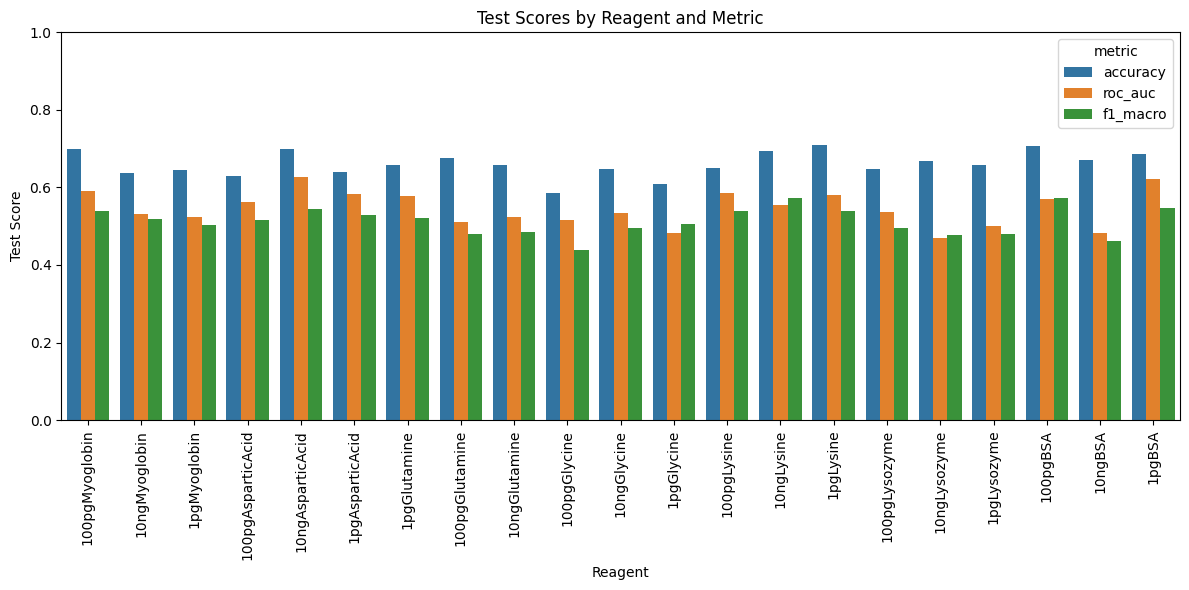


Reagents ranked by mean accuracy:


reagent
1pgLysine            0.710417
100pgBSA             0.706250
100pgMyoglobin       0.700000
10ngAsparticAcid     0.700000
10ngLysine           0.693750
1pgBSA               0.687500
100pgGlutamine       0.675000
10ngBSA              0.670833
10ngLysozyme         0.668750
1pgGlutamine         0.658333
10ngGlutamine        0.658333
1pgLysozyme          0.658333
100pgLysine          0.650000
10ngGlycine          0.647917
100pgLysozyme        0.647917
1pgMyoglobin         0.643750
1pgAsparticAcid      0.639583
10ngMyoglobin        0.637500
100pgAsparticAcid    0.629167
1pgGlycine           0.608333
100pgGlycine         0.585417
Name: test_score, dtype: float64

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the grouped bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
sns.barplot(data=results, x='reagent', y='test_score', hue='metric')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability if needed
plt.title('Test Scores by Reagent and Metric')
plt.xlabel('Reagent')
plt.ylabel('Test Score')
plt.tight_layout() # prevent labels from overlapping
plt.ylim(0, 1)  # Set y-axis limits if needed
plt.show()

# Ranke reagent by accuracy metric
reagent_accuracy = results[results['metric'] == 'accuracy'].groupby('reagent')['test_score'].mean()
ranked_reagents = reagent_accuracy.sort_values(ascending=False)

print("\nReagents ranked by mean accuracy:")
ranked_reagents

PFAS classification

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PFAS_Project/PFAS data analysis/04142025_PFAS sub_corrected/combined_PFAS_8736.csv')
data = data.drop(columns = ['Unnamed: 0'])
display(data)

# Select data that is not DI
print('Select data that is not BW')
data = data[data['Sample'] != 'BW']
display(data)

data.reset_index(drop = True, inplace = True)

# Split features and labels
X = data.iloc[:, :150]
y = data['Sample']

/tmp/ipython-input-4-1000631298.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/PFAS_Project/PFAS data analysis/04142025_PFAS sub_corrected/combined_PFAS_8736.csv')


frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  \
0         25      31      34      38      39      42      45      46      48   
1         25      31      34      38      41      42      44      45      47   
2         26      33      37      40      42      45      47      48      50   
3         18      35      42      48      51      53      55      56      59   
4         19      35      42      47      51      53      56      57      58   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
8731      19      23      27      32      38      36      40      44      46   
8732      20      26      28      31      35      39      39      42      42   
8733      25      25      28      29      38      41      38      37      39   
8734      24      24      24      26      25      26      31      31      34   
8735      21      27      30      33      35      36      39      42      42   

      frame10  ...  frame146  frame147  frame148  frame149  frame150   Sample  \
0          50  ...       139       140       139       140       140  1pgPFOA   
1          49  ...       141       141       143       142       143  1pgPFOA   
2          53  ...       140       141       141       141       141  1pgPFOA   
3          61  ...       140       140       141       141       140  1pgPFOA   
4          61  ...       141       141       141       141       141  1pgPFOA   
...       ...  ...       ...       ...       ...       ...       ...      ...   
8731       51  ...       105       106       107       107       107       BW   
8732       46  ...       115       114       115       114       115       BW   
8733       38  ...       108       107       108       109       109       BW   
8734       38  ...       116       116       116       116       116       BW   
8735       43  ...       110       110       113       113       113       BW   

             Reagent  Chip  Channel  lane  
0     100pgMyoglobin     1        1     2  
1     100pgMyoglobin     1        1     3  
2     100pgMyoglobin     1        1     4  
3     100pgMyoglobin     1        2     2  
4     100pgMyoglobin     1        2     3  
...              ...   ...      ...   ...  
8731         10ngBSA     1        4     1  
8732         10ngBSA     1        4     2  
8733         10ngBSA     1        4     3  
8734         10ngBSA     1        4     4  
8735         10ngBSA     1        4     5  

[8736 rows x 155 columns]

Select data that is not BW


frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  \
0         25      31      34      38      39      42      45      46      48   
1         25      31      34      38      41      42      44      45      47   
2         26      33      37      40      42      45      47      48      50   
3         18      35      42      48      51      53      55      56      59   
4         19      35      42      47      51      53      56      57      58   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
4531      17      30      37      43      41      41      43      44      46   
4532      16      27      28      29      34      39      43      45      45   
4533      20      29      34      37      42      46      49      51      54   
4534      28      34      38      42      46      49      51      53      55   
4535      28      26      27      28      32      32      34      36      37   

      frame10  ...  frame146  frame147  frame148  frame149  frame150   Sample  \
0          50  ...       139       140       139       140       140  1pgPFOA   
1          49  ...       141       141       143       142       143  1pgPFOA   
2          53  ...       140       141       141       141       141  1pgPFOA   
3          61  ...       140       140       141       141       140  1pgPFOA   
4          61  ...       141       141       141       141       141  1pgPFOA   
...       ...  ...       ...       ...       ...       ...       ...      ...   
4531       48  ...       140       140       139       141       141  1pgGenX   
4532       46  ...       114       115       116       116       117  1pgGenX   
4533       56  ...       135       135       135       136       136  1pgGenX   
4534       57  ...       134       135       135       137       136  1pgGenX   
4535       38  ...       105       106       108       107       108  1pgGenX   

             Reagent  Chip  Channel  lane  
0     100pgMyoglobin     1        1     2  
1     100pgMyoglobin     1        1     3  
2     100pgMyoglobin     1        1     4  
3     100pgMyoglobin     1        2     2  
4     100pgMyoglobin     1        2     3  
...              ...   ...      ...   ...  
4531          1pgBSA     1        3     3  
4532          1pgBSA     1        3     4  
4533          1pgBSA     1        4     2  
4534          1pgBSA     1        4     3  
4535          1pgBSA     1        4     4  

[4536 rows x 155 columns]

/tmp/ipython-input-5-552406982.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.50248694  0.50248694  0.69738054 ... -0.4719811   1.08716776
  1.08716776]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, :150] = scaler.fit_transform(X.iloc[:, :150])
/tmp/ipython-input-5-552406982.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.11018595 -0.11018595  0.36446123 ... -0.58483314  0.60178483
 -1.29680393]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, :150] = scaler.fit_transform(X.iloc[:, :150])
/tmp/ipython-input-5-552406982.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.40475354 -0.40475354  0.23696686 ... -0.40475354  0.45087365
 -1.90210112]' has d

Level 2 Classification Report (PFOA PFOS GenX):
              precision    recall  f1-score   support

        GenX      0.444     0.431     0.438       276
        PFOA      0.497     0.515     0.506       330
        PFOS      0.540     0.533     0.537       302

    accuracy                          0.496       908
   macro avg      0.494     0.493     0.493       908
weighted avg      0.495     0.496     0.495       908



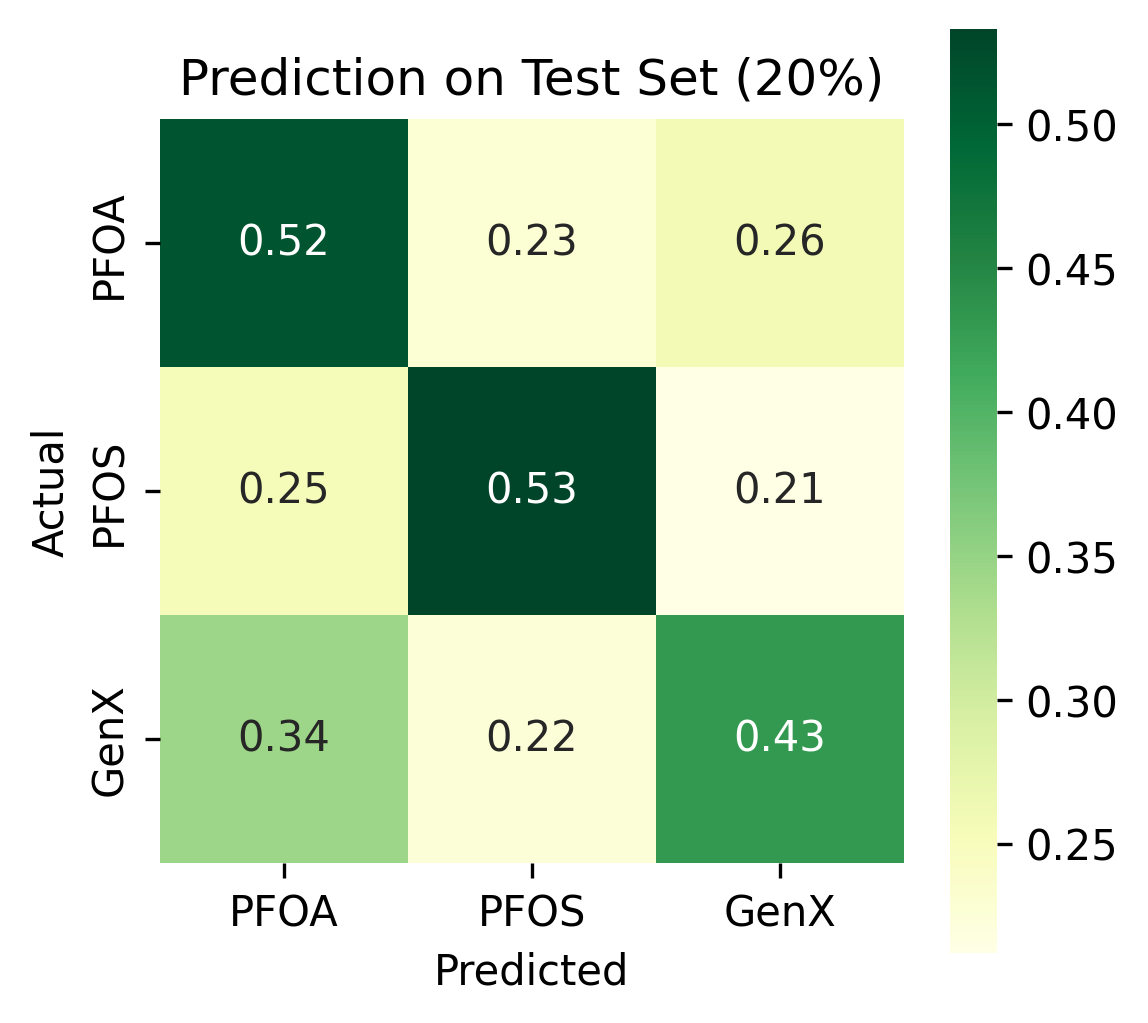

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Standardize the flow profiles (columns from flow_1 to flow_150)
scaler = StandardScaler()
X.iloc[:, :150] = scaler.fit_transform(X.iloc[:, :150])

# Split dataset for Level 2: PFOA, PFOA, GenX
y_level2 = y.apply(lambda x: x[-4:])
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_level2, test_size=test_size, random_state=42)

# Train a Random Forest Classifier for Level 2
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Level 2 Classification Report (PFOA PFOS GenX):")
print(classification_report(y_test, y_pred, digits=3))

#draw a confusion matrix showing the pred result
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
labels = ['PFOA', 'PFOS', 'GenX']
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
draw_confusion_matrix(cm, labels, title='Prediction on Test Set ({:.0%})'.format(test_size))

In [ ]:
# Train separate model for each reagents

# Show features and labels
display(X)
display(y_level2)


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def CVscores_LeaveOneGroupOut(X, y, groups, scores_metrics = ["accuracy", "f1_macro"]):
    """
    Perform cross-validation using LeaveOneGroupOut.
    Args:
      X: Data matrix of shape (n_samples, n_features).
      y: Label vector of shape (n_samples,).
      groups: Group labels for each sample.
    Returns:
      A dictionary containing the results of cross-validation.
    """
    clf = RandomForestClassifier(max_depth= None, min_samples_leaf=2, min_samples_split= 10, n_estimators=100, random_state=42)

    # The pipeline scales/normalizes features, and then implements the random forest classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Apply normalization
        ('clf', clf)
    ])

    # Calling the LeaveOneGroupOut function from scikit
    logo = LeaveOneGroupOut()

    # Conducting the cross-validation with shuffling of task order within each participant's group
    results = cross_validate(pipeline, X, y, cv=logo, groups=groups, scoring=scores_metrics, return_train_score=True, return_estimator=True)

    for metric in scores_metrics:
      print(f'--- Metric {metric}')
      print('   Training score: %.4f' % results[f'train_{metric}'].mean())
      print('   Test score: %.4f' % results[f'test_{metric}'].mean())
      print('   All scores: ', results[f'test_{metric}'])
    return results, scores_metrics


reagents = data['Reagent'].unique()

results = pd.DataFrame(columns = ['reagent', 'metric', 'train_score', 'test_score'])

for reagent in reagents:
    print('Reagent: ', reagent)
    # Subset the data for the given reagent
    X_reagent = X[data['Reagent'] == reagent]
    y_reagent = y_level2[data['Reagent'] == reagent]

    # groups are the label for spliting test/train sets
    groups = (data['Chip'][data['Reagent'] == reagent]-1)*4+data['Channel'][data['Reagent'] == reagent]

    # Train a model (e.g., RandomForest) for each reagent
    result = CVscores_LeaveOneGroupOut(X_reagent, y_reagent, groups)
    for metric in result[1]:
        results.loc[len(results)] = [reagent, metric, result[0][f'train_{metric}'].mean(), result[0][f'test_{metric}'].mean()]

frame1    frame2    frame3    frame4    frame5    frame6    frame7  \
0     0.502487 -0.110186 -0.404754 -0.234104 -0.532023 -0.389721 -0.216608   
1     0.502487 -0.110186 -0.404754 -0.234104 -0.155510 -0.389721 -0.390109   
2     0.697381  0.364461  0.236967  0.162718  0.032746  0.150442  0.130393   
3    -0.861768  0.839108  1.306501  1.750009  1.727050  1.590878  1.518400   
4    -0.666875  0.839108  1.306501  1.551598  1.727050  1.590878  1.691901   
...        ...       ...       ...       ...       ...       ...       ...   
4531 -1.056662 -0.347510  0.236967  0.757952 -0.155510 -0.569776 -0.563610   
4532 -1.251556 -1.059480 -1.688194 -2.019807 -1.473303 -0.929884 -0.563610   
4533 -0.471981 -0.584833 -0.404754 -0.432516  0.032746  0.330497  0.477395   
4534  1.087168  0.601785  0.450874  0.559541  0.785770  0.870660  0.824397   
4535  1.087168 -1.296804 -1.902101 -2.218218 -1.849815 -2.190266 -2.125117   

        frame8    frame9   frame10  ...  frame141  frame142  frame143  \
0    -0.353236 -0.305092 -0.246854  ...  1.102043  1.071337  1.036795   
1    -0.520769 -0.469217 -0.408083  ...  1.415163  1.384435  1.349335   
2    -0.018172  0.023157  0.236831  ...  1.415163  1.384435  1.349335   
3     1.322088  1.500278  1.526659  ...  1.206416  1.280069  1.245155   
4     1.489620  1.336153  1.526659  ...  1.206416  1.175703  1.245155   
...        ...       ...       ...  ...       ...       ...       ...   
4531 -0.688301 -0.633341 -0.569311  ...  1.415163  1.384435  1.349335   
4532 -0.520769 -0.797466 -0.891768  ... -1.402922 -1.329076 -1.359349   
4533  0.484426  0.679655  0.720516  ...  0.684549  0.653874  0.620074   
4534  0.819491  0.843780  0.881745  ...  0.580175  0.549508  0.724254   
4535 -2.028561 -2.110463 -2.181596  ... -2.237910 -2.268369 -2.296970   

      frame144  frame145  frame146  frame147  frame148  frame149  frame150  
0     1.106388  1.071966  1.142966  1.214789  1.080601  1.153302  1.121272  
1     1.418030  1.382625  1.350458  1.318364  1.494711  1.360420  1.431507  
2     1.314149  1.279072  1.246712  1.318364  1.287656  1.256861  1.224684  
3     1.314149  1.279072  1.246712  1.214789  1.287656  1.256861  1.121272  
4     1.418030  1.279072  1.350458  1.318364  1.287656  1.256861  1.224684  
...        ...       ...       ...       ...       ...       ...       ...  
4531  1.314149  1.279072  1.246712  1.214789  1.080601  1.256861  1.224684  
4532 -1.594508 -1.413308 -1.450681 -1.374581 -1.300529 -1.332110 -1.257194  
4533  0.690866  0.761307  0.727982  0.696915  0.666492  0.739067  0.707626  
4534  0.690866  0.657754  0.624236  0.696915  0.666492  0.842626  0.707626  
4535 -2.217792 -2.241732 -2.384394 -2.306755 -2.128748 -2.264140 -2.187898  

[4536 rows x 150 columns]

0       PFOA
1       PFOA
2       PFOA
3       PFOA
4       PFOA
        ... 
4531    GenX
4532    GenX
4533    GenX
4534    GenX
4535    GenX
Name: Sample, Length: 4536, dtype: object

Reagent:  100pgMyoglobin
--- Metric accuracy
   Training score: 0.9398
   Test score: 0.3148
   All scores:  [0.2037037  0.35185185 0.5        0.2037037 ]
--- Metric f1_macro
   Training score: 0.9396
   Test score: 0.3021
   All scores:  [0.19455582 0.34080994 0.49379509 0.17943328]
Reagent:  10ngMyoglobin
--- Metric accuracy
   Training score: 0.9522
   Test score: 0.3657
   All scores:  [0.22222222 0.42592593 0.40740741 0.40740741]
--- Metric f1_macro
   Training score: 0.9521
   Test score: 0.3535
   All scores:  [0.17391304 0.42090295 0.39751895 0.42175926]
Reagent:  1pgMyoglobin
--- Metric accuracy
   Training score: 0.9568
   Test score: 0.5046
   All scores:  [0.5        0.55555556 0.59259259 0.37037037]
--- Metric f1_macro
   Training score: 0.9567
   Test score: 0.4832
   All scores:  [0.48471888 0.51881429 0.59018759 0.33901677]
Reagent:  100pgAsparticAcid
--- Metric accuracy
   Training score: 0.9614
   Test score: 0.3565
   All scores:  [0.35185185 0.40740741 0.31481481 0.

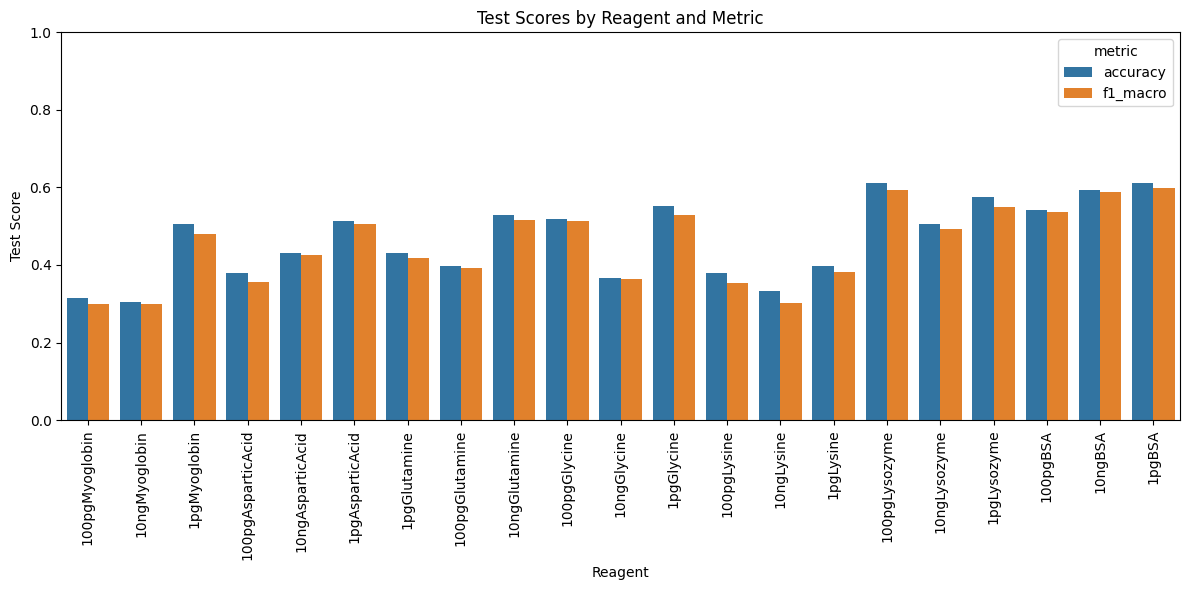


Reagents ranked by mean accuracy:


reagent
100pgLysozyme        0.611111
1pgBSA               0.611111
10ngBSA              0.592593
1pgLysozyme          0.574074
1pgGlycine           0.550926
100pgBSA             0.541667
10ngGlutamine        0.527778
100pgGlycine         0.518519
1pgAsparticAcid      0.513889
1pgMyoglobin         0.504630
10ngLysozyme         0.504630
1pgGlutamine         0.430556
10ngAsparticAcid     0.430556
1pgLysine            0.398148
100pgGlutamine       0.398148
100pgLysine          0.379630
100pgAsparticAcid    0.379630
10ngGlycine          0.365741
10ngLysine           0.333333
100pgMyoglobin       0.314815
10ngMyoglobin        0.305556
Name: test_score, dtype: float64

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the grouped bar plot
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
sns.barplot(data=results, x='reagent', y='test_score', hue='metric')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability if needed
plt.title('Test Scores by Reagent and Metric')
plt.xlabel('Reagent')
plt.ylabel('Test Score')
plt.tight_layout() # prevent labels from overlapping
plt.ylim(0, 1)  # Set y-axis limits if needed
plt.show()

# Calculate mean accuracy for each reagent and rank
reagent_accuracy = results[results['metric'] == 'accuracy'].groupby('reagent')['test_score'].mean()
ranked_reagents = reagent_accuracy.sort_values(ascending=False)

print("\nReagents ranked by mean accuracy:")
ranked_reagents

Reagent combo and independent validation

In [ ]:
#data = pd.read_csv('/content/Data_4R_1555_NoJump.csv')
data = pd.read_csv('/content/drive/MyDrive/PFAS_Project/PFAS data analysis/06222025_Tucson water prechlorination/combined_10,1000ppt PFAS_8232.csv')
data = data.drop(columns = ['Unnamed: 0'])
display(data)

# Select data that is not DI
print('Select data that is not DI')
data = data[data['Sample'] != 'DI']

# Select reagents
Reagents = ['100pgLysozyme','1pgBSA','10ngBSA','1pgLysozyme']
data = data[data['Reagent'].isin(Reagents)]
display(data)

data.reset_index(drop = True, inplace = True)

frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  \
0       28.0    35.0    40.0    43.0    44.0    48.0    52.0    53.0    57.0   
1       28.0    36.0    40.0    42.0    46.0    47.0    51.0    53.0    55.0   
2       30.0    38.0    41.0    44.0    48.0    51.0    53.0    55.0    56.0   
3       28.0    36.0    40.0    44.0    48.0    49.0    51.0    53.0    54.0   
4       29.0    38.0    43.0    46.0    50.0    51.0    53.0    56.0    58.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
8227    16.0    27.0    28.0    29.0    34.0    39.0    43.0    45.0    45.0   
8228    18.0    29.0    34.0    38.0    41.0    45.0    48.0    52.0    53.0   
8229    20.0    29.0    34.0    37.0    42.0    46.0    49.0    51.0    54.0   
8230    28.0    34.0    38.0    42.0    46.0    49.0    51.0    53.0    55.0   
8231    28.0    26.0    27.0    28.0    32.0    32.0    34.0    36.0    37.0   

      frame10  ...  frame146  frame147  frame148  frame149  frame150   Sample  \
0        56.0  ...     129.0     129.0     129.0     131.0     131.0       BW   
1        58.0  ...     125.0     125.0     127.0     128.0     127.0       BW   
2        59.0  ...     132.0     133.0     134.0     135.0     136.0       BW   
3        57.0  ...     133.0     133.0     134.0     135.0     135.0       BW   
4        60.0  ...     141.0     141.0     143.0     143.0     143.0       BW   
...       ...  ...       ...       ...       ...       ...       ...      ...   
8227     46.0  ...     114.0     115.0     116.0     116.0     117.0  1pgGenX   
8228     54.0  ...     133.0     133.0     133.0     133.0     133.0  1pgGenX   
8229     56.0  ...     135.0     135.0     135.0     136.0     136.0  1pgGenX   
8230     57.0  ...     134.0     135.0     135.0     137.0     136.0  1pgGenX   
8231     38.0  ...     105.0     106.0     108.0     107.0     108.0  1pgGenX   

           Reagent  Chip  Channel  lane  
0     1pgMyoglobin     1        1     1  
1     1pgMyoglobin     1        1     2  
2     1pgMyoglobin     1        1     3  
3     1pgMyoglobin     1        1     4  
4     1pgMyoglobin     1        1     5  
...            ...   ...      ...   ...  
8227        1pgBSA     1        3     4  
8228        1pgBSA     1        4     1  
8229        1pgBSA     1        4     2  
8230        1pgBSA     1        4     3  
8231        1pgBSA     1        4     4  

[8232 rows x 155 columns]

Select data that is not DI


frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  \
1200    24.0    30.0    34.0    36.0    40.0    42.0    43.0    45.0    47.0   
1201    16.0    25.0    31.0    35.0    37.0    38.0    40.0    44.0    46.0   
1202    19.0    28.0    33.0    37.0    40.0    42.0    41.0    45.0    49.0   
1203    22.0    31.0    34.0    37.0    39.0    43.0    45.0    48.0    50.0   
1204    24.0    31.0    35.0    39.0    42.0    44.0    45.0    47.0    51.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
8227    16.0    27.0    28.0    29.0    34.0    39.0    43.0    45.0    45.0   
8228    18.0    29.0    34.0    38.0    41.0    45.0    48.0    52.0    53.0   
8229    20.0    29.0    34.0    37.0    42.0    46.0    49.0    51.0    54.0   
8230    28.0    34.0    38.0    42.0    46.0    49.0    51.0    53.0    55.0   
8231    28.0    26.0    27.0    28.0    32.0    32.0    34.0    36.0    37.0   

      frame10  ...  frame146  frame147  frame148  frame149  frame150   Sample  \
1200     50.0  ...     128.0     126.0     126.0     127.0     130.0       BW   
1201     50.0  ...     125.0     125.0     126.0     126.0     126.0       BW   
1202     51.0  ...     125.0     125.0     124.0     124.0     124.0       BW   
1203     51.0  ...     125.0     125.0     127.0     128.0     128.0       BW   
1204     53.0  ...     127.0     127.0     128.0     127.0     128.0       BW   
...       ...  ...       ...       ...       ...       ...       ...      ...   
8227     46.0  ...     114.0     115.0     116.0     116.0     117.0  1pgGenX   
8228     54.0  ...     133.0     133.0     133.0     133.0     133.0  1pgGenX   
8229     56.0  ...     135.0     135.0     135.0     136.0     136.0  1pgGenX   
8230     57.0  ...     134.0     135.0     135.0     137.0     136.0  1pgGenX   
8231     38.0  ...     105.0     106.0     108.0     107.0     108.0  1pgGenX   

          Reagent  Chip  Channel  lane  
1200  1pgLysozyme     1        1     1  
1201  1pgLysozyme     1        1     2  
1202  1pgLysozyme     1        1     3  
1203  1pgLysozyme     1        1     4  
1204  1pgLysozyme     1        1     5  
...           ...   ...      ...   ...  
8227       1pgBSA     1        3     4  
8228       1pgBSA     1        4     1  
8229       1pgBSA     1        4     2  
8230       1pgBSA     1        4     3  
8231       1pgBSA     1        4     4  

[1568 rows x 155 columns]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import LeaveOneGroupOut, cross_validate, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelEncoder

def draw_confusion_matrix(cm, labels, title=None):
    """
      draw a confusion matrix showing the pred result, actual labels versus predicted labels
      cm: confusion matrix
      labels: list of labels
    """
    ## Use seaborn to draw confusion matrix
    plt.figure(figsize=(4,4), dpi=300)
    ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap="YlGn", square='True')
    if title:
        ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');

    ## Ticket labels - List must be in the same order as above (alphabetical order if resorted automatically)
    ax.yaxis.set_ticklabels(labels, fontsize="10")
    ax.xaxis.set_ticklabels(labels, fontsize="10")

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    plt.close()
    #plt.savefig('1.png', transparent=True, bbox_inches='tight')

def CVscores_LeaveOneGroupOut_oversample(X, y, labels, class_of_interest, groups):
    """
    Perform cross-validation using LeaveOneGroupOut.
    Args:
      X: Data matrix of shape (n_samples, n_features).
      y: Label vector of shape (n_samples,).
      groups: Group labels for each sample.
    Returns:
      A dictionary containing the results of cross-validation.
    """
    pd.options.mode.chained_assignment = None  # default='warn'
    # Calling the LeaveOneGroupOut function from scikit
    logo = LeaveOneGroupOut()
    metrics = {"accuracy": [], "roc_auc": [], "f1_macro": []}
    y_all = pd.DataFrame(columns=['True', 'Pred', 'Prob'])
    class_id = labels.index(class_of_interest)

    #results = pd.DataFrame(columns = ['reagent', 'metric', 'train_score', 'test_score'])
    for train_index, test_index in logo.split(X, y, groups=groups): #replace groups with your groups data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # oversample the minority
        ros = RandomOverSampler(sampling_strategy = 'minority', random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)

        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

        # Standardize the flow profiles (columns from flow_1 to flow_150)
        scaler = StandardScaler()
        Cnum = len(X_train.columns)
        X_train.iloc[:, :Cnum] = scaler.fit_transform(X_train.iloc[:, :Cnum])
        X_test.iloc[:, :Cnum] = scaler.fit_transform(X_test.iloc[:, :Cnum])

        # Train your model (e.g., rf_model) on the training data
        rf_model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf_model.predict(X_test)
        y_prob = rf_model.predict_proba(X_test)[:, class_id] # Assuming binary classification

        # Calculate metrics
        metrics["accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["roc_auc"].append(roc_auc_score(y_test, y_prob))
        metrics["f1_macro"].append(f1_score(y_test, y_pred, average='macro'))

        # merge y_test, y_pred from each loop/subset and draw confusion matrix
        y_all = pd.concat([y_all, pd.DataFrame({'True': y_test, 'Pred': y_pred, 'Prob': y_prob})])
    draw_confusion_matrix(confusion_matrix(y_all['True'], y_all['Pred'], normalize='true'), ['Mineral', 'PFAS'], title='Predictions in Cross-validation')
    print("Level 1 Classification Report (Mineral vs PFAS):")
    print(classification_report(y_all['True'], y_all['Pred'], digits=3))

    print("ROC curve for:", class_of_interest)
    le = LabelEncoder()
    fig, ax = plt.subplots()
    PFASRoc = RocCurveDisplay.from_predictions(
        le.fit_transform(y_all['True']),
        y_all['Prob'],
        name=f"{class_of_interest} vs rest",
        color="darkorange",
        plot_chance_level=True,
        ax=ax
    )
    _ = PFASRoc.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{class_of_interest} detection ROC curves",
    )

    mean_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
    print(mean_metrics)
    return mean_metrics, ["accuracy", "roc_auc", "f1_macro"]


def CVscores_LeaveOneGroupOut(X, y, groups, scores_metrics = ["accuracy", "f1_macro"]):
    """
    Perform cross-validation using LeaveOneGroupOut.
    Args:
      X: Data matrix of shape (n_samples, n_features).
      y: Label vector of shape (n_samples,).
      groups: Group labels for each sample.
    Returns:
      A dictionary containing the results of cross-validation.
    """
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # The pipeline scales/normalizes features, and then implements the random forest classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Apply normalization
        ('clf', clf)
    ])

    # Calling the LeaveOneGroupOut function from scikit
    logo = LeaveOneGroupOut()

    # Conducting the cross-validation with shuffling of task order within each participant's group
    results = cross_validate(pipeline, X, y, cv=logo, groups=groups, scoring=scores_metrics, return_train_score=True, return_estimator=True)

    for metric in scores_metrics:
      print(f'--- Metric {metric}')
      print('   Training score: %.4f' % results[f'train_{metric}'].mean())
      print('   Test score: %.4f' % results[f'test_{metric}'].mean())
      print('   All scores: ', results[f'test_{metric}'])
    return results, scores_metrics

def Draw_PredCM_LeaveOneGroupOut(X, y, groups):
    """
    Draw prediction confusion matrix using LeaveOneGroupOut.
    Args:
      X: Data matrix of shape (n_samples, n_features).
      y: Label vector of shape (n_samples,).
      groups: Group labels for each sample.
    Returns:
      A confusion matrix showing the result of crosss validation prediction.
    """
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    # The pipeline scales/normalizes features, and then implements the random forest classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Apply normalization
        ('clf', clf)
    ])

    # Calling the LeaveOneGroupOut function from scikit
    logo = LeaveOneGroupOut()

    # Conducting the cross-validation with shuffling of task order within each participant's group
    y_pred = cross_val_predict(pipeline, X, y, groups=groups, cv=logo)
    labels = ['PFOA', 'PFOS', 'GenX']
    cm = confusion_matrix(y, y_pred, labels=labels, normalize='true')
    draw_confusion_matrix(cm, labels, title='Predictions in Cross-validation')
    print("Level 2 Classification Report (PFOA PFOS GenX):")
    print(classification_report(y, y_pred, digits=3))

Reagent:  1pgLysozyme
Explained variance ratio for each component: [0.90931048 0.06348886 0.00948905 0.00464132 0.00381465]
Cumulative variance ratio: [0.90931048 0.97279934 0.9822884  0.98692971 0.99074436]


/tmp/ipython-input-66-43407647.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y[0] != 0:
/tmp/ipython-input-65-1626227742.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  y_all = pd.concat([y_all, pd.DataFrame({'True': y_test, 'Pred': y_pred, 'Prob': y_prob})])


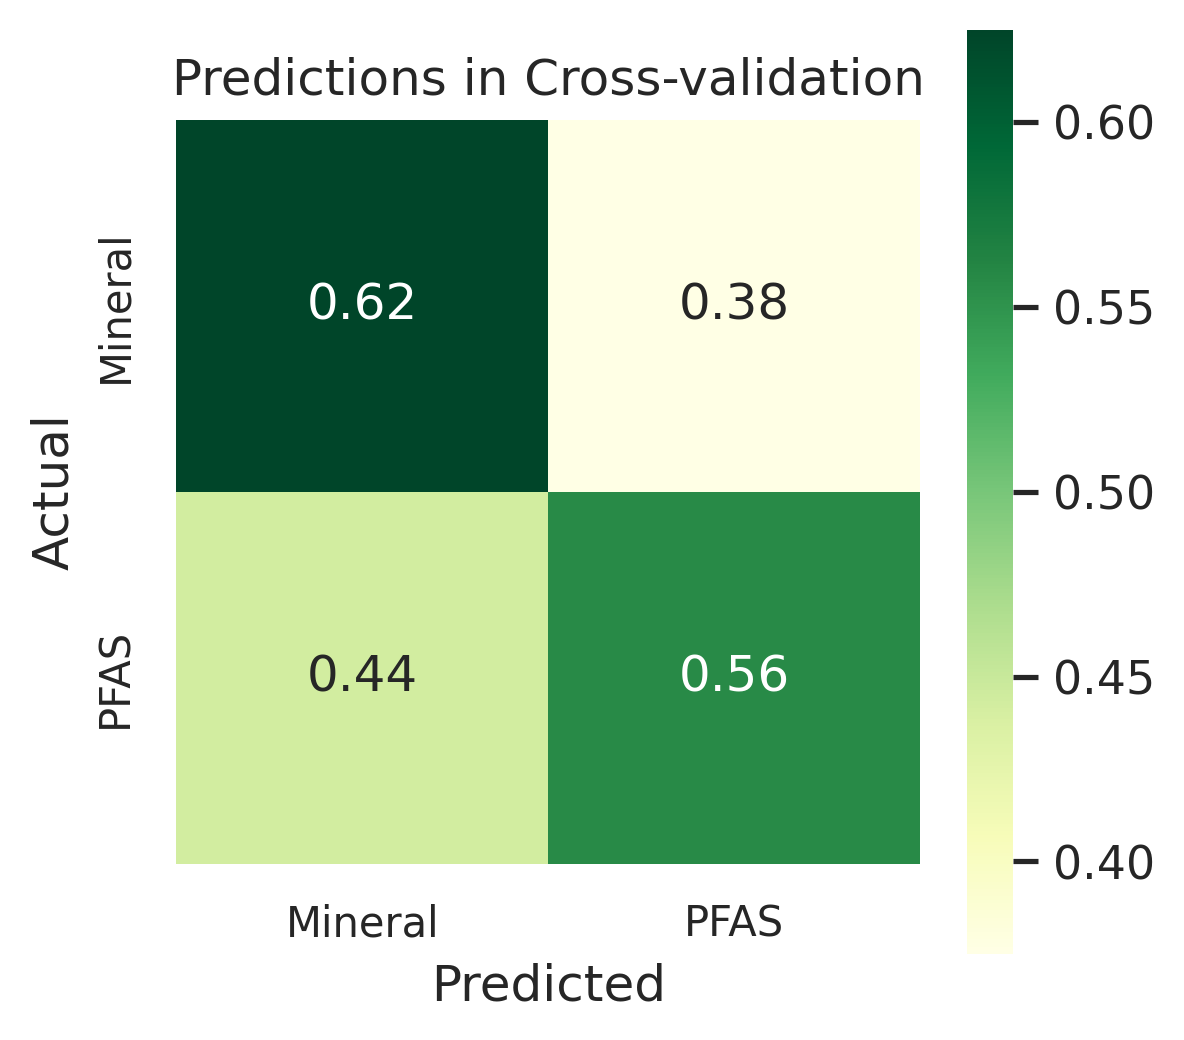

Level 1 Classification Report (Mineral vs PFAS):
              precision    recall  f1-score   support

     Mineral      0.595     0.625     0.610       200
        PFAS      0.588     0.557     0.572       192

    accuracy                          0.592       392
   macro avg      0.592     0.591     0.591       392
weighted avg      0.592     0.592     0.591       392

ROC curve for: PFAS
{'accuracy': np.float64(0.5918367346938775), 'roc_auc': np.float64(0.6347395833333334), 'f1_macro': np.float64(0.5904415136514206)}
--- Metric accuracy
   Training score: 1.0000
   Test score: 0.5052
   All scores:  [0.5        0.45833333 0.5        0.5625    ]
--- Metric f1_macro
   Training score: 1.0000
   Test score: 0.4671
   All scores:  [0.45436081 0.47718254 0.47388414 0.46315789]


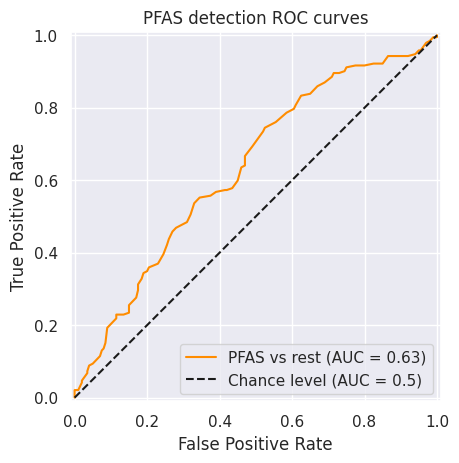

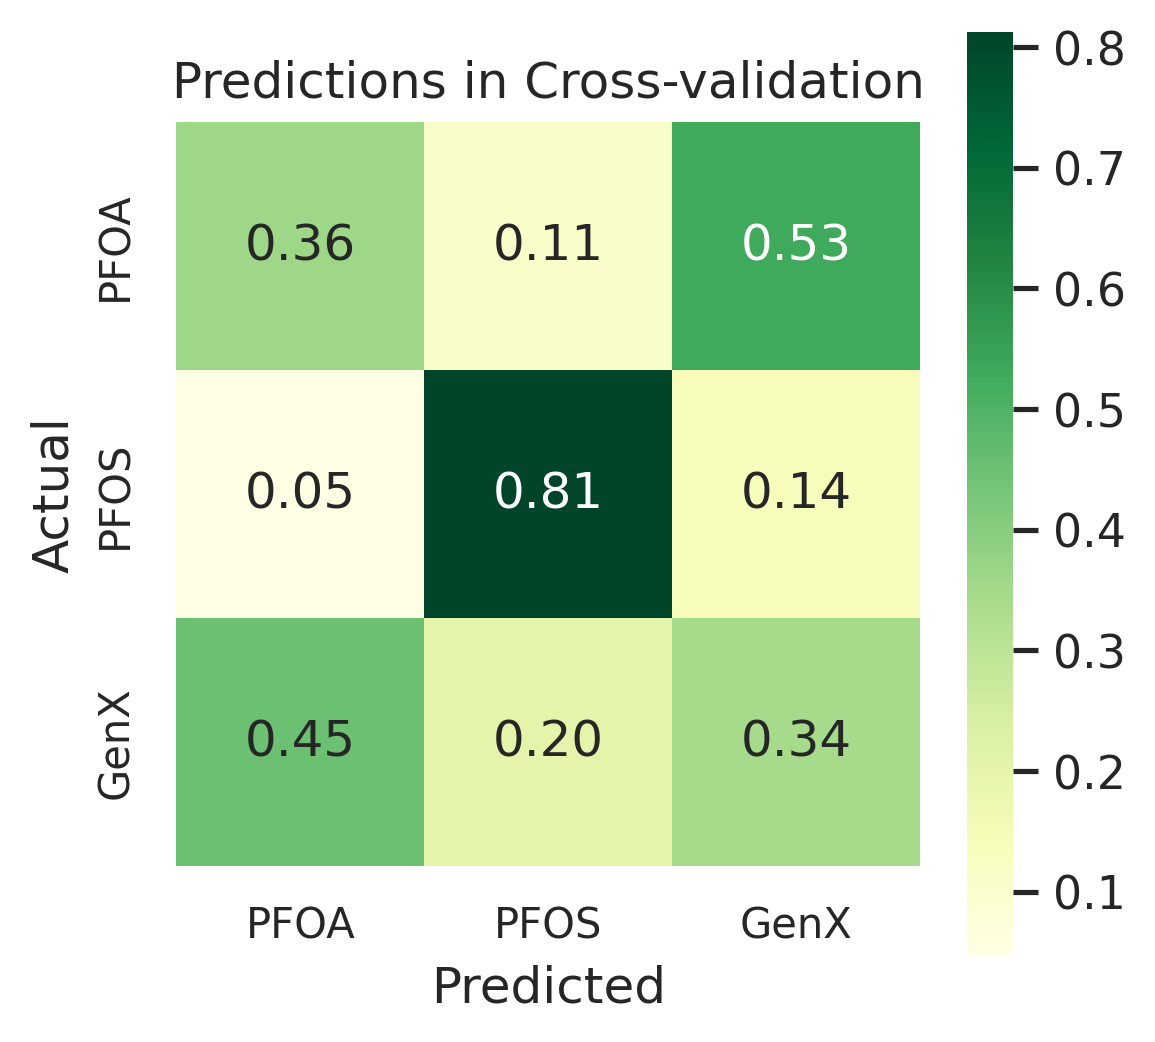

Level 2 Classification Report (PFOA PFOS GenX):
              precision    recall  f1-score   support

        GenX      0.338     0.344     0.341        64
        PFOA      0.418     0.359     0.387        64
        PFOS      0.722     0.812     0.765        64

    accuracy                          0.505       192
   macro avg      0.493     0.505     0.497       192
weighted avg      0.493     0.505     0.497       192

Reagent:  100pgLysozyme
Explained variance ratio for each component: [0.92991062 0.04521174 0.00998384 0.00403906 0.00249016]
Cumulative variance ratio: [0.92991062 0.97512236 0.98510621 0.98914527 0.99163544]


/tmp/ipython-input-66-43407647.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y[0] != 0:
/tmp/ipython-input-65-1626227742.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  y_all = pd.concat([y_all, pd.DataFrame({'True': y_test, 'Pred': y_pred, 'Prob': y_prob})])


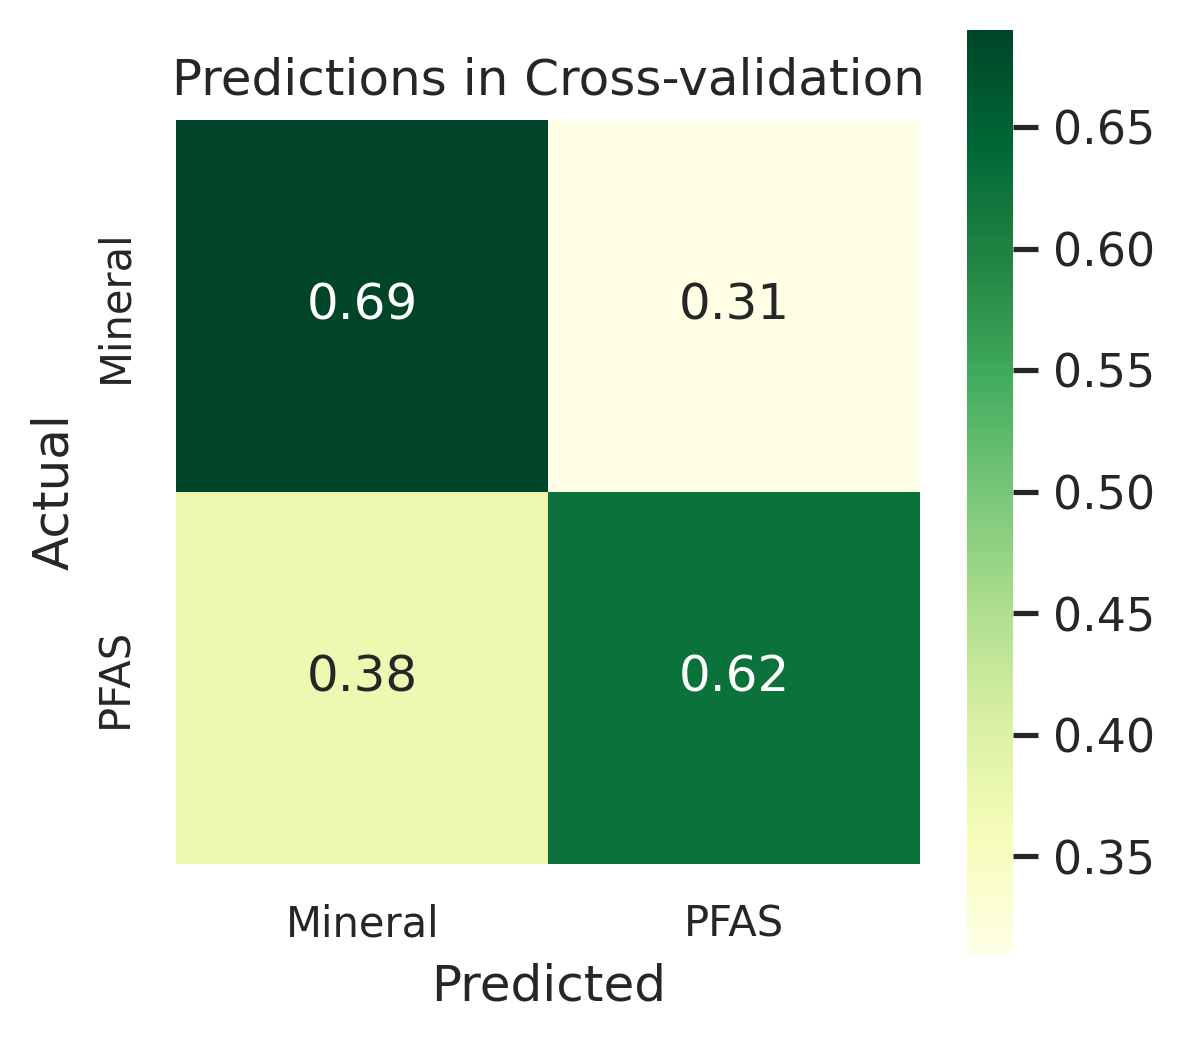

Level 1 Classification Report (Mineral vs PFAS):
              precision    recall  f1-score   support

     Mineral      0.657     0.690     0.673       200
        PFAS      0.659     0.625     0.642       192

    accuracy                          0.658       392
   macro avg      0.658     0.657     0.657       392
weighted avg      0.658     0.658     0.658       392

ROC curve for: PFAS
{'accuracy': np.float64(0.6581632653061225), 'roc_auc': np.float64(0.7258854166666666), 'f1_macro': np.float64(0.6552794600154849)}
--- Metric accuracy
   Training score: 1.0000
   Test score: 0.6771
   All scores:  [0.72916667 0.8125     0.5625     0.60416667]
--- Metric f1_macro
   Training score: 1.0000
   Test score: 0.6621
   All scores:  [0.72224373 0.80307692 0.55925926 0.56377218]


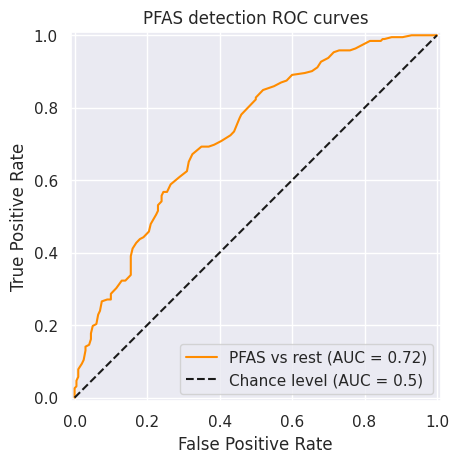

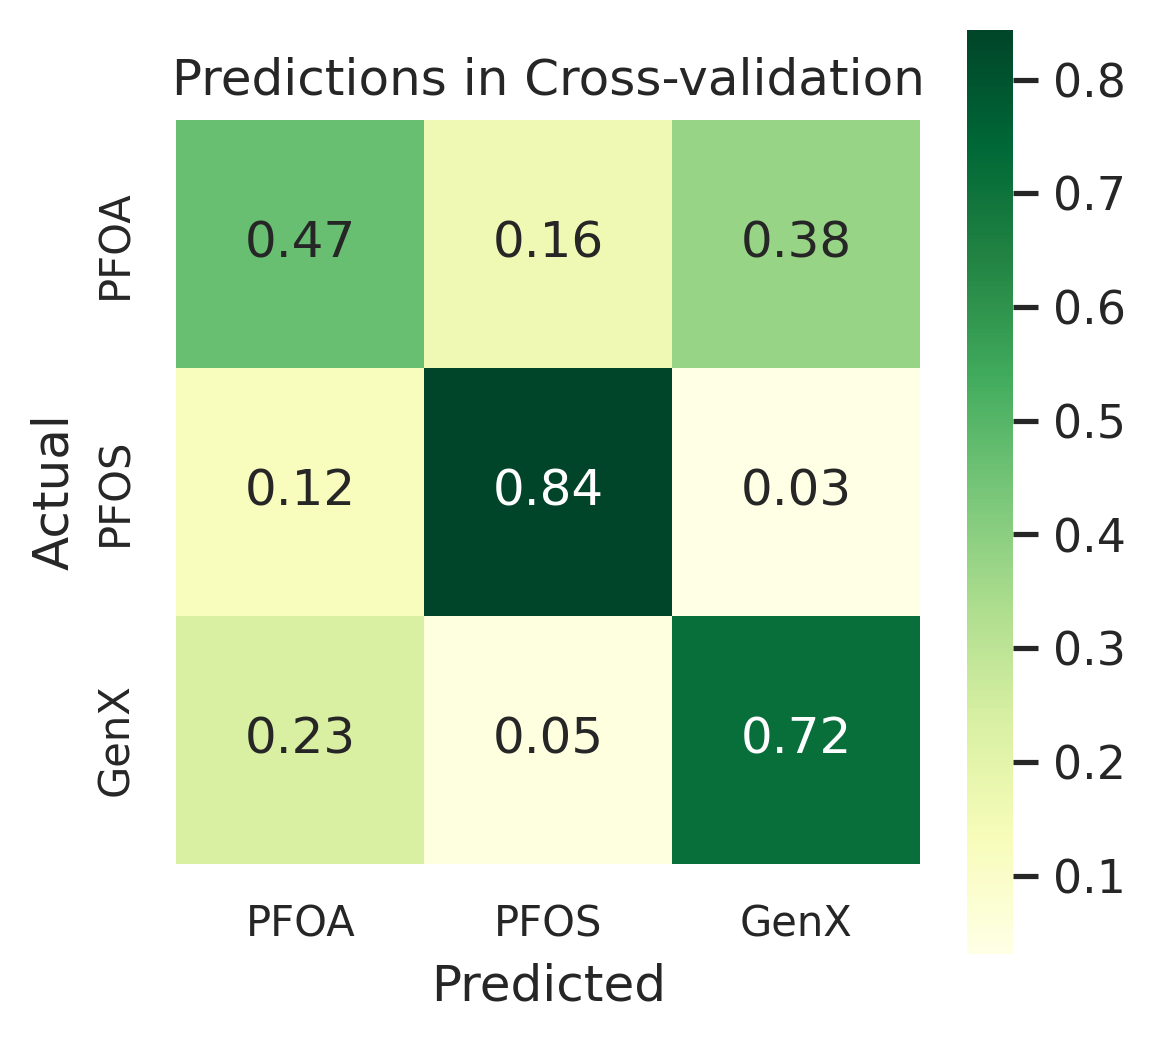

Level 2 Classification Report (PFOA PFOS GenX):
              precision    recall  f1-score   support

        GenX      0.639     0.719     0.676        64
        PFOA      0.566     0.469     0.513        64
        PFOS      0.806     0.844     0.824        64

    accuracy                          0.677       192
   macro avg      0.670     0.677     0.671       192
weighted avg      0.670     0.677     0.671       192

Reagent:  10ngBSA
Explained variance ratio for each component: [0.95242099 0.02733535 0.00824138 0.00332881 0.00182504]
Cumulative variance ratio: [0.95242099 0.97975634 0.98799772 0.99132653 0.99315156]


/tmp/ipython-input-66-43407647.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y[0] != 0:
/tmp/ipython-input-65-1626227742.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  y_all = pd.concat([y_all, pd.DataFrame({'True': y_test, 'Pred': y_pred, 'Prob': y_prob})])


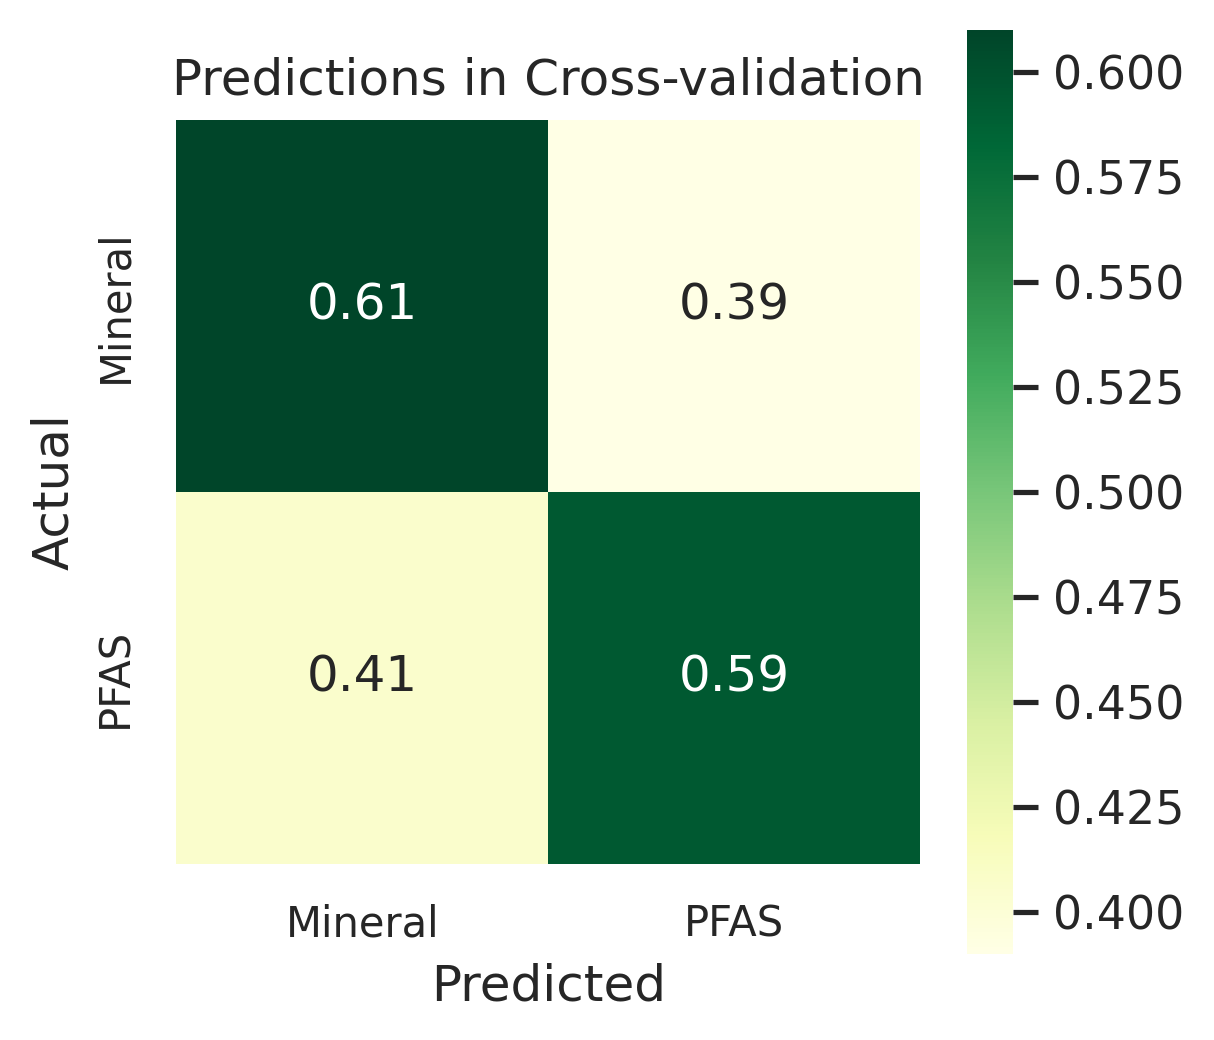

Level 1 Classification Report (Mineral vs PFAS):
              precision    recall  f1-score   support

     Mineral      0.610     0.610     0.610       200
        PFAS      0.594     0.594     0.594       192

    accuracy                          0.602       392
   macro avg      0.602     0.602     0.602       392
weighted avg      0.602     0.602     0.602       392

ROC curve for: PFAS
{'accuracy': np.float64(0.6020408163265306), 'roc_auc': np.float64(0.6701041666666667), 'f1_macro': np.float64(0.5992273627952888)}
--- Metric accuracy
   Training score: 1.0000
   Test score: 0.5990
   All scores:  [0.64583333 0.66666667 0.5        0.58333333]
--- Metric f1_macro
   Training score: 1.0000
   Test score: 0.5921
   All scores:  [0.64249564 0.65425843 0.50617757 0.56532477]


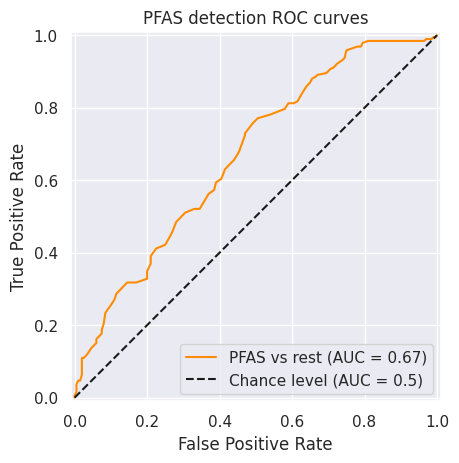

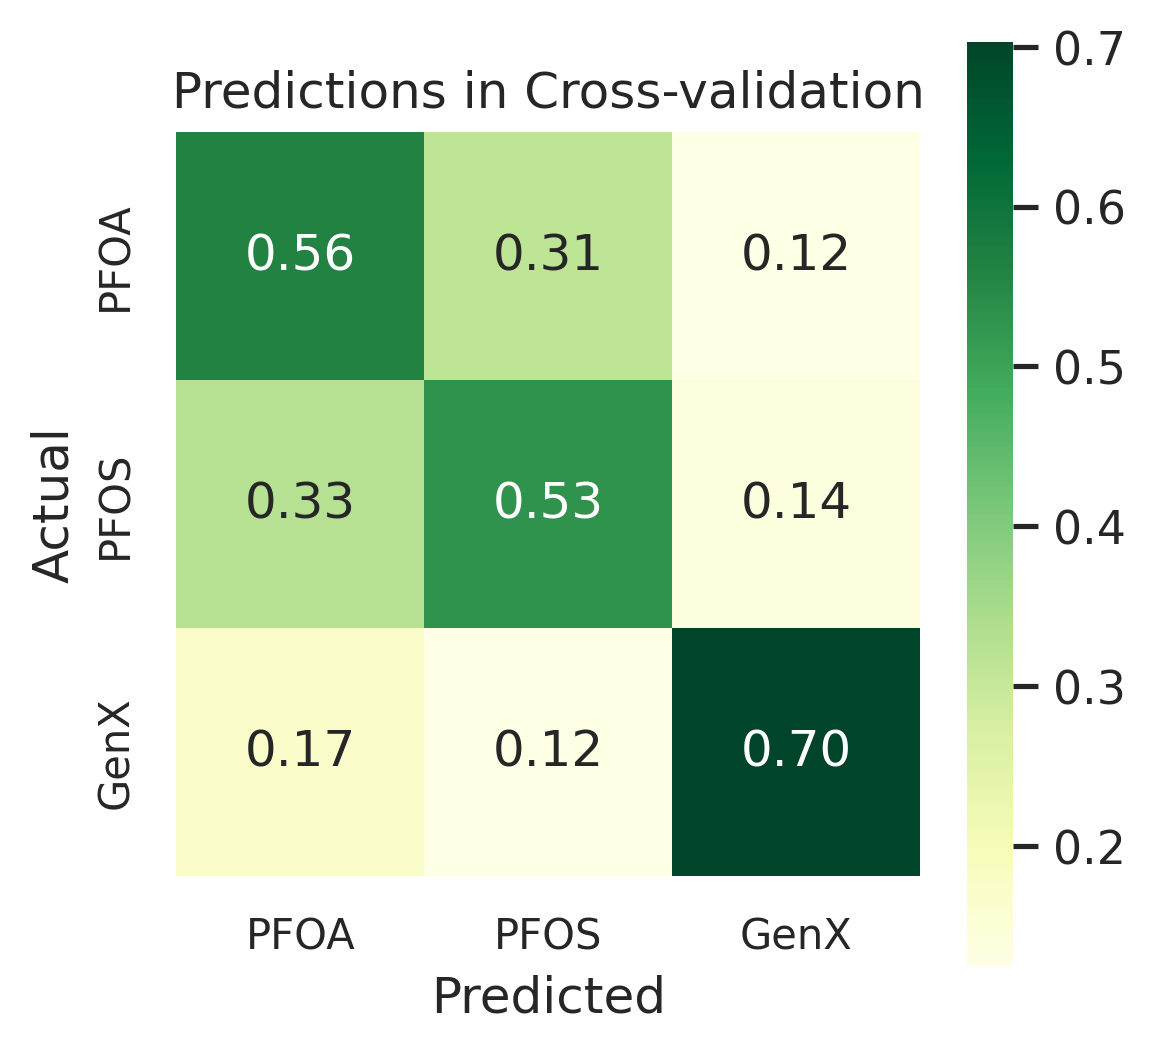

Level 2 Classification Report (PFOA PFOS GenX):
              precision    recall  f1-score   support

        GenX      0.726     0.703     0.714        64
        PFOA      0.529     0.562     0.545        64
        PFOS      0.548     0.531     0.540        64

    accuracy                          0.599       192
   macro avg      0.601     0.599     0.600       192
weighted avg      0.601     0.599     0.600       192

Reagent:  1pgBSA
Explained variance ratio for each component: [0.92520671 0.04172651 0.0137127  0.005185   0.00363945]
Cumulative variance ratio: [0.92520671 0.96693321 0.98064591 0.98583091 0.98947036]


/tmp/ipython-input-66-43407647.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y[0] != 0:
/tmp/ipython-input-65-1626227742.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  y_all = pd.concat([y_all, pd.DataFrame({'True': y_test, 'Pred': y_pred, 'Prob': y_prob})])


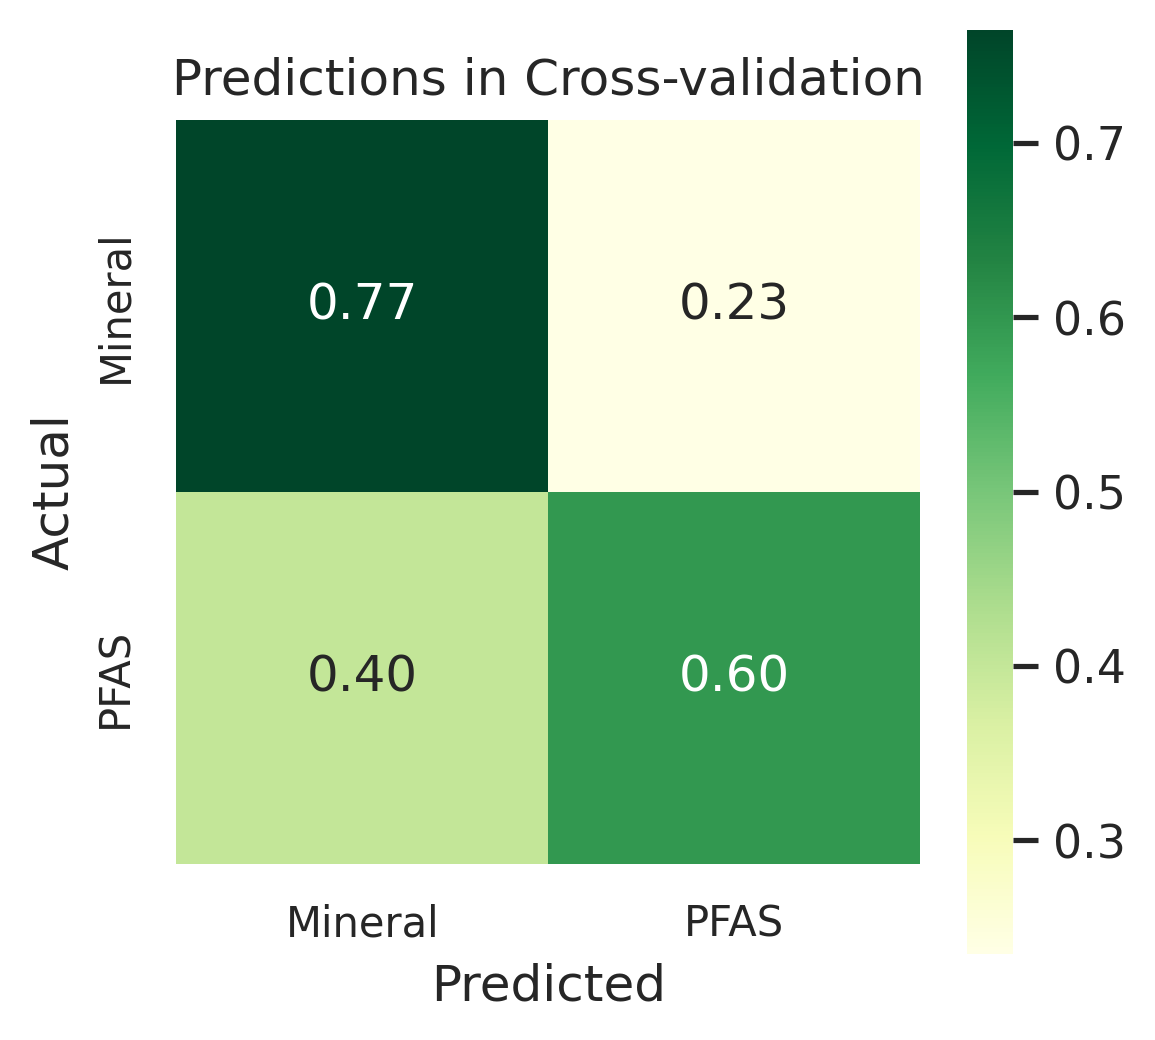

Level 1 Classification Report (Mineral vs PFAS):
              precision    recall  f1-score   support

     Mineral      0.665     0.765     0.712       200
        PFAS      0.710     0.599     0.650       192

    accuracy                          0.684       392
   macro avg      0.688     0.682     0.681       392
weighted avg      0.687     0.684     0.681       392

ROC curve for: PFAS
{'accuracy': np.float64(0.6836734693877551), 'roc_auc': np.float64(0.7083854166666668), 'f1_macro': np.float64(0.6790149442229158)}
--- Metric accuracy
   Training score: 1.0000
   Test score: 0.5417
   All scores:  [0.60416667 0.60416667 0.5        0.45833333]
--- Metric f1_macro
   Training score: 1.0000
   Test score: 0.5311
   All scores:  [0.54884135 0.60377973 0.50474383 0.4670156 ]


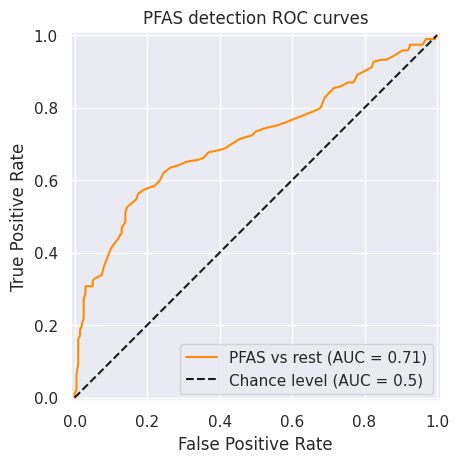

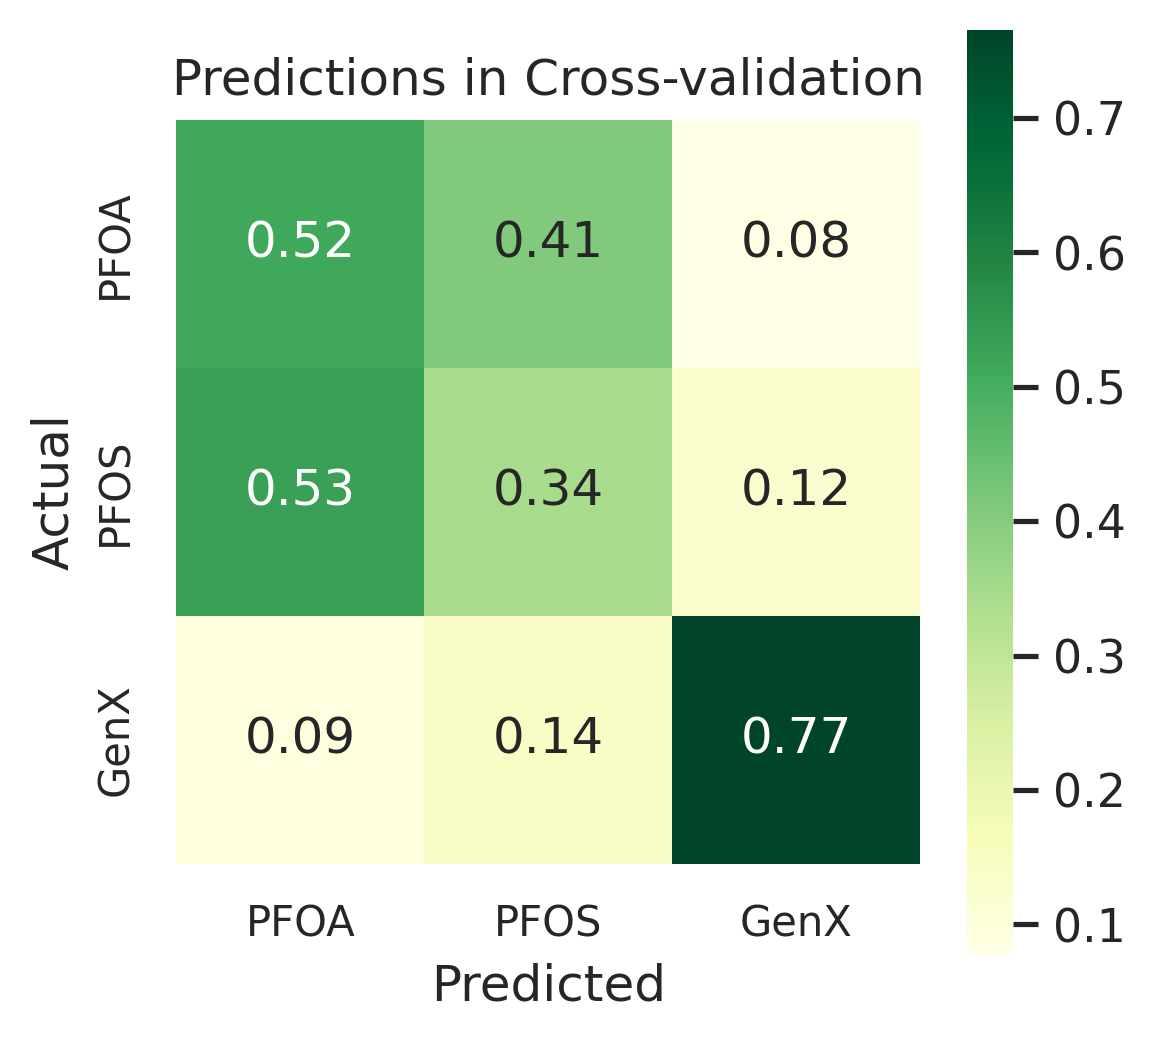

Level 2 Classification Report (PFOA PFOS GenX):
              precision    recall  f1-score   support

        GenX      0.790     0.766     0.778        64
        PFOA      0.452     0.516     0.482        64
        PFOS      0.386     0.344     0.364        64

    accuracy                          0.542       192
   macro avg      0.543     0.542     0.541       192
weighted avg      0.543     0.542     0.541       192



In [ ]:
# Standardize the flow profiles (columns from flow_1 to flow_150)
scaler = StandardScaler()
X = data.iloc[:, 0:150]
#X.iloc[:, :150] = scaler.fit_transform(data.iloc[:, 0:150])
#y = data['Sample']

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def smooth_flow(data, MovingAvgWindow=10):
    y = data
    #print(y)
    if y[0] != 0:
        y = np.insert(y, 0, 0)
        y = y[0:-1]
    N = MovingAvgWindow
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    data = np.convolve(y_padded, np.ones((N,))/N, mode='valid')
    return pd.Series(data)

# Standardize the flow profiles (columns from flow_1 to flow_150)
#scaler = StandardScaler()
#X.iloc[:, :150] = scaler.fit_transform(X.iloc[:, :150])

for reagent in data['Reagent'].unique():
    print('Reagent: ', reagent)
    # Subset the data for the given reagent
    X_reagent = X[data['Reagent'] == reagent]
    y_reagent = data['Sample'][data['Reagent'] == reagent]
    #display(X_reagent); display(y_reagent)

    # groups are the label for spliting test/train sets
    groups = (data['Chip'][data['Reagent'] == reagent]-1)*4+data['Channel'][data['Reagent'] == reagent]

    # Mineral vs PFAS binary classification (leaveonegroupout):
    y_level1 = y_reagent.apply(lambda x: 'Mineral' if x == 'BW' else 'PFAS')

    #L1_result = CVscores_LeaveOneGroupOut_oversample(X_reagent, y_level1, class_id, groups)
    #print(result)

    # PFOA vs PFOS vs GenX multiclass classification
    X_reagent2 = X_reagent[y_reagent != 'BW']
    y_level2 = y_reagent[y_reagent != 'BW'].apply(lambda x: x[-4:])
    groups_level2 = groups[y_reagent != 'BW']
    # Train a model (e.g., RandomForest) for each reagent
    #L2_result = CVscores_LeaveOneGroupOut(X_reagent2, y_level2, groups_level2)
    #Draw_PredCM_LeaveOneGroupOut(X_reagent2, y_level2, groups_level2)

    # Apply PCA
    X_smooth = X_reagent.apply(smooth_flow, axis=1)
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X_smooth)
    # Explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio for each component: {explained_variance}")
    cumulative_variance = np.cumsum(explained_variance)
    print(f"Cumulative variance ratio: {cumulative_variance}")

    # Create a new DataFrame with PCA components
    X_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

    # Mineral vs PFAS binary classification
    CVscores_LeaveOneGroupOut_oversample(X_pca, y_level1.reset_index(drop=True),
                                         labels=['Mineral', 'PFAS'], class_of_interest = 'PFAS', groups=groups)

    # PFOA vs PFOS vs GenX multiclass classification
    y_reagent = y_reagent.reset_index(drop=True)
    X_pca2 = X_pca[y_reagent != 'BW']
    # Train a model (e.g., RandomForest) for each reagent
    CVscores_LeaveOneGroupOut(X_pca2, y_level2.reset_index(drop=True), groups_level2)
    Draw_PredCM_LeaveOneGroupOut(X_pca2, y_level2.reset_index(drop=True), groups_level2)



In [ ]:
# Standardize the flow profiles (columns from flow_1 to flow_150)
scaler = StandardScaler()
X = data.iloc[:, 0:150]
#X.iloc[:, :150] = scaler.fit_transform(data.iloc[:, 0:150])
#y = data['Sample']

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the flow profiles (columns from flow_1 to flow_150)
#scaler = StandardScaler()
#X.iloc[:, :150] = scaler.fit_transform(X.iloc[:, :150])

def feature_extraction(data):
    Features = pd.DataFrame(columns)
    for index, row in flows.iterrows():
        flow_data = row.iloc[np.r_[0:150]].values
        x = []
for reagent in data['Reagent'].unique():
    print('Reagent: ', reagent)
    # Subset the data for the given reagent
    X_reagent = X[data['Reagent'] == reagent]
    y_reagent = data['Sample'][data['Reagent'] == reagent]
    #display(X_reagent); display(y_reagent)

    # groups are the label for spliting test/train sets
    groups = (data['Chip'][data['Reagent'] == reagent]-1)*4+data['Channel'][data['Reagent'] == reagent]

    # Mineral vs PFAS binary classification (leaveonegroupout):
    y_level1 = y_reagent.apply(lambda x: 'Mineral' if x == 'BW' else 'PFAS')

    #L1_result = CVscores_LeaveOneGroupOut_oversample(X_reagent, y_level1, class_id, groups)
    #print(result)

    # PFOA vs PFOS vs GenX multiclass classification
    #X_reagent2 = X_reagent[y_reagent != 'BW']
    y_level2 = y_reagent[y_reagent != 'BW'].apply(lambda x: x[-4:])
    groups_level2 = groups[y_reagent != 'BW']
    # Train a model (e.g., RandomForest) for each reagent
    #L2_result = CVscores_LeaveOneGroupOut(X_reagent2, y_level2, groups_level2)
    #Draw_PredCM_LeaveOneGroupOut(X_reagent2, y_level2, groups_level2)

    # Apply PCA
    pca = PCA(n_components=10)
    X_pca = pca.fit_transform(X_reagent)
    print(X_pca)
    break
    # Explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio for each component: {explained_variance}")
    cumulative_variance = np.cumsum(explained_variance)
    print(f"Cumulative variance ratio: {cumulative_variance}")

    # Create a new DataFrame with PCA components
    X_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

    # Mineral vs PFAS binary classification
    CVscores_LeaveOneGroupOut_oversample(X_pca, y_level1.reset_index(drop=True),
                                         labels=['Mineral', 'PFAS'], class_of_interest = 'PFAS', groups=groups)

    # PFOA vs PFOS vs GenX multiclass classification
    y_reagent = y_reagent.reset_index(drop=True)
    X_pca2 = X_pca[y_reagent != 'BW']
    # Train a model (e.g., RandomForest) for each reagent
    CVscores_LeaveOneGroupOut(X_pca2, y_level2.reset_index(drop=True), groups_level2)
    Draw_PredCM_LeaveOneGroupOut(X_pca2, y_level2.reset_index(drop=True), groups_level2)

Reagent:  1pgLysozyme
[[ 82.34706408   4.93358035  -4.57110289 ...  -0.47555629  -2.66175119
    0.28170814]
 [ 68.34501995   1.41042486 -10.22934099 ...  -1.3184604    2.04148243
   -2.72677918]
 [ 68.46070014   9.98441277  -3.93337558 ...  -1.28266208   4.64252226
   -2.65314023]
 ...
 [-10.28313279 -33.70685547  -2.00254408 ...   1.39806597  -0.31679584
    1.71379562]
 [ -4.51382543 -31.73616129  -1.51260484 ...   1.08585017   1.88623318
    0.17533775]
 [ -0.504502   -28.13233096  -2.15526005 ...   2.21564664   3.99572956
    0.94271925]]


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PFAS_Project/PFAS data analysis/06222025_Tucson water prechlorination/combined_10,1000ppt PFAS_8232.csv')
data = data.drop(columns = ['Unnamed: 0'])
# Select data that is not DI
print('Select data that is not DI')
data = data[data['Sample'] != 'DI']

# Select reagents
Reagents = ['100pgLysozyme','1pgBSA','10ngBSA','1pgLysozyme']
data = data[data['Reagent'].isin(Reagents)]
data.reset_index(drop = True, inplace = True)
display(data)

Select data that is not DI


frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  \
0       24.0    30.0    34.0    36.0    40.0    42.0    43.0    45.0    47.0   
1       16.0    25.0    31.0    35.0    37.0    38.0    40.0    44.0    46.0   
2       19.0    28.0    33.0    37.0    40.0    42.0    41.0    45.0    49.0   
3       22.0    31.0    34.0    37.0    39.0    43.0    45.0    48.0    50.0   
4       24.0    31.0    35.0    39.0    42.0    44.0    45.0    47.0    51.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1563    16.0    27.0    28.0    29.0    34.0    39.0    43.0    45.0    45.0   
1564    18.0    29.0    34.0    38.0    41.0    45.0    48.0    52.0    53.0   
1565    20.0    29.0    34.0    37.0    42.0    46.0    49.0    51.0    54.0   
1566    28.0    34.0    38.0    42.0    46.0    49.0    51.0    53.0    55.0   
1567    28.0    26.0    27.0    28.0    32.0    32.0    34.0    36.0    37.0   

      frame10  ...  frame146  frame147  frame148  frame149  frame150   Sample  \
0        50.0  ...     128.0     126.0     126.0     127.0     130.0       BW   
1        50.0  ...     125.0     125.0     126.0     126.0     126.0       BW   
2        51.0  ...     125.0     125.0     124.0     124.0     124.0       BW   
3        51.0  ...     125.0     125.0     127.0     128.0     128.0       BW   
4        53.0  ...     127.0     127.0     128.0     127.0     128.0       BW   
...       ...  ...       ...       ...       ...       ...       ...      ...   
1563     46.0  ...     114.0     115.0     116.0     116.0     117.0  1pgGenX   
1564     54.0  ...     133.0     133.0     133.0     133.0     133.0  1pgGenX   
1565     56.0  ...     135.0     135.0     135.0     136.0     136.0  1pgGenX   
1566     57.0  ...     134.0     135.0     135.0     137.0     136.0  1pgGenX   
1567     38.0  ...     105.0     106.0     108.0     107.0     108.0  1pgGenX   

          Reagent  Chip  Channel  lane  
0     1pgLysozyme     1        1     1  
1     1pgLysozyme     1        1     2  
2     1pgLysozyme     1        1     3  
3     1pgLysozyme     1        1     4  
4     1pgLysozyme     1        1     5  
...           ...   ...      ...   ...  
1563       1pgBSA     1        3     4  
1564       1pgBSA     1        4     1  
1565       1pgBSA     1        4     2  
1566       1pgBSA     1        4     3  
1567       1pgBSA     1        4     4  

[1568 rows x 155 columns]

In [ ]:
def smooth_flow(data, MovingAvgWindow=10):
    y = data
    if y[0] != 0:
        y = np.insert(y, 0, 0)
        y = y[0:-1]
    N = MovingAvgWindow
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    data = np.convolve(y_padded, np.ones((N,))/N, mode='valid')
    return pd.Series(data)

def extract_velocity(data, step = 15):
    """_Extract velocity by linear regression_
        The flow will be segmented and each segment will be fited by linear regression to get a slope value which is velocity at this segment.

    Input:
    'data': the list/serie of flow profile
    'step': how many frames be considered as one segment (default=15 meaning one second)

    Output:
    'velocity': the list of velocity of each second
    """
    #assert len(data)==150, 'A flow
    velocity = []
    x = range(step)
    #print(data)
    stepnum = len(data)//step
    for i in range(stepnum):
        velocity.append(np.polyfit(x, data[step*i: step*(i+1)], 1)[0])
    '''
    # plot the data
    plt.figure()
    plt.plot(data)
    plt.show()
    print(velocity)
    '''
    return pd.Series(velocity)

def extract_diffcoefK(data, step = 15):
    """_Extract diffusion coefficient by linear regression_
        The flow will be segmented and each segment will be fited linearly versus sqrt of framenumber to get a slope value which is velocity at this segment.

    Input:
    'data': the list/serie of flow profile
    'step': how many frames be considered as one segment (default=15 meaning one second)

    Output:
    'velocity': the list of velocity of each second
    """
    diffcoef = []
    x = np.sqrt(range(1, step+1))
    stepnum = len(data)//step
    for i in range(stepnum):
        diffcoef.append(np.polyfit(x, data[step*i: step*(i+1)], 1)[0])
    return pd.Series(diffcoef)

def extract_features(data, fps=15, flowlen=150, MovingAvgWindow=7):
    """_extract velocity and k-value from flow profiles and compile it as dataframe"""
    flows = data.iloc[: , :flowlen]
    flows = flows.apply(smooth_flow, axis=1, **{'MovingAvgWindow': 7})

    # compile velocity at different second into a datarame, column name V1, V2
    velocity = pd.DataFrame(flows.apply(extract_velocity, axis=1, **{'step': 15}))
    velocity.columns = ['V'+str(i+1) for i in range(len(velocity.columns))]
    #velocity = velocity.iloc[:, 1:5]
    velocity['V'] = flows.apply(extract_velocity, axis=1, **{'step': 150})

    # compile k-value at different second into a datarame, column name K1, K2
    diffcoefK = pd.DataFrame(flows.apply(extract_diffcoefK, axis=1, **{'step': 15}))
    diffcoefK.columns = ['K'+str(i+1) for i in range(len(diffcoefK.columns))]
    #diffcoefK = diffcoefK.iloc[:, 1:5]
    diffcoefK['K'] = flows.apply(extract_diffcoefK, axis=1, **{'step': 150})
    #display(velocity)
    #display(diffcoefK)

    # flowend: average of final 5 frames
    L = pd.DataFrame(columns=['L'])
    L['L'] = flows.iloc[:, -5:].mean(axis=1)
    #L = pd.concat([L, velocity], axis=1)
    return pd.concat([velocity, diffcoefK, L], axis=1)


data_feature = extract_features(data, fps=15, flowlen=150, MovingAvgWindow=7)
display(data_feature)

/tmp/ipython-input-69-217045336.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y[0] != 0:


V1        V2        V3        V4        V5        V6        V7  \
0     3.068367  1.130612  0.671429  0.431633  0.412245  0.503061  0.326020   
1     3.231122  1.085204  0.645918  0.529082  0.414796  0.392857  0.421939   
2     3.291837  1.055612  0.662245  0.471429  0.295408  0.411735  0.289796   
3     3.143367  1.106633  0.596429  0.478061  0.527551  0.279592  0.292347   
4     3.092857  1.213776  0.601531  0.601020  0.372449  0.390306  0.403571   
...        ...       ...       ...       ...       ...       ...       ...   
1563  2.923469  0.238776  0.661224  0.679592  0.533673  0.513776  0.538265   
1564  3.544388  1.012245  0.645918  0.756633  0.385204  0.458673  0.453061   
1565  3.558163  1.048980  0.714796  0.662755  0.340306  0.518878  0.293878   
1566  3.374490  1.011735  0.770918  0.648469  0.491837  0.309184  0.346429   
1567  1.739796  0.557653  0.833163  0.521939  0.693878  0.588265  0.390306   

            V8        V9       V10  ...        K3        K4        K5  \
0     0.392347  0.504592  0.143878  ...  3.320410  2.148198  2.050983   
1     0.374490  0.244898  0.226020  ...  3.330041  2.601481  2.191938   
2     0.577041  0.231122  0.114286  ...  3.364501  2.312861  1.525935   
3     0.396939  0.244388  0.387755  ...  2.966033  2.447169  2.663240   
4     0.463776  0.391837  0.121939  ...  3.055347  2.958978  1.905131   
...        ...       ...       ...  ...       ...       ...       ...   
1563  0.377041  0.271429  0.400510  ...  3.177028  3.383643  2.656397   
1564  0.497449  0.422449  0.159694  ...  3.222759  3.765779  1.833346   
1565  0.503571  0.461735  0.289796  ...  3.618882  3.391205  1.800476   
1566  0.544898  0.241837  0.407653  ...  3.913482  3.171973  2.426918   
1567  0.311735  0.274490  0.410204  ...  4.229930  2.652658  3.577700   

            K6        K7        K8        K9       K10         K           L  
0     2.510557  1.620582  2.026531  2.516240  0.798140  8.799590  127.114286  
1     1.941367  2.148755  1.879120  1.207358  1.165073  8.825789  125.371429  
2     2.008679  1.552584  2.925614  1.157997  0.631953  8.603330  124.542857  
3     1.340703  1.533560  1.981516  1.241999  1.920564  8.715789  126.257143  
4     1.893290  2.056261  2.351410  1.860755  0.655248  8.795634  127.342857  
...        ...       ...       ...       ...       ...       ...         ...  
1563  2.596880  2.738534  1.806267  1.391302  2.020941  8.526203  114.828571  
1564  2.333572  2.241731  2.557019  2.122618  0.776867  9.294298  132.800000  
1565  2.592691  1.446092  2.530755  2.282822  1.444626  9.349497  135.028571  
1566  1.563963  1.742874  2.716353  1.247237  2.022654  9.047252  135.085714  
1567  2.970997  1.979228  1.590441  1.370033  2.111022  8.393586  106.342857  

[1568 rows x 23 columns]

In [ ]:
def concat_reagent(data_feature, Reagents):
    #samples = data['Sample'].unique()
    reagents = Reagents.unique()
    Data =  data_feature[Reagents==reagents[0]].reset_index(drop=True)
    for reagent in reagents[1:]:
        #print(f'Organizing {reagent}')
        Data=pd.concat([Data, data_feature[Reagents==reagent].reset_index(drop=True)], axis=1, ignore_index=True)
        #display(reshaped_data)
        #Data = pd.concat([Data, reshaped_data])
    return(Data)
y = data['Sample'][data['Reagent']=='1pgLysozyme'].reset_index(drop=True)
X = concat_reagent(data_feature, data['Reagent'])

/tmp/ipython-input-65-1626227742.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  y_all = pd.concat([y_all, pd.DataFrame({'True': y_test, 'Pred': y_pred, 'Prob': y_prob})])


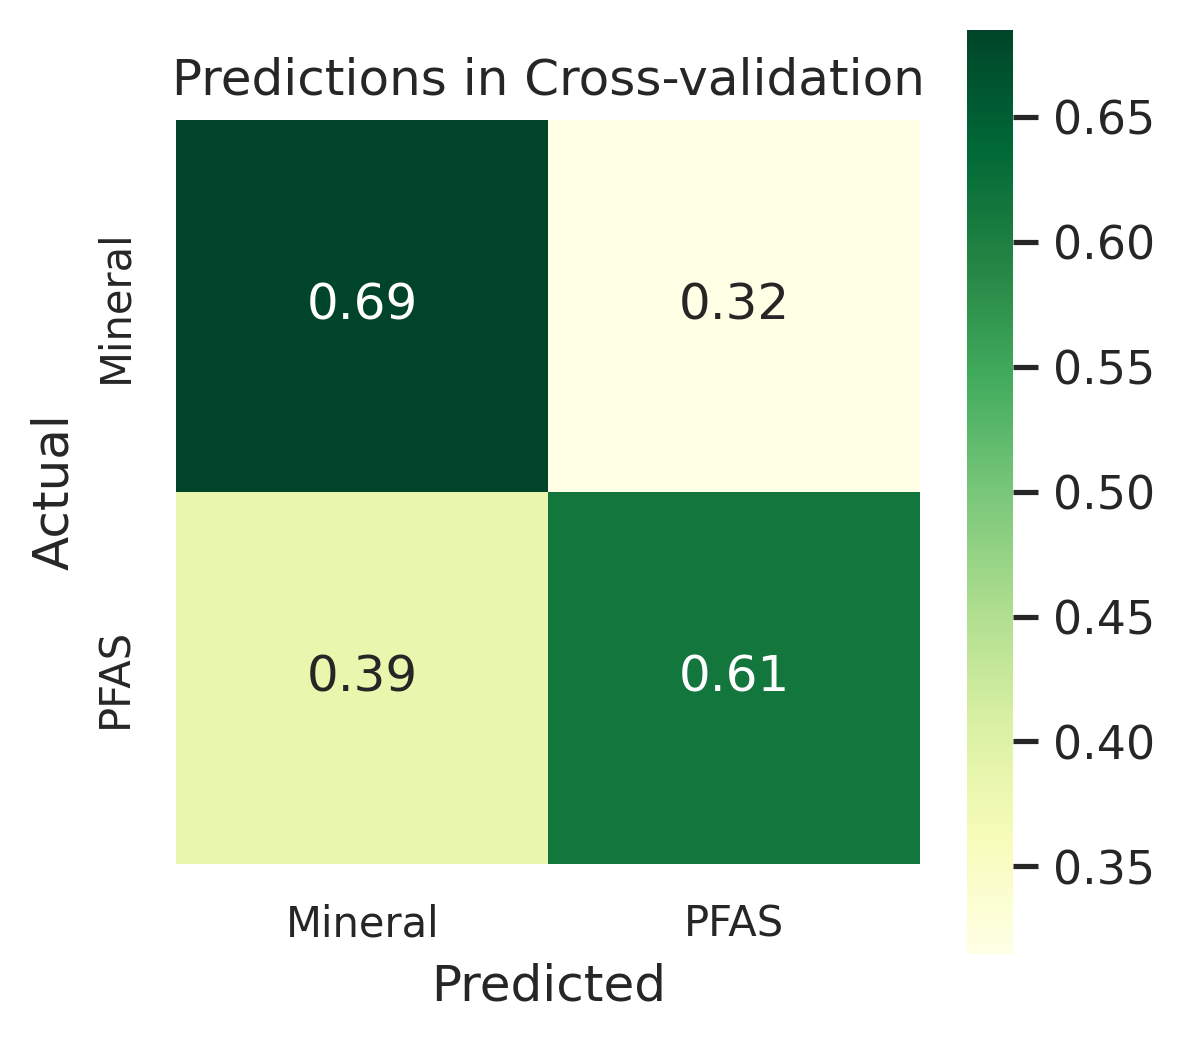

Level 1 Classification Report (Mineral vs PFAS):
              precision    recall  f1-score   support

     Mineral      0.649     0.685     0.667       200
        PFAS      0.652     0.615     0.633       192

    accuracy                          0.651       392
   macro avg      0.651     0.650     0.650       392
weighted avg      0.651     0.651     0.650       392

ROC curve for: PFAS
{'accuracy': np.float64(0.6505102040816326), 'roc_auc': np.float64(0.7197395833333333), 'f1_macro': np.float64(0.6495484189122177)}
--- Metric accuracy
   Training score: 1.0000
   Test score: 0.8646
   All scores:  [0.97916667 0.95833333 0.70833333 0.8125    ]
--- Metric f1_macro
   Training score: 1.0000
   Test score: 0.8632
   All scores:  [0.9791463  0.95816993 0.70651486 0.80879121]


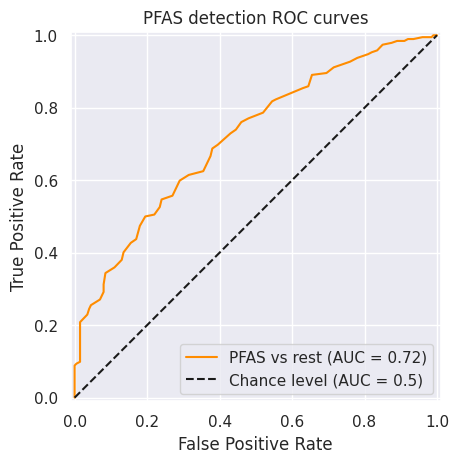

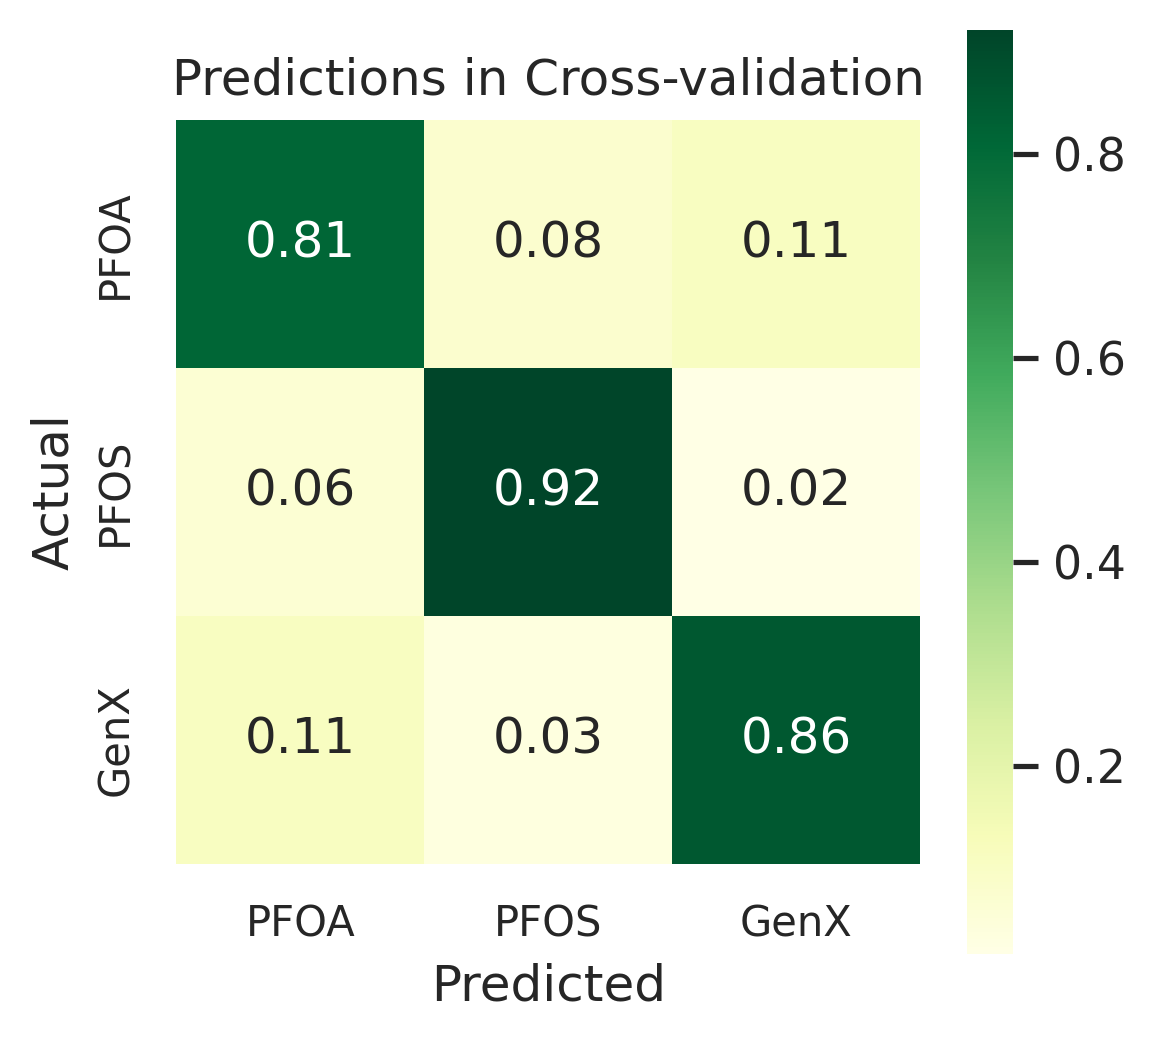

Level 2 Classification Report (PFOA PFOS GenX):
              precision    recall  f1-score   support

        GenX      0.873     0.859     0.866        64
        PFOA      0.825     0.812     0.819        64
        PFOS      0.894     0.922     0.908        64

    accuracy                          0.865       192
   macro avg      0.864     0.865     0.864       192
weighted avg      0.864     0.865     0.864       192



In [ ]:
groups = (pd.Series(data['Chip'][data['Reagent']=='1pgLysozyme'])-1)*4+pd.Series(data['Channel'][data['Reagent']=='1pgLysozyme'])
groups = groups.astype(int)
groups = groups.reset_index(drop=True)
y_level1 = y.apply(lambda x: 'Mineral' if x == 'BW' else 'PFAS')
CVscores_LeaveOneGroupOut_oversample(X, y_level1.reset_index(drop=True),
                                     labels=['Mineral', 'PFAS'], class_of_interest = 'PFAS', groups=groups)

X2 = X[y != 'BW']
X2.reset_index(drop = True, inplace = True)
# Split dataset for Level 2: PFOA, PFOA, GenX
y_level2 = y[y != 'BW'].apply(lambda x: x[-4:]).reset_index(drop=True)
groups_level2 = groups[y != 'BW']
CVscores_LeaveOneGroupOut(X2, y_level2, groups_level2)
Draw_PredCM_LeaveOneGroupOut(X2, y_level2, groups_level2)


In [ ]:
# Relabel the sample
y_level1 = y.apply(lambda x: 'Mineral' if x == 'BW' else 'PFAS')

scaler = StandardScaler()
Cnum = len(X.columns)
X.iloc[:, :Cnum] = scaler.fit_transform(X.iloc[:, :Cnum])

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=500)
rf_model.fit(X, y_level1)

RandomForestClassifier(min_samples_split=5, n_estimators=500)

frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  \
0       18      30      34      39      41      43      43      48      48   
1       15      28      33      37      41      44      48      49      52   
2       24      33      37      43      46      48      51      54      55   
3       24      34      39      41      45      48      50      53      57   
4       25      35      39      43      45      47      48      50      53   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
75      27      34      38      43      46      48      49      51      54   
76      11      30      36      41      44      47      50      52      53   
77      11      31      36      43      45      49      51      53      55   
78      13      32      39      44      47      49      51      53      54   
79      15      32      40      44      47      49      51      52      56   

    frame10  ...  frame146  frame147  frame148  frame149  frame150  Sample  \
0        50  ...       127       127       128       127       131   TW-15   
1        52  ...       132       132       131       131       131   TW-15   
2        55  ...       132       132       132       131       131   TW-15   
3        57  ...       132       132       132       133       133   TW-15   
4        54  ...       130       129       129       128       130   TW-15   
..      ...  ...       ...       ...       ...       ...       ...     ...   
75       56  ...       121       122       122       123       122   TW-15   
76       56  ...       116       117       117       117       117   TW-15   
77       57  ...       120       119       120       121       123   TW-15   
78       56  ...       123       124       125       125       124   TW-15   
79       58  ...       117       119       119       121       121   TW-15   

          Reagent  Chip  Channel  lane  
0     1pgLysozyme     1        1     1  
1     1pgLysozyme     1        1     2  
2     1pgLysozyme     1        1     3  
3     1pgLysozyme     1        1     4  
4     1pgLysozyme     1        1     5  
..            ...   ...      ...   ...  
75  100pgLysozyme     1        4     1  
76  100pgLysozyme     1        4     2  
77  100pgLysozyme     1        4     3  
78  100pgLysozyme     1        4     4  
79  100pgLysozyme     1        4     5  

[80 rows x 155 columns]

X_Test shape: (20, 92)
y_Test length: 20


Sample Sample_pred  value
0   TW-15     Mineral      1
1   TW-15        PFAS      1
2   TW-15     Mineral      1
3   TW-15     Mineral      1
4   TW-15     Mineral      1
5   TW-15        PFAS      1
6   TW-15     Mineral      1
7   TW-15     Mineral      1
8   TW-15     Mineral      1
9   TW-15     Mineral      1
10  TW-15     Mineral      1
11  TW-15        PFAS      1
12  TW-15     Mineral      1
13  TW-15        PFAS      1
14  TW-15        PFAS      1
15  TW-15     Mineral      1
16  TW-15        PFAS      1
17  TW-15        PFAS      1
18  TW-15     Mineral      1
19  TW-15        PFAS      1

Sample_pred  Mineral  PFAS
Sample                    
TW-15             12     8

Sample_pred  Mineral  PFAS
Sample                    
TW-15             12     8

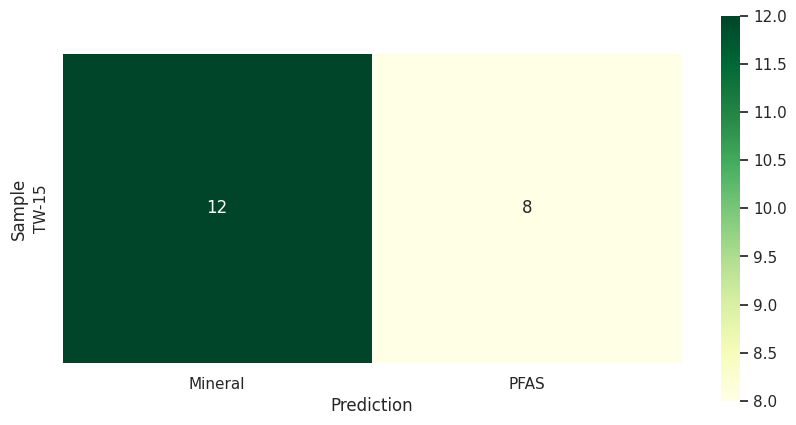

In [ ]:
# ---------------------------
# 1. Library import
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 2. Smoothing function
# ---------------------------
def smooth_flow(data, MovingAvgWindow=7):
    """
    Applies a moving average filter to smooth numeric time-series data.
    Handles string/object type issues by enforcing numeric conversion and ndarray casting.
    """
    # Convert to numeric and fill NaNs
    y = pd.to_numeric(data, errors='coerce').fillna(0)

    # Convert to numpy array to avoid pandas indexing issues (and FutureWarning)
    y = np.array(y)

    # Optional zero insert
    if y[0] != 0:
        y = np.insert(y, 0, 0)
        y = y[0:-1]

    # Apply moving average
    N = MovingAvgWindow
    y_padded = np.pad(y, (N // 2, N - 1 - N // 2), mode='edge')
    smoothed = np.convolve(y_padded, np.ones((N,)) / N, mode='valid')

    return pd.Series(smoothed)

# ---------------------------
# 3. Feature extraction (velocity, k-value, tail mean)
# ---------------------------
def extract_velocity(flow, step=15):
    return [np.mean(flow[i:i+step]) for i in range(0, len(flow), step)]

def extract_diffcoefK(flow, step=15):
    return [np.polyfit(range(i, i+step), flow[i:i+step], 1)[0]
            if len(flow[i:i+step]) == step else 0
            for i in range(0, len(flow), step)]

def extract_features(data, fps=15, flowlen=150, MovingAvgWindow=7):
    flows = data.iloc[:, :flowlen]
    flows = flows.apply(pd.to_numeric, errors='coerce').fillna(0)
    flows = flows.apply(smooth_flow, axis=1, MovingAvgWindow=MovingAvgWindow)

    feature_all = []
    for i in range(len(flows)):
        flow = flows.iloc[i, :].values
        velocity = extract_velocity(flow, step=fps)       # 10 features
        k_value = extract_diffcoefK(flow, step=fps)        # 10 features
        tail = [np.mean(flow[-5:]), np.max(flow[-5:]), np.min(flow[-5:])]  # 3 features
        features = velocity + k_value + tail               # total 23 per reagent
        feature_all.append(features)

    return pd.DataFrame(feature_all)

    #for i in range(len(flows)):
        #flow = flows.iloc[i, :].values

        #V1 = np.mean(flow[0:fps])
        #V = np.mean(flow)
        #K1 = np.polyfit(range(fps), flow[0:fps], 1)[0]
        #K = np.polyfit(range(flowlen), flow, 1)[0]
        #L = np.mean(flow[-5:])

        #features = [V, K, L]
        #feature_all.append(features)

    #return pd.DataFrame(feature_all, columns=['V', 'K', 'L'])

# ---------------------------
# 4. Concat features by reagent
# ---------------------------
def concat_reagent_fixed(data_feature, Reagents, reagent_order):
    Data = data_feature[Reagents == reagent_order[0]].reset_index(drop=True)
    for reagent in reagent_order[1:]:
        Data = pd.concat([
            Data,
            data_feature[Reagents == reagent].reset_index(drop=True)
        ], axis=1, ignore_index=True)
    return Data

# ---------------------------
# 5. Prediction + heatmap
# ---------------------------
def independent_test_file_simpleconcat(Test, rf_model):
    reagent_order = ['1pgLysozyme','100pgLysozyme','10ngBSA','1pgBSA']

    # Feature extraction
    Test_feature = extract_features(Test, fps=15, flowlen=150, MovingAvgWindow=7)

    # Ground truth from one reagent
    y_Test = Test[Test['Reagent'] == '1pgLysozyme']['Sample'].reset_index(drop=True)

    # Feature alignment by reagent
    X_Test = concat_reagent_fixed(Test_feature, Test['Reagent'], reagent_order)

    print(f"X_Test shape: {X_Test.shape}")
    print(f"y_Test length: {len(y_Test)}")

    # Standardization
    scaler = StandardScaler()
    X_Test.iloc[:, :] = scaler.fit_transform(X_Test)

    # Truncate if needed (e.g., to match 92 features used in training)
    X_Test = X_Test.iloc[:, :92]

    # Prediction
    sample_pred = rf_model.predict(X_Test)

    # Results table
    preds = pd.DataFrame({'Sample': y_Test, 'Sample_pred': sample_pred, 'value': 1})
    display(preds)

    # Confusion matrix
    hm = preds.pivot_table(index='Sample', columns='Sample_pred', values='value', aggfunc='sum').fillna(0).astype(int)
    display(hm)

    # Heatmap
    sns.set_theme()
    f, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(hm, annot=True, linewidths=.5, ax=ax, cmap="YlGn", square=True, fmt='d')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Sample')
    return hm

# ---------------------------
# 6. Load and preprocess test dataset
# ---------------------------
Test = pd.read_csv('/content/drive/MyDrive/PFAS_Project/PFAS data analysis/06222025_Tucson water prechlorination/Tucson Water_Prechlorination_15_180.csv')
Test = Test.drop(columns=['Unnamed: 0'], errors='ignore')
Test['Sample'] = Test['Sample'].apply(lambda x: 'Bottled Water' if x == 'BW' else x)
Test = Test[Test['Reagent'].isin(['1pgLysozyme','100pgLysozyme','10ngBSA','1pgBSA'])].reset_index(drop=True)

display(Test)

# ---------------------------
# 7. Run prediction
# ---------------------------
independent_test_file_simpleconcat(Test, rf_model)

frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  \
0       18      30      34      39      41      43      43      48      48   
1       15      28      33      37      41      44      48      49      52   
2       24      33      37      43      46      48      51      54      55   
3       24      34      39      41      45      48      50      53      57   
4       25      35      39      43      45      47      48      50      53   
..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
75      27      34      38      43      46      48      49      51      54   
76      11      30      36      41      44      47      50      52      53   
77      11      31      36      43      45      49      51      53      55   
78      13      32      39      44      47      49      51      53      54   
79      15      32      40      44      47      49      51      52      56   

    frame10  ...  frame146  frame147  frame148  frame149  frame150  Sample  \
0        50  ...       127       127       128       127       131   TW-15   
1        52  ...       132       132       131       131       131   TW-15   
2        55  ...       132       132       132       131       131   TW-15   
3        57  ...       132       132       132       133       133   TW-15   
4        54  ...       130       129       129       128       130   TW-15   
..      ...  ...       ...       ...       ...       ...       ...     ...   
75       56  ...       121       122       122       123       122   TW-15   
76       56  ...       116       117       117       117       117   TW-15   
77       57  ...       120       119       120       121       123   TW-15   
78       56  ...       123       124       125       125       124   TW-15   
79       58  ...       117       119       119       121       121   TW-15   

          Reagent  Chip  Channel  lane  
0     1pgLysozyme     1        1     1  
1     1pgLysozyme     1        1     2  
2     1pgLysozyme     1        1     3  
3     1pgLysozyme     1        1     4  
4     1pgLysozyme     1        1     5  
..            ...   ...      ...   ...  
75  100pgLysozyme     1        4     1  
76  100pgLysozyme     1        4     2  
77  100pgLysozyme     1        4     3  
78  100pgLysozyme     1        4     4  
79  100pgLysozyme     1        4     5  

[80 rows x 155 columns]

X_Test shape: (20, 92)
y_Test length: 20


Sample Sample_pred  value
0   TW-15     Mineral      1
1   TW-15        PFAS      1
2   TW-15     Mineral      1
3   TW-15     Mineral      1
4   TW-15     Mineral      1
5   TW-15        PFAS      1
6   TW-15     Mineral      1
7   TW-15     Mineral      1
8   TW-15     Mineral      1
9   TW-15     Mineral      1
10  TW-15     Mineral      1
11  TW-15        PFAS      1
12  TW-15     Mineral      1
13  TW-15        PFAS      1
14  TW-15        PFAS      1
15  TW-15     Mineral      1
16  TW-15        PFAS      1
17  TW-15        PFAS      1
18  TW-15     Mineral      1
19  TW-15        PFAS      1

Sample_pred  Mineral  PFAS
Sample                    
TW-15             12     8

Sample_pred  Mineral  PFAS
Sample                    
TW-15             12     8

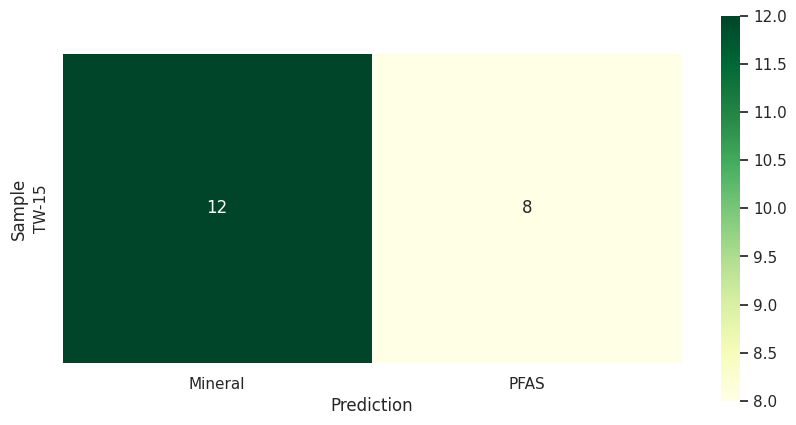

In [ ]:
# Function to concatenate features from each reagent in a fixed order
def concat_reagent_fixed(data_feature, Reagents, reagent_order):
    Data = data_feature[Reagents == reagent_order[0]].reset_index(drop=True)
    for reagent in reagent_order[1:]:
        Data = pd.concat([
            Data,
            data_feature[Reagents == reagent].reset_index(drop=True)
        ], axis=1, ignore_index=True)
    return Data

# Corrected label generation function (with debugging)
def get_labels_for_concatenated_features(Test, Test_feature, reagent_order):
    """
    Returns labels (Sample) in the same order as concat_reagent_fixed.
    Ensures that the number of labels matches the number of concatenated feature rows.
    """
    labels = []
    for reagent in reagent_order:
        idx = Test['Reagent'] == reagent
        sub_labels = Test.loc[idx, 'Sample'].reset_index(drop=True)
        sub_features = Test_feature.loc[idx].reset_index(drop=True)

        # Debugging
        print(f"[{reagent}] Sample labels: {len(sub_labels)}, Features: {len(sub_features)}")

        min_len = min(len(sub_labels), len(sub_features))
        labels.extend(sub_labels[:min_len])

    print(f"Total labels generated: {len(labels)}")
    return pd.Series(labels)

# Function to perform independent test and visualize predictions as a heatmap
def independent_test_file_simpleconcat(Test, rf_model):
    reagent_order = ['1pgLysozyme','100pgLysozyme','10ngBSA','1pgBSA']

    # Extract time-series features
    Test_feature = extract_features(Test, fps=15, flowlen=150, MovingAvgWindow=7)

    # Align labels with actual features used
    y_Test = Test[Test['Reagent'] == '1pgLysozyme']['Sample'].reset_index(drop=True)

    # Concatenate features in fixed reagent order
    X_Test = concat_reagent_fixed(Test_feature, Test['Reagent'], reagent_order)

    # Check shape consistency
    print(f"X_Test shape: {X_Test.shape}")
    print(f"y_Test length: {len(y_Test)}")

    # Standardize features
    scaler = StandardScaler()
    X_Test.iloc[:, :] = scaler.fit_transform(X_Test)

    # Align with number of features used in training (92)
    X_Test = X_Test.iloc[:, :92]

    # Predict
    sample_pred = rf_model.predict(X_Test)

    # Create result DataFrame
    preds = pd.DataFrame({'Sample': y_Test, 'Sample_pred': sample_pred, 'value': 1})
    display(preds)

    # Confusion matrix
    hm = preds.pivot_table(index='Sample', columns='Sample_pred', values='value', aggfunc='sum').fillna(0).astype(int)
    display(hm)

    # Plot heatmap
    import seaborn as sns
    sns.set_theme()
    f, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(hm, annot=True, linewidths=.5, ax=ax, cmap="YlGn", square=True, fmt='d')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Sample')
    return hm
    return preds

# ---------------------------
# Load and preprocess test dataset
# ---------------------------
Test1 = pd.read_csv('/content/drive/MyDrive/PFAS_Project/PFAS data analysis/06222025_Tucson water prechlorination/Tucson Water_Prechlorination_15_180.csv')
Test = pd.concat([Test1])
Test = Test.drop(columns=['Unnamed: 0'])

# Rename 'BW' to 'Bottled Water'
Test['Sample'] = Test['Sample'].apply(lambda x: 'Bottled Water' if x == 'BW' else x)

# Filter reagents to match training data
Test = Test[Test['Reagent'].isin(['1pgLysozyme','100pgLysozyme','10ngBSA','1pgBSA'])].reset_index(drop=True)

# Display test data
display(Test)

# Run the test function
independent_test_file_simpleconcat(Test, rf_model)